## # Sliding Window
# Feb 2019
#
import matplotlib.patches as patches
import seaborn as sns
import copy
import torchvision
from IPython.display import display  # to display images
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

import time
import os

from IPython.display import Audio

In [1]:
# # Sliding Window
# Feb 2019
# Implement classfication and regression as two separate networks

import matplotlib.patches as patches
import seaborn as sns
import copy
import torchvision
from IPython.display import display  # to display images
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

import time
import os

from IPython.display import Audio

# In[2]:

In [2]:
IMG_X, IMG_Y = 200, 200
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30


# Make dataset -------------------------------------------------------

def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0), ]
    return [(c * x - s * y + offset[0],
             s * x + c * y + offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = "./" + dirname
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        # orient = 0 # degrees
        img = Image.new("RGB", (IMG_X, IMG_Y), "black")

        # block_l and _w offset so blocks don't run off edge of image
        rand_x = int(np.random.rand() * (IMG_X - 2 * block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y - 2 * block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient)  # math.cos takes radians!
        
        rect_vertices = makeRectangle(
            block_l, block_w, orient, offset=(rand_x, rand_y))

       # true_coords.append(np.array((rand_x, rand_y, math.degrees(orient))))
        true_coords.append(np.array((rand_y, rand_x, math.degrees(orient))))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill="white")

        img.save(newpath + "/rect" + str(i) + ".png")
    return true_coords


# NOTE Define size of dataset
train_truth = make_dataset("data", 1500)
# print(len(train_truth))
test_truth = make_dataset("./data/test", 300)

np.save("train_truth.npy", train_truth)
np.save("test_truth.npy", test_truth)


train_truth = np.load("train_truth.npy")
test_truth = np.load("test_truth.npy")  # loading the training and testing data5

./data
././data/test


In [3]:
# Define Dataloader -------------------------------------------------------

class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        MARGIN_PX = 10
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.detectMargin = MARGIN_PX

    def __len__(self):
        # print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + "/rect" +
                          str(idx) + ".png", as_gray=True)
        # image = torch.FloatTensor(image).permute(2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        crops, labels, cropCoords = self.makeCrops(
            image, self.step, self.cropSize, coords, self.detectMargin)

        sample = image, torch.FloatTensor(labels), torch.FloatTensor(cropCoords)
        return sample

    def makeCrops(self, image, stepSize, windowSize, rectCenter, detectMargin):
        """
        Returns image crops, as well as T/F for those crops
        """
        crops = []
        # c_x, c_y, theta = rectCenter
        c_y, c_x, theta = rectCenter
        margin = detectMargin
        hasRects = []
        rectCoords = []
        for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                hasRect = (x + margin < c_x < end_x - margin) and (
                    y + margin < c_y < end_y - margin)
                crops.append(image[y:end_y, x:end_x])
                hasRects.append(hasRect)
                if hasRect:
                    rectCoords.append((c_y, c_x, theta))
                else:
                    # NOTE: Return empty label, when not hasRect
                    rectCoords.append((0, 0, 0))
        # print('length of truths in makeCrops', len(truths))
        return crops, hasRects, rectCoords


In [4]:
# -- Define NN -------------------------------------------------------

class regrNet(nn.Module):
    def __init__(self, cropSize, numOutputs):
        """
        We need the image width and height to determine CNN layer sizes
        """
        super(regrNet, self).__init__()
        _pool = 2
        _stride = 5
        _outputlayers = 16

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        self.step = STEPSIZE
        self.cropSize = cropSize
        self.numOutputs = numOutputs

        self.numCrops = 0
        # calculate number of crops
        for y in range(0, IMG_Y - WINDOWSIZE[0] + 1, STEPSIZE):
            for x in range(0, IMG_X - WINDOWSIZE[1] + 1, STEPSIZE):
                self.numCrops += 1

        def _calc(val):  # use to calculate layer sizes
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        self._const = _calc(_calc(self.cropSize[0]))
        self._const *= _calc(_calc(self.cropSize[1]))
        self._const *= _outputlayers
        self._const = int(self._const)

        # --- LOCATION OF RECTANGLE
        # NOTE: only one channel for now (black/white)
        self.conv1 = nn.Conv2d(self.numCrops, 6, _stride).to(device)
        self.bn = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(_outputlayers)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, self.numOutputs * self.numCrops).to(device)

    def forward(self, crops, labels):
        """
        Forward propogation
        : param image: images, a tensor of dimensions(N, 3, IMG_X, IMG_Y)
        : return: (x, y, theta) and T/F for each window
        """
        # TODO: presumably by doing this i lose some of the multithread goodness
        # print('!--label ', labels)
        # print('!--label size', labels.size)
        # print('!--crops size', crops.size)
        crops = crops.to(device)

        crops = self.zeroCrops(crops, labels)

        # LOCALIZATION
        regr_crops = self.pool(F.relu((self.bn(self.conv1(crops)))))
        regr_crops = self.pool(F.relu(self.bn2(self.conv2(regr_crops))))
        regr_crops = regr_crops.view(-1, self._const)
        regr_crops = F.relu(self.fc1(regr_crops))
        regr_crops = F.relu(self.fc2(regr_crops))
        regr_crops = self.fc3(regr_crops)

        objCoords = regr_crops
        
        # reshape to batchsize x number of crops x 3
        objCoords = objCoords.reshape(-1, self.numCrops, self.numOutputs)
        return objCoords

    def zeroCrops(self, crops, labels):
        # 15 x 9
        # 15 x 9 x 100 x 100
        labels = torch.FloatTensor(labels).to(device)
        mask = labels.unsqueeze(2)
        mask.unsqueeze_(3)
        crops = crops * mask
        return crops


class classifNet(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        """
        We need the image width and height to determine CNN layer sizes
        """
        super(classifNet, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.numCrops = 0
        # T/F for now

        # calculate number of crops
        for y in range(0, IMG_Y - WINDOWSIZE[0] + 1, STEPSIZE):
            for x in range(0, IMG_X - WINDOWSIZE[1] + 1, STEPSIZE):
                self.numCrops += 1

        def _calc(val):  # use to calculate layer sizes
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        # print(self._imgx)
        # self._const = _calc(_calc(self._imgx))
        # self._const *= _calc(_calc(self._imgy))
        self._const = _calc(_calc(self.cropSize[0]))
        self._const *= _calc(_calc(self.cropSize[1]))
        self._const *= _outputlayers
        self._const = int(self._const)

        # --- CLASSIFICATION OF WINDOWS
        # batch, 3 input image channels (RGB), 6 output channels, 5x5 square convolution
        # NOTE: we switched to 1 input channel
        self.conv1 = nn.Conv2d(self.numCrops, 6, _stride).to(device)
        self.bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.bn2 = nn.BatchNorm2d(_outputlayers)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, self.numCrops).to(device)
        self.sigmoid = nn.Sigmoid()
        # TODO: batch normalization  self.bn = nn.BatchNorm2d()

    def forward(self, x):
        """
        Forward propogation
        : param image: images, a tensor of dimensions(N, 3, IMG_X, IMG_Y)
        : return: (x, y, theta) and T/F for each window
        """
        x = x.to(device)
        batch_images = x

        all_crops = []
        for img in batch_images:
            crops = self.makeCrops(img, self.step, self.cropSize)
            all_crops.append(crops)
            # all_crops.append(crops)
        all_crops = torch.stack(all_crops)
        feats = all_crops.view(-1, self.numCrops, self.cropSize[0],
                               self.cropSize[1]).to(device)

        # CLASSIFICATION of the windows
        c_crops = self.pool(F.relu((self.bn(self.conv1(feats)))))
        c_crops = self.pool(F.relu(self.bn2(self.conv2(c_crops))))
        c_crops = c_crops.view(-1, self._const)
        c_crops = F.relu(self.fc1(c_crops))
        c_crops = F.relu(self.fc2(c_crops))
        c_crops = self.fc3(c_crops)
        c_crops = self.sigmoid(c_crops)

        containsObj = c_crops

        return containsObj, all_crops

    def makeCrops(self, image, stepSize, windowSize):
        """
        Returns a generator of cropped boxes(the top left x, y, the image data)
        """
        image = image.type(torch.FloatTensor).to(device)
        crops = []

        # TODO: look into ordering, why it's y,x !
        for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                # print('This is the x and y used: ', x, '; ', y)
                crops.append(image[y:end_y, x:end_x])
        crops = torch.stack(crops)
        # self.numCrops=len(crops)
        return crops

In [5]:
# -- Utility fxn -------------------------------------------------------
# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(
    epoch, epochs_since_improvement, model1, model2, optimizer1, optimizer2, loss, loss2, best_loss, is_best
):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        "epoch": epoch,
        "epochs_since_improvement": epochs_since_improvement,
        "loss": loss,
        "loss2": loss2,
        "best_loss": best_loss,
        "model1": model1,
        "model2": model2,
        "optimizer1": optimizer1,
        "optimizer2": optimizer2,
    }
    filename = "checkpoint_v2sliding.pth.tar"
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, "BEST_" + filename)

In [6]:
# -- Define Train and Valid fxn -------------------------------------------------------
plt_loss_list = []
plt_loss2_list = []

def train(train_loader, classifModel, regrModel, classifCriterion,
          regrCriterion, optimizer1, optimizer2, epoch):
    """
    One epoch's training.
    : param train_loader: DataLoader for training data
    : param model: model
    : param criterion: for classification (crop contains an Obj, t/f)
    : param criterion: for regresion (of the x,y, theta)
    : param optimizer: optimizer
    : param epoch: epoch number
    """

    classifModel.train()  # training mode enables dropout
    regrModel.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss
    start = time.time()
    

    for i_batch, (images, labels, coords) in enumerate(train_loader):
        data_time.update(time.time() - start)

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        predicted_class, all_crops = classifModel(images)

        loss1 = classifCriterion(predicted_class, labels)
        optimizer1.zero_grad()
        loss1.backward()

        # Update model
        optimizer1.step()
        losses.update(loss1.item())

        batch_time.update(time.time() - start)
        start = time.time()

        # Print status
        if i_batch % print_freq == 0:
            print(
                "Epoch: [{0}][{1}/{2}]\t"
                "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "CLoss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                    epoch,
                    i_batch,
                    len(train_loader),
                    batch_time=batch_time,
                    loss=losses,
                )
            )
        # free some memory since their histories may be stored
        plt_loss_list.append(loss1.item())
        del predicted_class, images, labels, all_crops

    losses2 = AverageMeter()  # loss

    for i_batch, (images, labels, coords) in enumerate(train_loader):
        #print('\n!--- \n training regression!')
        data_time.update(time.time() - start)

        images = images.to(device)
        coords = coords.to(device)

        # Forward pass
        with torch.no_grad():
            predicted_class, all_crops = classifModel(images)

        # Forward pass
        labelly = predicted_class.detach().cpu().numpy()
        predicted_coords = regrModel(all_crops, labelly)

        loss2 = regrCriterion(predicted_coords, coords)
        loss = classifCriterion(predicted_class, labels.to(device))
        if loss2 <= 30:
            print('!-- predicted coord: ', predicted_coords[0], '\n coords: ', coords[0], '\nloss', loss2[0])
            print('!-- predicted label:', predicted_class[0], '\n label: ', labels[0], '\nloss', loss[0])
        optimizer2.zero_grad()
        loss2.backward()

        optimizer2.step()

        batch_time.update(time.time() - start)
        start = time.time()

        losses2.update(loss2.item())

        # Print status
        if i_batch % print_freq == 0:
            print(
                "Epoch: [{0}][{1}/{2}]\t"
                "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "RLoss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                    epoch,
                    i_batch,
                    len(train_loader),
                    batch_time=batch_time,
                    loss=losses2,
                )
            )
        # free some memory since their histories may be stored
        
        plt_loss2_list.append(loss2.item())
        del predicted_class, predicted_coords, images, coords, all_crops


def validate(val_loader, c_model, r_model, c_criterion, r_criterion):
    """
    One epoch's validation.
    : param val_loader: DataLoader for validation data
    : param model: model
    : param criterion: MultiBox loss
    : return: average validation loss
    """
    c_model.eval()  # eval mode disables dropout
    r_model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()
    losses2 = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i_batch, (images, labels, coords) in enumerate(train_loader):
            # Move to default device
            images = images.to(device)
            labels = labels.to(device)
            coords = coords.to(device)

            predicted_class, all_crops = c_model(images)
            loss = c_criterion(predicted_class, labels)

            labelly = predicted_class.detach().cpu().numpy()
            predicted_coords = r_model(all_crops, labelly)

            loss2 = r_criterion(predicted_coords, coords)

            losses.update(loss.item())
            losses2.update(loss2.item())

            batch_time.update(time.time() - start)
            start = time.time()

            # Print status
            if i_batch % print_freq == 0:
                print(
                    "[{0}/{1}]\t"
                    "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t",
                    "CLoss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                        i_batch, len(val_loader), batch_time=batch_time, loss=losses ),
                    "RLoss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                        i_batch, len(val_loader), batch_time=batch_time, loss=losses2
                    )
                )

    print("\n * LOSS - {loss.avg:.3f}\n".format(loss=losses))

    return losses.avg, losses2.avg

In [7]:
# -- Load data -------------------------------------------------------
batch_size = 30  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)


# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir="./data", coords=train_truth)

# Data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir="./data/test", coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=True)

CUDA available? device:  cuda:0


In [8]:
# -- Hyperparamaters -------------------------

num_epochs = 100  # number of epochs to run without early-stopping
learning_rate = 0.001

start_epoch = 0  # start at this epoch
# number of epochs since there was an improvement in the validation metric
epochs_since_improvement = 0
best_loss = 1000.0  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader

print_freq = 25  # print training or validation status every __ batches


In [9]:
def main():
    """
    Training and validation.
    """

    global epochs_since_improvement, start_epoch, best_loss, epoch, checkpoint
    
    classifModel = classifNet(IMG_X, IMG_Y)
    classifModel = classifModel.to(device)

    regrModel = regrNet((100, 100), 3)  # crop size in pixels; output x,y, theta
    regrModel = regrModel.to(device)

    # criterion = nn.BCELoss()
    classifCriterion = nn.BCELoss()
    regrCriterion = nn.MSELoss()
    optimizer1 = torch.optim.Adam(classifModel.parameters(), lr=learning_rate)
    optimizer2 = torch.optim.Adam(regrModel.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
    #                             momentum=momentum, weight_decay=weight_decay)


    print("Training model now...")

    # -- Begin training -------------------------

    for epoch in range(num_epochs):
        train(
            train_loader=train_loader,
            classifModel=classifModel,
            regrModel=regrModel,
            classifCriterion=classifCriterion,
            regrCriterion=regrCriterion,
            optimizer1=optimizer1,
            optimizer2=optimizer2,
            epoch=epoch,
        )

        # One epoch's validation
        val_loss, regr_loss = validate(val_loader=test_loader,
                                       c_model=classifModel, r_model=regrModel,
                                       c_criterion=classifCriterion,
                                       r_criterion=regrCriterion)

        # Did validation loss improve?
        is_best = val_loss < best_loss
        best_loss = min(val_loss, best_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" %
                  (epochs_since_improvement,))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(epoch, epochs_since_improvement, classifModel, regrModel, optimizer1,
                        optimizer2, val_loss, regr_loss, best_loss, is_best)

    print("All ready!")

    # -- Check the results -------------------------------------------------------


# Running main!

In [10]:
main()

# alert when training is done
sound_file = '/home/rui/Downloads/newyear.ogg'
Audio(sound_file, autoplay=True)

Training model now...
Epoch: [0][0/50]	Batch Time 0.056 (0.056)	CLoss 0.6904 (0.6904)	
Epoch: [0][25/50]	Batch Time 0.047 (0.048)	CLoss 0.1217 (0.2909)	
Epoch: [0][0/50]	Batch Time 0.048 (0.048)	RLoss 2463.0339 (2463.0339)	
Epoch: [0][25/50]	Batch Time 0.049 (0.048)	RLoss 1488.4672 (2073.9439)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0460 (0.0460)	 RLoss 1251.8378 (1251.8378)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0301 (0.0408)	 RLoss 1385.8165 (1435.9566)	

 * LOSS - 0.041

Epoch: [1][0/50]	Batch Time 0.048 (0.048)	CLoss 0.0348 (0.0348)	


/home/rui/mlenv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type classifNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rui/mlenv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type regrNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0229 (0.0465)	
Epoch: [1][0/50]	Batch Time 0.046 (0.047)	RLoss 1451.3844 (1451.3844)	
Epoch: [1][25/50]	Batch Time 0.048 (0.048)	RLoss 986.2381 (1119.3121)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0192 (0.0192)	 RLoss 965.1230 (965.1230)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0538 (0.0275)	 RLoss 693.2997 (778.0280)	

 * LOSS - 0.030

Epoch: [2][0/50]	Batch Time 0.048 (0.048)	CLoss 0.0131 (0.0131)	
Epoch: [2][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0350 (0.0341)	
Epoch: [2][0/50]	Batch Time 0.047 (0.047)	RLoss 816.0134 (816.0134)	
Epoch: [2][25/50]	Batch Time 0.049 (0.047)	RLoss 636.3197 (726.8938)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0207 (0.0207)	 RLoss 537.5273 (537.5273)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0128 (0.0188)	 RLoss 486.8264 (523.5499)	

 * LOSS - 0.019

Epoch: [3][0/50]	Batch

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0002 (0.0002)	 RLoss 195.6381 (195.6381)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0001 (0.0001)	 RLoss 170.5192 (158.4847)	

 * LOSS - 0.000

Epoch: [17][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0003 (0.0003)	
Epoch: [17][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0001 (0.0002)	
Epoch: [17][0/50]	Batch Time 0.047 (0.047)	RLoss 140.8010 (140.8010)	
Epoch: [17][25/50]	Batch Time 0.049 (0.048)	RLoss 170.8482 (162.0174)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0001 (0.0001)	 RLoss 143.6399 (143.6399)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0001 (0.0001)	 RLoss 138.1751 (159.4609)	

 * LOSS - 0.000

Epoch: [18][0/50]	Batch Time 0.048 (0.048)	CLoss 0.0004 (0.0004)	
Epoch: [18][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0001 (0.0002)	
Epoch: [18][0/50]	Batch Time 0.047 (0.047)	RLoss 150.8484 (150.8484)	
Epoch: [18][25/50]	Batc

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0002 (0.0002)	 RLoss 52.9154 (52.9154)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0002 (0.0003)	 RLoss 66.5133 (64.9843)	

 * LOSS - 0.000


Epochs since last improvement: 12

Epoch: [32][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [32][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0001 (0.0007)	
Epoch: [32][0/50]	Batch Time 0.047 (0.047)	RLoss 69.8871 (69.8871)	
Epoch: [32][25/50]	Batch Time 0.048 (0.047)	RLoss 89.1406 (68.5841)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0001 (0.0001)	 RLoss 83.9030 (83.9030)	
[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0001 (0.0001)	 RLoss 80.8438 (72.7243)	

 * LOSS - 0.000


Epochs since last improvement: 13

Epoch: [33][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0001 (0.0001)	
Epoch: [33][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0001 (0.0002)	
Epoch: [33][0/50]	Batch Time 0.04

/home/rui/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/rui/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


!-- predicted coord:  tensor([[  1.9668,   0.6670,   1.1869],
        [  1.1168,   0.0381,  -2.5701],
        [  4.1808,   4.1169,  -0.3232],
        [123.8657,  57.1722, 150.1629],
        [ -1.6045,   0.6577,  -2.4779],
        [  1.6210,   6.5019,  -3.4568],
        [136.1968,  58.6363, 153.4959],
        [ -2.1555,   3.4032,   7.3899],
        [  2.7856,  -2.6117,  -1.8985]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126.,  56., 154.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126.,  56., 154.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(26.0593, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.5377e-06, 4.8911e-13, 4.4204e-11, 1.0000e+00, 1.1876e-09, 1.3381e-12,
        1.0000e+00, 6.4242e-12, 1.9943e-15], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -5.2852,  -4.7244,  -6.3221],
        [  0.7289,   5.6874,  -3.2918],
        [  4.8217,   5.4794,   2.9799],
        [  1.3419,  -0.5306,  -1.0235],
        [  5.2636,   5.8536, -14.9514],
        [110.6534, 136.7546,  74.5208],
        [ -3.0947,   0.9629,   0.7944],
        [  7.0106,   6.0766,  -6.6656],
        [106.8310, 129.5309,  70.0577]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [121., 140.,  62.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [121., 140.,  62.]], device='cuda:0') 
loss tensor(28.8769, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.4336e-08, 5.3047e-12, 1.0604e-07, 4.1611e-06, 6.1770e-05, 1.0000e+00,
        6.5994e-10, 1.9966e-05, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -3.9914,  -0.8491,  -1.5721],
        [  0.5388,   4.0006,  -1.1899],
        [ 52.5155, 157.5854,  86.5158],
        [ -0.5697,  -2.6867,   3.4170],
        [  0.5427,  -2.7326,  -0.4451],
        [ -3.5283,  -5.5332,  -5.1268],
        [  4.1617,   1.4471,   0.2610],
        [ -0.4044,   1.2365,  -2.9314],
        [  1.2966,   3.8249,   1.0527]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 54., 146.,  77.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(24.2517, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.6194e-12, 4.0939e-08, 1.0000e+00, 1.1532e-16, 9.8184e-24, 1.8025e-14,
        6.0325e-11, 2.6323e-23, 2.2546e-09], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 85.0382,  78.3619, 103.4353],
        [ 83.9142,  83.1350, 108.3699],
        [  1.8950,   2.2972,  -1.8941],
        [ 88.9077,  87.0008, 113.0580],
        [ 89.1382,  84.6411, 113.6366],
        [  1.1132,  -0.1791,  -7.6418],
        [  6.6940,   1.7364,  -2.6743],
        [ -1.4718,  -0.8233,   0.0702],
        [ -2.8068,  -3.2854,  -0.6601]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 85.,  83., 112.],
        [ 85.,  83., 112.],
        [  0.,   0.,   0.],
        [ 85.,  83., 112.],
        [ 85.,  83., 112.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(28.2064, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 3.4588e-07, 9.9999e-01, 9.9999e-01, 4.7668e-08,
        2.2541e-08, 3.9114e-11, 2.1172e-12], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
los

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0000 (0.0000)	 RLoss 83.4953 (71.0017)	

 * LOSS - 0.000

Epoch: [46][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [46][25/50]	Batch Time 0.048 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [46][0/50]	Batch Time 0.047 (0.047)	RLoss 38.3311 (38.3311)	
!-- predicted coord:  tensor([[64.5686, 45.0077, 21.3752],
        [ 5.6887,  3.8474, -1.1499],
        [-1.4876,  2.2303,  1.4909],
        [69.7207, 47.1413, 22.1681],
        [10.1889,  3.6857,  6.3773],
        [ 0.8703,  6.1080, 11.1052],
        [ 0.5463,  4.1238, -1.0820],
        [ 6.1178, -0.5256, -3.1095],
        [ 1.5616, -0.3029, -0.7994]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[73., 44.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [73., 44.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss t

!-- predicted coord:  tensor([[ -2.4498,   4.2050,  -0.2620],
        [  0.6552,   5.1945,  -6.7514],
        [  1.7502,   0.4183,  -7.2636],
        [  0.2721,  -0.1006,  -0.6269],
        [102.3168, 122.5612,  70.9741],
        [ 92.5901, 114.1724,  56.3727],
        [ -2.1375,  -4.2458,  -3.2976],
        [  2.8885,   3.9185,  -5.2673],
        [  4.9901,   4.3436,  -4.9713]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 99., 120.,  60.],
        [ 99., 120.,  60.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(29.6741, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.8868e-13, 2.7611e-12, 4.6114e-10, 5.2204e-09, 1.0000e+00, 1.0000e+00,
        1.9068e-16, 2.5683e-14, 1.1043e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 82.8578,  47.6787, 145.5372],
        [  0.5267,  -3.1337,  -1.7364],
        [ -1.0755,  -0.7191,   1.1993],
        [ 83.5176,  48.1768, 152.8235],
        [  2.2628,   4.0141,   5.0802],
        [ -1.5710,  -4.2428,  -3.0326],
        [ -3.4908,  -0.6633,  -3.8477],
        [ -3.1006,  -2.8590,  -1.5032],
        [  0.5802,   2.5407,   2.8911]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 83.,  48., 146.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 83.,  48., 146.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(26.2091, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 7.3670e-16, 1.4096e-10, 1.0000e+00, 3.3191e-13, 5.2942e-13,
        1.1245e-06, 2.6956e-21, 2.1010e-15], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
los

 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [150., 161., 122.]], device='cuda:0') 
loss tensor(28.0844, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.0123e-08, 3.3579e-11, 1.1113e-07, 1.1370e-12, 1.3651e-22, 2.8188e-15,
        1.8882e-10, 8.9253e-11, 9.9995e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
loss tensor(0.0000, device='cuda:0')
!-- predicted coord:  tensor([[ -4.2615,  -1.0483,  -1.6566],
        [ 34.7124, 137.5050, 143.1059],
        [ 38.5169, 138.0649, 150.0019],
        [  3.5340,   4.5385,  10.8120],
        [  0.0136,  -1.1762,  -5.0043],
        [ -1.2708,  -6.0367,   2.5067],
        [  0.0586,  -1.4543,   5.7677],
        [  0.4259,  -1.4598,   2.2423],
        [ -0.2398,  -0.4673,  -1.9141]],
       device='cu

!-- predicted coord:  tensor([[  0.9849,   0.1489,   2.3521],
        [  4.8805,  -2.7985,  -4.7375],
        [ 74.5886, 156.5544,  21.1093],
        [ -3.5322,   0.6239,   2.4181],
        [  1.2491,   1.8121,  -4.9124],
        [ 80.8736, 159.8371,  16.7644],
        [ -6.2603,   0.7341,   1.0211],
        [  1.8542,   0.7909,   0.9781],
        [  6.3244,   5.8836,  -1.2565]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 89., 156.,  21.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 89., 156.,  21.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(24.8885, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.7140e-16, 1.9872e-13, 9.9986e-01, 1.7656e-11, 7.1370e-12, 1.0000e+00,
        4.1617e-11, 1.4549e-22, 2.6019e-09], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.9757,   2.9228,  -0.3320],
        [ -0.8024,  -0.0055,   1.1124],
        [ 73.2267, 149.6259, 167.8747],
        [ -2.9065,   1.6063,  -0.3213],
        [ -5.6078,  -0.0648,  -1.6855],
        [ 68.8601, 134.2135, 173.1792],
        [  5.9736,  -3.5865,   0.5852],
        [  4.6492,   3.6567,  -5.9002],
        [  1.5952,  -4.7883,   2.6393]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 70., 144., 172.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 70., 144., 172.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(21.7351, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.7383e-16, 2.6228e-10, 1.0000e+00, 2.3996e-10, 2.0100e-10, 1.0000e+00,
        6.7057e-11, 8.9919e-19, 5.0939e-06], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0000 (0.0000)	 RLoss 45.3510 (44.5427)	

 * LOSS - 0.000

Epoch: [49][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [49][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
!-- predicted coord:  tensor([[ -5.9498,  -3.4963,  -0.0280],
        [ -3.4425,  -8.6574,  -2.9821],
        [  1.4637,  -7.6016,   1.9618],
        [141.3663,  69.8096,  41.4470],
        [140.3489,  75.4345,  45.4276],
        [ -2.6456,   0.3851,  -0.4092],
        [144.6344,  77.0240,  48.5408],
        [135.8208,  74.4577,  46.9641],
        [ -0.4877,  -3.3496,  -0.8078]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [135.,  71.,  42.],
        [135.,  71.,  42.],
        [  0.,   0.,   0.],
        [135.,  71.,  42.],
        [135.,  71.,  42.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(27.8972,

!-- predicted coord:  tensor([[  1.3952,  -0.8321,   0.9155],
        [ -0.3322,  -2.5662,   0.9408],
        [  0.8787,  -1.2949,   0.5620],
        [ -7.5401,  -6.8708,   1.3502],
        [ -0.3229,   0.0700,   2.7207],
        [  0.8429,   1.6201,   0.9712],
        [144.4548,  42.8591, 105.8854],
        [  1.7437,  -0.0547,   4.9522],
        [ -2.0595,   0.3816,  -2.2411]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [148.,  45., 116.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(25.8173, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0092e-08, 1.6708e-09, 2.0201e-07, 1.1746e-12, 1.6695e-10, 1.7189e-12,
        9.9999e-01, 1.7312e-08, 7.8796e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[  6.3607,   3.8204,   0.2689],
        [ -3.0793,  -4.3439,   4.3476],
        [ -4.1997,  -2.8873,  -0.7087],
        [  0.9071,   3.7837,   2.5755],
        [121.0754,  98.4925, 140.4447],
        [ -4.3207,  -2.9546,   5.7701],
        [ -1.5524,  -2.8983,   8.9636],
        [116.2239,  92.9861, 133.0708],
        [ -5.4986,  -1.8096,   5.8477]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126., 107., 141.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126., 107., 141.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(28.0435, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.9618e-11, 3.0870e-05, 1.5089e-15, 2.7729e-08, 1.0000e+00, 1.4182e-06,
        2.8998e-10, 1.0000e+00, 7.4186e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[  2.0986,   0.0391,  -3.5730],
        [ -4.2223,  -3.5037,  -2.7974],
        [ 61.3115, 152.5735,  87.2500],
        [ -0.1823,   2.5895,   0.8579],
        [  1.0551,   1.6517,  -1.3169],
        [ 63.6580, 151.4161,  83.9117],
        [ -3.5500,  -3.7533,  -0.6503],
        [ -1.2952,  -0.2961,  -1.9386],
        [ -3.0307,  -0.7710,  -4.0733]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 62., 156.,  77.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 62., 156.,  77.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.8075, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.3010e-13, 8.7794e-10, 1.0000e+00, 5.1185e-09, 4.7308e-10, 9.9978e-01,
        1.0419e-08, 1.1005e-18, 1.4824e-07], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 1.4322e-07, 9.9999e-01, 9.9999e-01, 3.6925e-07,
        1.1278e-08, 2.7741e-10, 1.0015e-10], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(7.7978e-06, device='cuda:0')
!-- predicted coord:  tensor([[ 64.5919,  49.4867, 112.2657],
        [ -1.9744,  -1.5293,  -1.4789],
        [ -0.1156,  -1.4526,  -0.0981],
        [ 55.2609,  47.2467,  99.4538],
        [ -1.5996,  -0.7096,   0.1639],
        [  0.3352,   0.4758,   3.5537],
        [ -3.6603,  -1.1436,  -2.8554],
        [ -1.5936,  -0.7843,  -1.6940],
        [ -0.8162,   1.5450,  -1.7435]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 61.,  53., 119.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 61.,  53., 119.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(28.2103, devi

!-- predicted coord:  tensor([[ -1.2495,  -1.3299,   1.4473],
        [  1.1926,   7.1826,   5.8695],
        [  7.1115,  11.4668,  -3.7384],
        [106.2723,  69.5220,   4.5806],
        [112.2485,  75.5458,  10.7430],
        [  0.7327,   1.1757,   7.3788],
        [105.2269,  72.1242,   8.2213],
        [129.9973,  85.2771,  10.2248],
        [  2.8426,  -3.4057,   5.1787]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111.,  76.,   9.],
        [111.,  76.,   9.],
        [  0.,   0.,   0.],
        [111.,  76.,   9.],
        [111.,  76.,   9.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(26.0877, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.6361e-08, 4.2655e-06, 2.4309e-14, 1.0000e+00, 1.0000e+00, 3.1333e-05,
        9.9998e-01, 9.9999e-01, 2.6669e-04], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  2.1972,   2.8773,   0.0219],
        [ 59.7758, 133.3780,  46.4430],
        [ 56.8425, 130.3634,  35.6426],
        [ -0.7054,  -0.3860,   0.2085],
        [ -5.1143,  -0.3671,  -1.5621],
        [  0.9337,   2.1805,  -3.9330],
        [  0.7209,  -0.5789,  -6.7257],
        [ -1.6651,  -2.0274,   2.0462],
        [  0.1684,   0.1427,   2.1127]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 54., 127.,  46.],
        [ 54., 127.,  46.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(29.3090, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.7218e-06, 1.0000e+00, 1.0000e+00, 2.2829e-18, 8.5948e-13, 4.9484e-13,
        4.4515e-11, 1.3505e-12, 2.5324e-09], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
los

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0000 (0.0000)	 RLoss 28.9765 (26.1290)	

 * LOSS - 0.000

Epoch: [51][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [51][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [51][0/50]	Batch Time 0.047 (0.047)	RLoss 33.1013 (33.1013)	
!-- predicted coord:  tensor([[  1.6469,  -1.1210,   2.6825],
        [ -1.3794,  -3.4575,   8.3711],
        [ 42.0236, 160.9385, 124.2388],
        [ -0.3439,  -1.6339,   0.1058],
        [ -1.6691,  -3.6601,   1.8634],
        [ -0.9164,   1.7180,   2.0088],
        [  0.7629,  -1.1856,   4.5108],
        [ -2.4485,  -1.0992,  -0.5284],
        [ -0.2159,  -0.8014,  -1.7334]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 36., 163., 141.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],

!-- predicted coord:  tensor([[ 29.0453,  52.9155,  27.3900],
        [ 34.1960,  59.3206,  37.3905],
        [ -1.4766,   1.1343, -13.9950],
        [  8.3416,   6.4559,  -9.3848],
        [ -3.5024,  -2.9734,  -5.7949],
        [ -2.7413,   1.9916,   0.9278],
        [  0.0531,  -2.3624,   8.4777],
        [  0.9019,  -0.2903,   2.2691],
        [  7.1031,   4.7873,   3.5896]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[32., 64., 39.],
        [32., 64., 39.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(26.9004, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.9999e-01, 9.9970e-01, 1.3982e-05, 7.3676e-07, 6.6590e-06, 4.8328e-08,
        4.7379e-08, 1.1914e-06, 3.5985e-06], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(0.0000, device='cu

!-- predicted coord:  tensor([[  1.1417,   0.0112,   2.0727],
        [ -2.1238,  -4.6301,  -0.2580],
        [  1.4656,  -0.6698,  -2.2302],
        [ -3.0444,   1.0199,   1.4966],
        [ -1.5093,   0.0365,  -2.0076],
        [  2.9925,   3.1839,   2.0807],
        [135.5531,  46.3227,  88.7327],
        [  8.1301,   3.6067,   3.4874],
        [ -2.6968,  -0.2547,  -1.2404]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [148.,  51.,  95.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(28.1140, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.1138e-09, 8.8433e-10, 7.9488e-09, 2.6928e-15, 6.9369e-12, 1.6514e-14,
        1.0000e+00, 7.0699e-08, 1.0907e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[-2.4505, -4.8277, -1.4977],
        [ 4.9084,  2.5482, -2.9335],
        [ 2.6533, -0.3377,  4.4633],
        [-0.3316,  5.3827,  4.0261],
        [97.5450, 97.7611, 95.2421],
        [ 2.1296,  1.0248,  4.3068],
        [-0.4352, -3.5520, -0.7972],
        [-2.9234,  0.6729, -1.4598],
        [-0.5009,  3.8639, -2.1994]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [103., 102.,  86.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(21.7778, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.9841e-16, 1.2365e-11, 6.1851e-14, 6.7912e-12, 1.0000e+00, 9.1012e-08,
        3.4997e-22, 1.3007e-15, 2.5259e-22], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]) 
loss tensor(0.0000, device='cu

!-- predicted coord:  tensor([[  2.6096,   2.9094,   2.2304],
        [  0.1207,  -5.1134,  -2.6719],
        [  2.4320,   3.3118,  -4.7884],
        [ -0.5097,   0.6851,  -0.2870],
        [  2.5263,   2.6734,  -7.0945],
        [ 92.5534, 139.6585,  78.9093],
        [ -1.4054,  -1.1890,  -0.0839],
        [  1.7012,   3.4624,  -0.7969],
        [ -2.0379,  -2.3422,  -4.8083]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [102., 145.,  56.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(23.9843, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.8161e-15, 7.8601e-16, 5.5247e-07, 8.2770e-14, 2.2993e-06, 1.0000e+00,
        1.3688e-14, 1.5074e-16, 7.5459e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  2.3009,   1.0828,  -0.4428],
        [  1.2281,  -1.5165,  -2.1081],
        [ -1.0774,   4.2465,  -3.8638],
        [ -5.1871,  -0.9602, -10.6837],
        [ -2.9993,  -2.2692,  -0.9910],
        [ -2.0487,  -1.4338,   3.6172],
        [135.2935,  42.6975,  59.0627],
        [ 10.0228,   2.9597,  -8.3020],
        [ -4.5092,  -3.3593,   0.6148]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [147.,  51.,  58.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(27.4794, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.0311e-10, 2.0842e-10, 6.1686e-09, 9.5627e-13, 1.5278e-10, 3.4351e-14,
        1.0000e+00, 1.0456e-08, 2.3687e-15], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[  4.2864,   1.3207,   6.5551],
        [  2.0102,  -2.0495,   0.4651],
        [ -1.5938,   0.6372,   1.2849],
        [  3.9055,   8.3243,   1.5614],
        [127.4340,  92.3896, 110.7516],
        [ -1.8947,  -3.2679,   2.1085],
        [  2.4453,   2.7418,   4.9557],
        [125.5714,  94.1771, 111.6197],
        [ -1.3384,  -0.3229,   4.2547]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [128.,  91., 121.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [128.,  91., 121.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(26.7870, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2776e-11, 6.7491e-07, 2.7012e-15, 1.9020e-04, 1.0000e+00, 3.9258e-07,
        2.6637e-05, 1.0000e+00, 1.8573e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[  1.1800,   4.6418,   6.6268],
        [  0.2480,  -1.2397,   8.9374],
        [ -1.3912,  -4.7074,  -2.1654],
        [  0.4521,   2.9787,   1.2694],
        [100.8531, 129.3458,  15.8787],
        [106.6399, 125.2519,  20.0134],
        [ -2.9489,  -1.5417,   3.9494],
        [108.0034, 124.2348,  19.6386],
        [108.3330, 125.9943,  23.3747]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111., 134.,  19.],
        [111., 134.,  19.],
        [  0.,   0.,   0.],
        [111., 134.,  19.],
        [111., 134.,  19.]], device='cuda:0') 
loss tensor(26.9844, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.5277e-08, 1.5266e-07, 9.7199e-12, 6.5273e-06, 1.0000e+00, 9.9998e-01,
        2.9926e-06, 1.0000e+00, 9.9962e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ -1.8383,  -2.9653,  -1.4017],
        [  1.3418,  -4.3201,   4.9876],
        [  1.7267,  -4.7053,   0.4412],
        [139.3672,  71.5921,  29.4451],
        [132.6811,  72.6174,  27.3091],
        [ -2.3856,   1.6080,  -2.5032],
        [144.7776,  75.1407,  38.0154],
        [133.3168,  75.4578,  37.5047],
        [  4.5087,   0.9245,   3.6781]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134.,  72.,  39.],
        [134.,  72.,  39.],
        [  0.,   0.,   0.],
        [134.,  72.,  39.],
        [134.,  72.,  39.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(23.4542, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.8600e-09, 6.1994e-07, 4.1808e-16, 1.0000e+00, 1.0000e+00, 1.1211e-06,
        1.0000e+00, 1.0000e+00, 1.0182e-06], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  0.4074,  -3.0365,  -2.8387],
        [ -1.5966,  -4.3703,  -2.9181],
        [ -1.6828,  -2.4774,   3.6604],
        [ -0.1524,  -2.0190,  -1.4602],
        [ 95.7534, 121.9188,  87.2591],
        [ 98.2109, 124.8633,  90.7327],
        [ -0.6245,  -0.3915,   0.4012],
        [ -1.5251,   2.0015,   2.5279],
        [  3.9813,   6.5697,   3.1055]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 96., 123.,  94.],
        [ 96., 123.,  94.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(23.9967, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.6783e-11, 7.9098e-12, 9.6262e-10, 8.9305e-08, 9.9998e-01, 1.0000e+00,
        3.0443e-12, 4.3249e-11, 5.8921e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[42.6578, 29.8641, 60.1348],
        [-0.8736,  4.0473, -4.4507],
        [ 0.5696,  0.1773, -5.9903],
        [10.1792,  4.4773,  1.0289],
        [ 0.6532,  1.2607, -1.1517],
        [ 1.0307,  1.3365,  1.8663],
        [ 1.3552, -0.0973, -0.8483],
        [-1.0735,  3.3071,  4.8348],
        [ 4.2134, -2.1737, -2.3569]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[46., 27., 42.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(29.3571, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 3.1500e-07, 1.9459e-08, 1.0023e-11, 2.1758e-11, 2.0258e-12,
        8.2704e-09, 1.4721e-09, 5.2757e-08], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(0.0000, device='cuda:0')
!-- predicted coord:

!-- predicted coord:  tensor([[ -0.4982,  -0.7238,   0.4487],
        [ -1.0904,  -0.8349,  -1.7007],
        [ -0.0614,  -6.7256,   7.1435],
        [  1.5406,   0.6329,   0.1051],
        [ -4.1326,  -4.9447,  -2.3423],
        [110.2579, 164.1910, 129.4832],
        [  3.0488,   1.4956,  -1.8307],
        [ -0.9933,   0.6632,   0.6182],
        [  1.7156,   1.4032,   4.6288]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [103., 154., 124.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(27.9517, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.5168e-14, 1.1767e-16, 8.1195e-06, 1.7302e-12, 2.3594e-09, 1.0000e+00,
        2.1007e-14, 3.9413e-20, 8.8411e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.7834,   0.2793,  -0.9073],
        [ -1.6843,   0.1150,   2.1199],
        [  0.5350,   1.8199,  -3.5696],
        [ -0.7568,  -2.6074,   1.5714],
        [ -0.1881,  -0.3634,  -1.2784],
        [  4.8712,   7.2984,   2.2929],
        [  8.5728,   4.7663,  -7.3722],
        [161.7597, 101.7556,  79.1924],
        [  2.8304,   1.4740,  -1.6068]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [164.,  94.,  75.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(26.1896, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1458e-09, 3.8678e-07, 2.0287e-11, 9.8421e-11, 1.0541e-04, 3.6143e-10,
        4.4640e-05, 1.0000e+00, 1.6846e-05], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[  2.3655,  -0.4711,  -2.5108],
        [  1.3408,   1.4648,  -1.0030],
        [ -0.7793,  -0.2280,   2.9549],
        [  0.9042,  -3.7774,  -3.8046],
        [  0.4215,   2.2831,  -0.6398],
        [ -1.4799,  -3.5105,   3.8155],
        [155.2055,  42.5125,  97.7076],
        [ -3.6919,  -0.6628,  -7.5033],
        [ -4.5778,  -0.3471,  -1.2620]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [143.,  36.,  92.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(24.5741, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.7907e-09, 1.7449e-10, 2.2219e-08, 4.2822e-08, 5.5473e-09, 1.3133e-11,
        1.0000e+00, 2.2229e-08, 1.1534e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 55.6189,  70.7749,  14.2342],
        [ 56.4946,  72.6806,  19.8067],
        [  2.4587,   1.0421,  -2.3257],
        [  5.2772,   5.3597, -18.4328],
        [  7.6575,  11.9464,  -9.4462],
        [ -3.6663,   8.2791,   2.2498],
        [ -0.9505,  -1.1770,   7.3559],
        [ -0.4508,  -0.9655,  -0.8199],
        [  5.1926,   4.2465,   1.6955]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[58., 83., 15.],
        [58., 83., 15.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(29.8092, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 4.9769e-08, 2.4256e-04, 1.3529e-05, 4.4189e-14,
        3.9356e-07, 5.3931e-07, 1.1670e-06], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(5.7753e-06, device

!-- predicted coord:  tensor([[ 1.8635e+00,  2.7314e+00,  1.0137e+00],
        [ 8.2539e-01,  1.7768e+00,  1.4536e-01],
        [ 3.9114e+01,  1.6188e+02,  8.4944e+01],
        [ 2.3003e+00,  2.4643e+00, -3.7807e+00],
        [-1.2105e+00, -9.1524e-01,  3.0154e+00],
        [ 2.0373e+00, -5.4073e-01, -8.6003e-01],
        [ 4.7365e-01,  1.4738e+00, -3.1607e+00],
        [-3.2007e+00,  7.7810e-03,  1.5649e-01],
        [-9.9388e-01, -2.2658e+00,  9.1433e-01]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 37., 163.,  89.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(16.1461, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.9451e-10, 2.9153e-07, 9.9999e-01, 2.2302e-09, 2.3650e-12, 8.3042e-05,
        6.7672e-09, 9.5545e-18, 1.8458e-

!-- predicted coord:  tensor([[ 4.1625,  1.0203, -1.5886],
        [69.9528, 88.8778, 46.1121],
        [ 1.6972,  1.6150,  0.4442],
        [ 0.4401,  1.3886,  1.2251],
        [69.0885, 91.9855, 45.2727],
        [ 2.5611,  4.9330,  0.9210],
        [ 0.0154, -2.1998,  5.5021],
        [ 1.1613, -0.1290, -1.8886],
        [-0.2471,  0.1047,  1.9375]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 0.,  0.,  0.],
        [77., 98., 49.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [77., 98., 49.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(21.5230, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.4250e-12, 1.0000e+00, 1.6562e-08, 8.1074e-14, 1.0000e+00, 1.2747e-09,
        6.7657e-14, 8.1545e-07, 7.9296e-18], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]) 
loss tensor(0.0000, device='cuda:0')
!-- predicted coord:

!-- predicted coord:  tensor([[ -0.1954,  -1.7909,  -1.3088],
        [  0.6460,  -0.8190,  -4.8635],
        [  4.7168,   1.0863, -12.0266],
        [  1.0056,  -0.7744,   3.6811],
        [  2.7330,   4.0782, -18.2967],
        [ 93.4200, 141.7386,  51.5946],
        [ -3.5201,  -3.6822,  -3.3172],
        [  6.1578,  11.2536,  -0.5799],
        [  3.6278,   1.3027,  -6.8983]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 99., 144.,  37.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(26.2012, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2003e-17, 2.6562e-17, 1.3405e-07, 9.8146e-16, 5.7578e-08, 1.0000e+00,
        4.7762e-15, 4.0380e-19, 1.1606e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[39.7358, 44.6731, 69.1394],
        [ 4.1664,  9.1805,  2.7279],
        [ 1.5319,  8.6059,  2.3102],
        [-4.6574,  3.6025, -3.7028],
        [ 1.3790, -0.4775, -6.9748],
        [ 0.1011,  1.6714,  3.1226],
        [-0.6613, -0.8946,  8.7342],
        [-1.6475,  0.5896,  2.8086],
        [ 8.2125,  8.6098,  2.0174]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[36., 60., 55.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(20.6929, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 3.7291e-04, 8.8906e-08, 1.4319e-06, 1.4270e-08, 2.5651e-09,
        5.7769e-10, 1.5353e-10, 8.2002e-08], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(0.0000, device='cuda:0')
!-- predicted coord:

!-- predicted coord:  tensor([[  3.1737,  -2.6011,  12.6868],
        [  1.1234,   1.2665,  -2.5354],
        [ -1.6905,  -0.9474,   2.6735],
        [ 97.5520,  23.8159, 144.3294],
        [ -6.0608,  -6.4439,   0.4307],
        [  0.5155,  -3.9326,  -1.0906],
        [ -2.3083,  -2.5258,   0.0440],
        [  5.1518,   4.4752,  -2.3588],
        [ -0.2825,  -0.5850,   0.0384]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [104.,  23., 166.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(26.8376, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.9034e-07, 2.1497e-10, 1.9953e-06, 9.9999e-01, 1.7683e-06, 2.0670e-09,
        1.2891e-13, 2.3472e-13, 7.6384e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 8.0111e+01,  8.0141e+01,  1.2412e+02],
        [ 8.4736e+01,  8.6058e+01,  1.2195e+02],
        [-2.0660e-01,  1.6723e-01, -8.5782e-01],
        [ 9.2010e+01,  8.9930e+01,  1.4249e+02],
        [ 8.8764e+01,  8.7085e+01,  1.3298e+02],
        [-3.3623e+00, -2.8874e+00, -6.3187e+00],
        [ 3.6196e+00, -1.7579e+00,  1.0563e-01],
        [ 3.1236e-01,  6.9971e-01, -5.2275e+00],
        [ 5.9565e-03, -6.4312e-01, -3.3217e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 84.,  84., 121.],
        [ 84.,  84., 121.],
        [  0.,   0.,   0.],
        [ 84.,  84., 121.],
        [ 84.,  84., 121.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(22.1817, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 1.9535e-07, 1.0000e+00, 1.0000e+00, 6.1017e-08,
        1.2971e-08, 1.7650e-11, 5.7368e-

!-- predicted coord:  tensor([[ -1.6217,  -0.4937,   2.0310],
        [ -0.0993,   1.5835,  -2.0582],
        [ -1.5140,  -0.0866,   1.3573],
        [  2.7362,  -1.2061,  -2.1750],
        [116.4068,  95.1238,  33.2026],
        [  0.5631,   0.2026,  -4.0709],
        [ -0.9669,   0.0228,  -8.1365],
        [118.3801,  98.5793,  30.1089],
        [  1.7822,   3.9851,  -2.9294]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124., 105.,  32.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124., 105.,  32.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(23.1824, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.5397e-14, 3.4471e-06, 3.8024e-16, 5.4819e-12, 1.0000e+00, 1.3264e-08,
        1.0420e-13, 1.0000e+00, 9.0217e-10], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[  1.9424,  -2.3437,  -6.6906],
        [  2.3366,   4.4945,   2.9104],
        [  6.1656,   8.9044,   3.9740],
        [  6.6490,  -0.3255,  -1.2396],
        [133.3356, 132.8756, 150.3954],
        [143.0270, 142.1868, 160.5935],
        [  4.2374,   4.2062,  -1.2099],
        [143.2816, 144.5944, 158.4394],
        [138.2296, 143.2160, 163.0889]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134., 134., 173.],
        [134., 134., 173.],
        [  0.,   0.,   0.],
        [134., 134., 173.],
        [134., 134., 173.]], device='cuda:0') 
loss tensor(21.2867, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.5109e-08, 1.5841e-08, 2.0359e-11, 2.3253e-05, 1.0000e+00, 9.9993e-01,
        1.1643e-06, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ -2.1982,  -0.5717,  -4.1116],
        [  0.8011,   6.0072,  -4.6709],
        [ -1.0422,   2.5744,   6.4745],
        [  6.8797,   0.3490,  -2.3485],
        [118.4828,  93.1451,  10.8710],
        [  5.8183,   2.1416,  -2.3649],
        [  5.7933,   4.2196,  -7.6050],
        [118.8731,  91.0196,   4.9825],
        [  3.3098,   4.2859,  -6.9033]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126.,  94.,   6.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126.,  94.,   6.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(29.4663, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.9324e-13, 3.4115e-06, 1.0815e-12, 1.4969e-10, 9.9999e-01, 4.4318e-08,
        1.2763e-11, 9.9988e-01, 1.8993e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[  1.1530,   1.6318,   2.2068],
        [  2.0478,  10.1644,  -0.3718],
        [  2.2763,   1.9420,   2.3848],
        [ -3.2556,  -1.5206,   4.7325],
        [ -0.4068,  -2.8313,   7.6939],
        [ 10.4688,   4.9896,   6.8581],
        [139.3706,  64.2219, 164.2902],
        [140.9475,  62.4808, 169.2092],
        [  2.5187,   0.1486,   0.2925]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [144.,  62., 171.],
        [144.,  62., 171.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(20.7253, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.5504e-09, 1.2621e-07, 7.6966e-13, 3.2908e-08, 1.7746e-07, 6.6825e-13,
        1.0000e+00, 9.9992e-01, 3.0701e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -0.8550,  -2.2777,   0.5799],
        [  0.9309,   5.8362,   0.1809],
        [ -2.3984,   5.4642,  -0.8886],
        [  1.2490,   2.7629, -14.4854],
        [  2.4113,  -2.6378,  -0.4677],
        [  2.7052,   2.6523,   1.9438],
        [165.0041,  49.1018,  23.8209],
        [ 13.8889,  -1.5382,  -8.5478],
        [ -4.1964,  -6.3568,   4.4873]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [165.,  53.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(27.9331, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1435e-08, 1.4427e-13, 8.6036e-09, 1.2613e-09, 4.7762e-13, 2.9107e-14,
        1.0000e+00, 7.5375e-12, 2.4899e-15], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -2.5569,  -2.5753,  -2.7574],
        [ 74.7064, 133.4828,  49.6399],
        [ 78.6773, 137.7297,  48.5113],
        [ -2.4771,  -5.0325,  -0.0672],
        [ 75.9507, 130.9096,  37.6888],
        [ 75.9142, 132.0299,  39.4828],
        [ -3.4720,  -4.2101,  -1.0010],
        [ -2.7143,   0.3838,   2.3762],
        [ -3.5195,  -4.3346,  -6.3912]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 77., 135.,  39.],
        [ 77., 135.,  39.],
        [  0.,   0.,   0.],
        [ 77., 135.,  39.],
        [ 77., 135.,  39.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.6094, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.6023e-10, 1.0000e+00, 1.0000e+00, 2.7723e-11, 1.0000e+00, 1.0000e+00,
        1.3892e-13, 7.2469e-12, 2.9950e-11], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.8594,   2.8396,  -3.0138],
        [  2.3421,   3.3838,   3.4543],
        [  0.8080,  12.5436,   2.6726],
        [132.3206,  62.5238, 180.9296],
        [130.7135,  63.6532, 173.8860],
        [  1.3838,  -4.0958,  -0.3630],
        [132.3482,  65.5582, 175.1038],
        [127.1392,  57.2250, 167.3870],
        [  4.3187,   2.8862,   1.3558]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [138.,  67., 173.],
        [138.,  67., 173.],
        [  0.,   0.,   0.],
        [138.,  67., 173.],
        [138.,  67., 173.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.6308, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.1907e-08, 2.6347e-06, 1.5349e-13, 1.0000e+00, 1.0000e+00, 2.0434e-05,
        1.0000e+00, 1.0000e+00, 2.0756e-05], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  0.3102,   2.7463,   4.2669],
        [ -0.1322,  -0.0374,  -1.8144],
        [  0.4438,  -0.7803,   2.0058],
        [ -0.9584,  -0.9829,   2.5122],
        [ -3.1862,   0.0369,   1.6159],
        [ -0.9245,  -3.1618,  -0.0260],
        [166.2171,  48.8708,  96.7709],
        [  1.9613,   1.1952,  -1.5793],
        [ -1.1678,  -0.3754,  -0.9134]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [162.,  47., 100.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(20.4389, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2083e-09, 2.3828e-10, 4.0080e-08, 1.3680e-12, 7.6784e-12, 2.0638e-13,
        9.9998e-01, 1.8214e-05, 3.4074e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[  3.6856,   7.1497,   1.5495],
        [ 82.9166, 142.5992,  94.5916],
        [ 82.6991, 138.8444, 105.7049],
        [  3.7732,   2.4586,   3.4112],
        [ 75.2956, 130.4383,  99.4691],
        [ 77.1561, 137.5625, 101.1896],
        [  0.9775,   1.0858,  -1.8896],
        [ -3.5234,   0.3612,   2.5934],
        [ -1.9586,  -2.2469,  -3.1501]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 78., 136.,  92.],
        [ 78., 136.,  92.],
        [  0.,   0.,   0.],
        [ 78., 136.,  92.],
        [ 78., 136.,  92.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(23.6376, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.8270e-10, 1.0000e+00, 1.0000e+00, 3.0221e-10, 1.0000e+00, 1.0000e+00,
        5.2373e-13, 1.3929e-11, 7.0592e-11], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[77.1374, 72.8247, 80.2887],
        [77.1947, 74.1727, 76.9879],
        [-0.0091,  2.4782, -4.4114],
        [74.4017, 73.4568, 71.7973],
        [77.9960, 70.9072, 74.5056],
        [-1.7591, -0.1372, -3.1610],
        [ 0.0842, -0.5799, -3.2782],
        [-0.1150,  3.4873,  1.9733],
        [-0.8963, -2.4612, -2.8265]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[76., 73., 72.],
        [76., 73., 72.],
        [ 0.,  0.,  0.],
        [76., 73., 72.],
        [76., 73., 72.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(17.7515, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 4.6726e-09, 1.0000e+00, 1.0000e+00, 1.1731e-07,
        1.5538e-07, 3.3612e-09, 7.2129e-11], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(8.9110e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[ -3.1748,   1.0491,  -0.7926],
        [  0.6326,  -3.3791, -12.0051],
        [ 44.7112, 160.0784,  51.9780],
        [  2.2003,   0.7977,   0.1926],
        [  0.7865,   0.7910,  -0.0701],
        [  2.1784,   2.5345,  -1.2179],
        [  2.0818,   0.4084,  -0.7653],
        [  1.5210,   3.2127,  -3.3050],
        [ -0.8924,  -3.1007,   3.4728]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 45., 157.,  30.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(20.5546, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.7749e-13, 2.3631e-10, 1.0000e+00, 6.6059e-14, 2.3987e-21, 1.9312e-11,
        6.1838e-11, 4.8358e-25, 1.7527e-10], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.8545,   2.1557,  -1.4707],
        [  2.1120,   0.0258,   6.2336],
        [ 78.2138, 137.1133, 126.2748],
        [ -0.7754,   0.3014,   2.0299],
        [ -0.1670,  -0.2462,   1.0181],
        [ 77.8222, 137.0172, 137.2164],
        [  2.6958,   0.6384,   0.7001],
        [  4.9538,   4.8122,   0.5018],
        [  1.1126,  -2.4288,   2.4392]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 85., 151., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 85., 151., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(21.0514, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.6680e-13, 1.2202e-10, 9.9988e-01, 1.5821e-08, 2.1052e-09, 1.0000e+00,
        1.5949e-10, 1.3294e-18, 3.1286e-06], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 6.4644e+00,  4.5331e+00,  9.6921e-02],
        [-1.3591e-01, -2.3996e+00,  3.5155e+00],
        [-1.0596e+00, -6.2587e-01, -1.3804e+00],
        [-1.6641e+00,  4.7629e+00, -6.1210e-01],
        [ 1.1715e+02,  8.7742e+01,  1.4983e+02],
        [-6.5388e+00,  7.8300e-03, -1.0634e+00],
        [ 6.0022e+00,  2.5104e+00,  6.2776e+00],
        [ 1.1862e+02,  8.8857e+01,  1.4722e+02],
        [-8.0920e+00, -3.4116e+00,  3.4918e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [122.,  93., 155.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [122.,  93., 155.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(25.2957, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2173e-11, 9.5812e-07, 3.2565e-15, 2.5724e-06, 1.0000e+00, 1.5748e-07,
        2.5443e-06, 1.0000e+00, 1.0999e-

!-- predicted coord:  tensor([[  4.0782,   2.8214,  -3.6781],
        [  2.6241,   3.8615,   2.2068],
        [  3.0944,  -2.1652,   3.7382],
        [136.2073,  64.5605, 144.0145],
        [132.1697,  61.2435, 136.5789],
        [  4.0626,   2.0586,  -0.8187],
        [141.6000,  67.0178, 141.7257],
        [132.6642,  58.6404, 133.9382],
        [  0.6487,   2.6593,   2.4293]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [138.,  64., 144.],
        [138.,  64., 144.],
        [  0.,   0.,   0.],
        [138.,  64., 144.],
        [138.,  64., 144.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.0256, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.4168e-08, 4.2246e-06, 3.9104e-13, 9.9999e-01, 9.9999e-01, 1.8646e-06,
        1.0000e+00, 9.9999e-01, 7.4037e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -1.5950,  -1.7752,  -2.7017],
        [  1.0670,  11.1115,  -7.3790],
        [ 35.6032, 129.3009,  37.6951],
        [  4.4899,  -0.5818,   1.1036],
        [ -2.4796,  -1.2966,   3.8102],
        [  1.7024,   1.2208,  -5.8409],
        [ -1.4124,   1.3350,  -3.6781],
        [  1.5611,   1.7629,   2.0540],
        [ -2.5321,  -3.4013,   1.2538]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 41., 140.,  36.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.1498, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.9961e-13, 1.1094e-08, 1.0000e+00, 2.9247e-11, 8.6033e-18, 4.0994e-09,
        1.0716e-10, 1.2471e-22, 5.1555e-10], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[63.7063, 77.4704, 81.4491],
        [62.9014, 74.8513, 74.4698],
        [ 0.4690,  0.7900, -1.2364],
        [56.8203, 65.2918, 71.1181],
        [58.0554, 64.1967, 67.8972],
        [-0.1300,  0.9701,  4.2558],
        [-0.4495,  0.9623, -0.1468],
        [ 0.6342,  0.9563,  0.9859],
        [-1.2428, -0.8322,  3.8586]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[63., 73., 75.],
        [63., 73., 75.],
        [ 0.,  0.,  0.],
        [63., 73., 75.],
        [63., 73., 75.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(29.9141, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 9.9998e-01, 2.4636e-09, 9.9976e-01, 9.9990e-01, 7.7944e-08,
        1.7163e-07, 5.2108e-08, 6.6395e-08], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(3.3855e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[  4.9541,   8.1785,   7.4387],
        [  2.6154,  -0.5227,  12.8605],
        [ -0.2409,   1.4066,   0.9871],
        [ 91.8273,  61.4780, 157.1126],
        [ 87.5481,  61.4774, 141.7114],
        [ -1.0803,   2.9865,   2.0209],
        [  0.2692,  -1.8209,   1.5545],
        [ -4.7462,  -2.6107,   1.3784],
        [ -1.9898,   0.5902,   0.2612]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 94.,  66., 162.],
        [ 94.,  66., 162.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(21.2090, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.4516e-09, 1.3550e-08, 1.7037e-12, 1.0000e+00, 9.9998e-01, 2.6163e-06,
        2.6878e-09, 2.2933e-10, 1.9267e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[85.1732, 40.7270, 71.0912],
        [ 4.5138, -0.9718, -3.1265],
        [-0.9073,  1.1836,  0.3048],
        [83.8686, 35.1626, 60.9342],
        [-1.7122, -0.1261, -4.4285],
        [-0.8844, -2.7356, -4.8310],
        [-2.1480, -3.8610,  0.4683],
        [ 1.8988, -1.1376, -1.0558],
        [-1.0541, -0.6626, -4.9458]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[87., 38., 72.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [87., 38., 72.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(20.3676, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.9993e-01, 5.4322e-13, 5.9620e-08, 1.0000e+00, 1.1560e-10, 1.6162e-09,
        9.2235e-08, 1.0103e-16, 5.6696e-12], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss tensor(3.6580e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[ -1.5424,  -1.3237,  -3.9577],
        [ 61.9831, 102.6434,  60.1762],
        [  2.2964,   7.7121,   2.4882],
        [ -3.5392,  -1.2154,  -1.4482],
        [ 68.6750, 102.1432,  55.0250],
        [ -2.6286,  -0.1571,  -4.1293],
        [ -1.4012,   2.9448,   2.4056],
        [  2.0009,  -2.0689,  -3.9941],
        [ -2.4290,  -0.8019,  -3.8564]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 63., 108.,  56.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 63., 108.,  56.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.6074, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.6243e-09, 1.0000e+00, 7.1173e-08, 5.1638e-09, 1.0000e+00, 1.2984e-06,
        1.2135e-10, 2.1326e-04, 1.0621e-13], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.3242,  -2.7876,  -2.6855],
        [ -0.3798,   1.5539,  -2.4654],
        [ -0.4994,  -1.4226,  -0.9031],
        [  2.7251,   1.9361,   1.7001],
        [ -2.3140,  -5.1089,  -3.5474],
        [ -0.3065,  -1.8798,  -6.5235],
        [  0.3022,   1.6890,  -1.1834],
        [  1.3117,   0.0579,   3.8887],
        [162.6921, 167.0150, 102.2210]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [156., 157., 110.]], device='cuda:0') 
loss tensor(18.1854, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.6773e-07, 2.2120e-11, 1.1659e-08, 3.4055e-11, 7.2940e-20, 5.3035e-15,
        1.6112e-12, 2.7973e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ 2.4497,  3.7900, -5.1485],
        [ 5.4362,  1.3875, -2.1557],
        [-0.9336, -2.7487,  4.2390],
        [92.8691, 59.7043, 46.0226],
        [98.7872, 73.2368, 50.2920],
        [ 1.5413, -0.7179, -4.5679],
        [-0.0472,  1.2107, -1.1564],
        [-1.8654, -3.8332, -5.7500],
        [-3.8824, -0.8588,  3.5549]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [106.,  67.,  44.],
        [106.,  67.,  44.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.5822, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.1142e-08, 1.3440e-06, 3.2793e-12, 1.0000e+00, 1.0000e+00, 5.5137e-07,
        4.8217e-08, 7.1703e-08, 6.0295e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(4.9239e-06, device

!-- predicted coord:  tensor([[  1.0770,  -1.1803,  -0.4115],
        [ -0.9767,   0.0576,  -3.1236],
        [  0.9920,   1.2738,   0.6112],
        [ -2.5883,   0.7915,   6.4673],
        [134.6541, 110.2496, 143.9828],
        [  0.5699,   1.9732,  -1.2870],
        [  0.8425,   2.6611,   6.4186],
        [140.1608, 110.2216, 144.3711],
        [ -2.8606,   0.6209,   1.5883]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126., 107., 141.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126., 107., 141.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(23.3431, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.1459e-13, 1.7920e-05, 9.5899e-17, 1.4845e-10, 1.0000e+00, 1.3920e-06,
        8.3945e-13, 1.0000e+00, 4.5116e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[ 37.6937,  26.9617,  48.9204],
        [ -0.0329,   4.5702,  -4.2890],
        [  1.1749,   0.0727, -10.9592],
        [  5.3409,   2.5438,  -1.2938],
        [ -1.0591,  -1.5344,  -1.1391],
        [ -0.1561,   0.6889,   1.8403],
        [  1.2743,  -0.3830,   1.6513],
        [  2.0271,   4.1829,   6.9562],
        [ 12.5731,   7.4325,   5.7884]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[46., 27., 42.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(17.8056, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 2.6282e-07, 2.1219e-09, 2.1757e-13, 4.1283e-12, 3.8099e-13,
        5.1719e-10, 8.9605e-09, 4.4231e-07], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(3.0951e-06, device

!-- predicted coord:  tensor([[ -2.0583,   1.7398,  -1.0250],
        [ -0.1668,  -0.4914,  -6.9435],
        [ 37.9237, 159.9878,  38.4499],
        [ -0.7598,   1.7311,  -2.7500],
        [ -2.0970,   0.4125,   2.4176],
        [  0.3565,  -0.8366,  -4.0410],
        [  0.9011,   2.8664,  -4.7970],
        [  0.9616,   1.1009,   0.0864],
        [ -1.3577,   1.1140,   0.0370]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 37., 172.,  42.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(22.4744, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.0792e-09, 1.9166e-05, 1.0000e+00, 1.3314e-09, 3.0071e-13, 2.5154e-07,
        2.3572e-08, 2.0040e-18, 2.7980e-09], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -2.8496,  -2.2085,  -4.0112],
        [ -1.1482,   5.4012,   0.3204],
        [ -2.8157,   6.9129,  -0.1338],
        [  3.4461,   2.8213, -13.4266],
        [  1.9577,  -4.5599,  -1.0418],
        [  4.4312,   4.4826,  -0.7519],
        [172.1948,  52.0128,  22.5679],
        [  8.8087,  -2.9994,  -8.1204],
        [ -0.9459,  -3.1577,   3.6658]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [166.,  53.,   3.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(22.8373, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.9582e-08, 1.2739e-12, 2.1338e-08, 2.6164e-09, 1.1753e-12, 1.7786e-13,
        1.0000e+00, 1.1395e-10, 1.1395e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 3.3940e-01,  1.3635e+00,  2.6649e+00],
        [-3.3695e-01,  3.2421e+00,  4.3531e-01],
        [-1.5936e-01,  3.0157e-01,  6.6780e+00],
        [ 8.9036e-03, -6.8566e-01,  1.5832e+00],
        [-3.4498e+00,  3.2647e+00,  9.7774e+00],
        [ 9.9962e+01,  1.7103e+02,  1.3445e+02],
        [ 1.5529e+00,  3.7412e+00,  9.2567e-01],
        [ 4.4595e-01, -1.2043e+00, -1.5756e+00],
        [-1.5397e+00, -3.8782e+00,  7.8966e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 93., 172., 149.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.5835, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.6896e-11, 1.1718e-10, 1.2565e-06, 3.4735e-10, 4.5004e-05, 1.0000e+00,
        1.4665e-08, 1.2233e-10, 1.0771e-

!-- predicted coord:  tensor([[ -1.1337,  -5.3183,  -5.9050],
        [  0.0751,   0.7904,   1.8516],
        [  1.2548,  -2.0176,  -4.1946],
        [100.6141,  35.2725,  39.1636],
        [  4.7809,   2.0650,  -1.9749],
        [  0.3972,   2.0528,   0.4847],
        [  1.6502,   1.4989,  -6.2838],
        [  0.1646,  -1.1771,   1.8774],
        [ -1.4509,  -0.4888,  -3.4676]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [99., 35., 37.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(14.1664, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.7059e-10, 2.1811e-11, 2.0553e-06, 1.0000e+00, 3.6766e-05, 1.0974e-07,
        2.5671e-10, 4.9283e-13, 3.9789e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss tensor(9.7793e-06, device

!-- predicted coord:  tensor([[ -8.9385,  -0.5527,  -3.9429],
        [ -1.5376,   1.9669,  -3.8347],
        [ -2.7896,  -0.2406,   2.8299],
        [ -7.3430,   1.0618,   0.7164],
        [  1.4463,   4.2037,   3.5049],
        [  1.6367,   3.2271,   0.5688],
        [ -3.3362,   1.1434,  -2.2736],
        [148.1730, 132.6829, 106.9624],
        [153.8418, 142.3318, 118.0921]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [145., 139., 110.],
        [145., 139., 110.]], device='cuda:0') 
loss tensor(21.5131, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.0295e-06, 3.5568e-08, 2.2611e-10, 5.5809e-16, 2.8770e-12, 8.8036e-11,
        2.4130e-09, 9.9968e-01, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ -3.3573,  -2.7659,   1.8865],
        [  3.6285,   4.4196,  -3.2477],
        [ -0.5891,   0.2100,   1.6857],
        [  1.4312,  -1.6665,  -0.3359],
        [141.0219, 117.4847,  46.5103],
        [  1.2677,  -0.2883,   0.7655],
        [ -1.3154,   2.1377,  -5.3135],
        [128.4435, 109.9870,  39.2988],
        [  0.8212,   2.7084,   2.3768]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124., 105.,  32.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124., 105.,  32.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(25.8483, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.4160e-15, 1.0850e-06, 9.3800e-18, 2.3850e-11, 1.0000e+00, 7.2772e-10,
        5.7663e-13, 1.0000e+00, 4.8650e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -0.0304,  10.4565,   0.6763],
        [ 38.1999, 104.6715,   5.3725],
        [ 32.5724, 111.7026,  13.3404],
        [ -3.5809,   0.1377,  -2.3482],
        [ -5.8663,  -0.1786,  -1.5185],
        [ -0.1241,   2.1454,  -2.9331],
        [  9.3364,  -0.5122,  -5.0826],
        [  3.1597,  -0.6575,  -4.9031],
        [  6.4375,  -0.6646,  -0.6629]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 35., 113.,   0.],
        [ 35., 113.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.5288, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.6861e-06, 9.9999e-01, 9.9999e-01, 7.2343e-16, 6.0191e-12, 2.0702e-11,
        1.5364e-09, 1.2871e-13, 1.7648e-10], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  3.0569,   4.9978,   4.6453],
        [  3.8966,  -0.2719,  -0.6566],
        [  0.2939,  -3.6442,   4.1312],
        [  2.8525,  -5.0722,  13.0249],
        [  1.9301,   2.0849,  -1.9407],
        [  0.0553,   0.5588,  -3.2129],
        [160.0160,  32.9725, 107.2843],
        [  0.3758,   2.7698,   7.0904],
        [  3.2175,   1.0624,  -2.7605]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [166.,  21., 132.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(19.8419, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.4604e-06, 7.6297e-09, 2.1315e-06, 8.9745e-07, 6.2205e-09, 1.1882e-09,
        1.0000e+00, 1.8343e-05, 6.9195e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -3.2515,   1.1388,   3.9751],
        [ -1.8875,   6.5483,  -2.8749],
        [ -1.3980,  -2.3767,   5.1426],
        [ -1.4091,  -1.1656,  -1.7372],
        [ -7.2970,  -0.7854,   7.3709],
        [110.3730, 190.8815, 168.7065],
        [ -0.6973,   2.6638,  -0.6632],
        [  1.2382,  -3.0592,  -1.4113],
        [ -2.7402,  -3.1216,   4.4481]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [101., 178., 164.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.4082, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.0233e-10, 9.1745e-10, 3.3020e-07, 9.1458e-11, 8.9480e-06, 1.0000e+00,
        2.4331e-08, 5.6984e-12, 4.3083e-10], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.8759,  -1.4179,   0.0977],
        [  2.3221,  -3.5263,   4.0408],
        [ -3.2301,   4.3433,  -3.0117],
        [  0.0119,   0.9938,  -2.9814],
        [ -4.0355,  -4.4510,  -4.2045],
        [ -1.0240,   1.0054,   7.3583],
        [156.6723,  68.3604,  19.1764],
        [169.8658,  81.7515,  26.5286],
        [  6.6680,   6.1524,  -4.9462]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [162.,  77.,  23.],
        [162.,  77.,  23.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.6420, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.7198e-08, 3.6153e-07, 1.7030e-13, 3.3716e-09, 1.1692e-08, 7.0194e-14,
        1.0000e+00, 1.0000e+00, 9.9948e-06], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -1.5210,  -2.3587,  -0.9454],
        [ -0.4158,   1.3928,  -0.8932],
        [  0.0188,  -1.6206,   1.8652],
        [ 93.9803,  33.6243, 122.5285],
        [ -0.2308,  -2.0737,   6.4034],
        [  2.4581,   3.1576,  -4.1552],
        [ -2.9667,  -0.6232,   0.1549],
        [  0.6321,   3.3752,  -0.6527],
        [ -0.3412,  -1.2486,   3.0039]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 92.,  33., 128.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.4268, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.7129e-06, 3.4133e-12, 4.5379e-07, 1.0000e+00, 9.5187e-09, 1.4032e-09,
        7.1963e-10, 2.2292e-15, 7.1111e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.9413,   3.1345,  -0.8114],
        [  1.2000,  -1.3441,  -3.4998],
        [  1.1205,   0.8073,   0.7969],
        [133.4733,  80.1484,  10.3876],
        [134.6678,  84.9229,  21.0585],
        [ -2.9531,  -1.5416,   0.8792],
        [147.1055,  85.6158,  19.0173],
        [140.2826,  85.1501,  22.2975],
        [ -0.1528,  -3.2307,  -0.4795]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [138.,  84.,  21.],
        [138.,  84.,  21.],
        [  0.,   0.,   0.],
        [138.,  84.,  21.],
        [138.,  84.,  21.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.0084, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2971e-07, 1.3667e-05, 1.8157e-14, 9.9998e-01, 9.9999e-01, 3.1170e-07,
        1.0000e+00, 1.0000e+00, 2.0959e-05], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  2.0684,  -0.3073,  -0.3374],
        [  2.7410,   1.1144,   1.9893],
        [  1.6431,   7.9029, -11.1951],
        [ -6.1338,  -3.4010,   5.7929],
        [  7.1943,   5.9540,  -7.8179],
        [ 94.2173, 158.9720,  19.0181],
        [  0.5660,  -2.4187,  -2.1041],
        [  1.8907,   5.5002,   2.8490],
        [  2.4688,   6.7442,  -8.6600]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 91., 163.,   1.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(21.8322, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.8089e-14, 1.4243e-13, 3.0828e-04, 5.1589e-11, 3.7985e-08, 1.0000e+00,
        2.4580e-11, 4.7140e-15, 1.1066e-05], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[69.4790, 65.5138, 44.2996],
        [71.8820, 69.2088, 65.0318],
        [ 0.9406,  4.8158, -4.4584],
        [75.2722, 69.7930, 62.2062],
        [76.5492, 70.1212, 70.7878],
        [-3.0105, -1.6547, -0.2136],
        [ 1.9336, -1.5883, -6.3861],
        [ 0.6816, -1.7517,  0.4959],
        [-3.6299, -3.8343,  4.1796]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[69., 62., 58.],
        [69., 62., 58.],
        [ 0.,  0.,  0.],
        [69., 62., 58.],
        [69., 62., 58.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(28.3145, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 9.9962e-01, 6.1020e-10, 1.0000e+00, 9.9990e-01, 2.4561e-07,
        2.7792e-07, 2.5015e-08, 7.5507e-09], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(6.5569e-06, device='cuda:0')
!-- predicted co

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0000 (0.0000)	 RLoss 25.9416 (28.3787)	

 * LOSS - 0.000


Epochs since last improvement: 1

Epoch: [64][0/50]	Batch Time 0.048 (0.048)	CLoss 0.0000 (0.0000)	
Epoch: [64][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
!-- predicted coord:  tensor([[ -0.8045,  -3.7588,  -3.3995],
        [  0.7383,   0.8318,  -1.3502],
        [  2.0973,  -2.3321,   2.1872],
        [  2.5227,  -1.0169,  -1.9354],
        [ -1.0559,   0.4247,  -8.3932],
        [135.6221, 162.4539, 169.3715],
        [  1.6807,   3.4311,  -4.6035],
        [  2.8227,  -1.3172,  -5.5997],
        [125.9941, 154.4109, 155.7900]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130., 157., 164.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130., 157., 164.]], dev

!-- predicted coord:  tensor([[ 62.6944,  51.0907, 105.1906],
        [  1.0811,   3.4625,  -2.7343],
        [  1.3662,   2.0858,  -1.1162],
        [ 57.1872,  49.8554,  97.6769],
        [  2.1543,   4.0983,  -0.3075],
        [ -1.7570,  -2.6615,   0.1946],
        [ -4.6204,  -2.2397,   3.6722],
        [  1.4963,   1.9357,   0.9400],
        [  2.8454,   2.1087,   1.0774]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 61.,  55., 105.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 61.,  55., 105.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.2845, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.4716e-08, 2.3226e-13, 9.9996e-01, 3.0926e-08, 9.5389e-12,
        1.6327e-08, 3.6941e-13, 2.0868e-10], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[62.5578, 81.8120, 58.9945],
        [65.8971, 81.4119, 69.6211],
        [-2.4787, -2.1159, -4.0778],
        [59.5045, 71.4229, 53.8310],
        [64.7967, 75.4867, 66.2946],
        [-0.5141,  0.2048, -6.0325],
        [-1.6903,  1.5363, -2.6854],
        [-1.9029,  0.7494, -2.6459],
        [-3.0647,  0.0460, -1.4423]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[63., 78., 64.],
        [63., 78., 64.],
        [ 0.,  0.,  0.],
        [63., 78., 64.],
        [63., 78., 64.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(18.2757, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 8.1821e-12, 9.9999e-01, 9.9998e-01, 1.3078e-09,
        1.4424e-06, 8.5225e-08, 1.0857e-09], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(7.5907e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[ -1.6533,  -1.0686,  -1.7225],
        [ -1.0658,   4.5999,  -1.6247],
        [ -3.7265,   2.9743,  -0.5003],
        [  2.1737,   2.9665, -13.4485],
        [  2.4922,  -1.4920,   0.2994],
        [  4.0312,   4.8171,  -1.0414],
        [179.1912,  54.1204,  21.1340],
        [ 12.2655,  -0.7180,  -5.6868],
        [ -1.2488,  -4.1582,   4.4152]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [166.,  53.,   3.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(22.1618, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.1626e-08, 2.1096e-12, 2.8473e-08, 5.9039e-09, 2.0779e-12, 3.1803e-13,
        1.0000e+00, 2.4355e-10, 2.1064e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.3320,   2.5825,   0.2370],
        [  2.1565,  -0.7534,   1.5693],
        [ -0.6978,  -1.9607,   0.4747],
        [  5.2078,   4.3775,   1.4441],
        [ -2.2395,  -4.3519,  -1.1243],
        [135.9133, 167.7265, 145.2608],
        [  6.9611,   5.4070,  -1.5178],
        [ -1.2100,  -1.6091,  -2.5768],
        [135.3077, 173.0639, 139.0999]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134., 168., 137.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134., 168., 137.]], device='cuda:0') 
loss tensor(18.6732, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.6662e-12, 4.6958e-14, 2.9826e-06, 1.2224e-07, 3.9715e-09, 1.0000e+00,
        2.1167e-12, 1.7515e-10, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  0.7729,  -0.5870,   2.0591],
        [ -0.6337,  -0.9137,  -3.0750],
        [ 52.3949, 144.3974,  99.1666],
        [ -2.1593,  -3.7197,  -2.5747],
        [ -0.4727,  -3.7369,  -1.0620],
        [  0.2879,   5.1976,   4.9728],
        [  1.1352,  -0.8276,  -0.5928],
        [  1.4582,   1.0199,   1.1355],
        [  0.9322,  -1.4266,  -3.4852]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 60., 143., 103.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.4792, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.2527e-14, 9.1973e-08, 1.0000e+00, 6.4360e-13, 3.2055e-14, 1.0240e-03,
        6.3656e-12, 1.7279e-20, 4.6243e-09], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.1551,   2.4881,  -0.5541],
        [  0.1158,   0.9518,  -0.5579],
        [  0.6919,   5.5072,  -2.4378],
        [ -2.7011,  -1.4690,   1.2278],
        [  4.2706,   5.0110,  -0.2393],
        [  2.6042,   8.6181,   3.6986],
        [ -4.3173,   1.5780,   3.6230],
        [ -5.1375,  -2.0661,  -1.9844],
        [155.2288, 178.3241, 118.7511]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [148., 174., 131.]], device='cuda:0') 
loss tensor(20.2112, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.3918e-08, 2.4141e-09, 4.2379e-06, 4.1077e-10, 4.2202e-16, 1.2688e-09,
        4.9254e-10, 6.6617e-09, 9.9999e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -0.1206,   0.2513,  -3.3973],
        [  0.7328,  -2.7494,   1.3685],
        [ -0.9196,   2.6372,  -2.6208],
        [ -1.5040,   0.2545,   6.0593],
        [  0.4527,  -3.6798,  -0.8167],
        [108.1097, 177.8504,  69.2969],
        [  2.3220,  -0.2085,  -1.4297],
        [ -3.1766,   1.1373,   0.7012],
        [  3.0547,   2.8052,  -1.6706]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [100., 167.,  71.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.9690, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.9741e-16, 4.3518e-18, 5.2245e-10, 5.0571e-14, 3.9459e-08, 1.0000e+00,
        2.8362e-14, 3.6817e-19, 2.1848e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[81.1327, 57.2097, 76.0701],
        [ 3.9154,  3.7495,  0.0337],
        [-0.4954, -2.1312, -1.1795],
        [82.5553, 56.0079, 78.4820],
        [ 2.4303,  1.0255, -4.0490],
        [-2.0336, -2.7002, -0.3170],
        [-4.6787, -0.3390,  0.8717],
        [ 0.5134,  1.2599, -1.1529],
        [ 4.0914,  1.0080,  0.9314]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[82., 57., 68.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [82., 57., 68.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(14.0538, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.3593e-05, 3.7776e-10, 1.0000e+00, 1.8103e-06, 4.2548e-12,
        5.2317e-07, 6.9140e-15, 1.7330e-12], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss tensor(9.2627e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[ -2.7301,  -2.3857,  -2.2024],
        [  1.0514,   0.3688,  -2.1639],
        [ -1.1473,  -0.9950,   5.1174],
        [  1.8071,  -1.0550,  -1.3058],
        [ -1.3921,  -3.8148,   4.3237],
        [  1.0054,  -0.1502,  -5.3676],
        [ -4.1995,  -1.9710,   3.7101],
        [  2.9680,   3.0204,  -5.9182],
        [158.5423, 166.5313,  45.7317]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [157., 170.,  31.]], device='cuda:0') 
loss tensor(19.3800, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.2013e-10, 4.7373e-11, 7.0387e-08, 7.2220e-11, 7.4386e-17, 4.6028e-11,
        1.4763e-12, 8.2680e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  1.6251,   1.7340,  -0.9287],
        [ -0.7446,  -0.8348,  -0.3485],
        [ -1.1962,  -4.1617,  -0.1998],
        [  0.6857,   0.5884,  -1.9449],
        [ -0.6131,  -0.9144,   4.1773],
        [  5.1811,   1.8905,  -1.3183],
        [  2.7624,   0.9492,  -3.0840],
        [  2.2441,   5.8233,   2.5077],
        [146.1801, 148.4110, 112.1842]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [142., 144., 119.]], device='cuda:0') 
loss tensor(17.8882, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1007e-09, 1.8443e-13, 8.9604e-09, 7.2489e-13, 1.6324e-14, 3.5296e-04,
        2.1036e-14, 1.0227e-07, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -0.2126,  -1.3035,   4.1277],
        [ -1.2766,  -2.8274,   3.1491],
        [  3.3400,   1.2455,   0.8521],
        [ -1.1522,  -1.4650,  -0.6993],
        [130.8103,  96.9869, 145.1379],
        [  1.2352,  -2.1804,   4.0046],
        [ -0.4757,  -1.7434,   6.4334],
        [129.5548,  93.0318, 144.1809],
        [ -3.6749,  -3.5746,   1.5577]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [139.,  93., 148.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [139.,  93., 148.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.8874, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.6115e-11, 2.3405e-05, 5.8102e-15, 1.5113e-05, 1.0000e+00, 2.6167e-09,
        3.3344e-06, 1.0000e+00, 1.3047e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -2.2750,  -1.4163,   2.2098],
        [ 35.0583, 118.0568, 172.4134],
        [ 33.3135, 124.8203, 169.1983],
        [  0.9412,   0.9918,   4.2132],
        [ -0.8083,   0.2559,   1.1510],
        [ -2.8778,  -4.1534,  -2.5209],
        [  0.2691,  -0.3459,   1.9488],
        [ -3.9307,  -0.2411,   0.2043],
        [ -1.5503,  -1.5105,   5.6943]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 33., 116., 166.],
        [ 33., 116., 166.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.4177, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.3409e-06, 1.0000e+00, 9.9999e-01, 1.1677e-15, 6.2369e-11, 2.2479e-11,
        3.0959e-11, 3.0896e-13, 1.5831e-10], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  3.8851,   1.8628,  -1.0784],
        [ 75.8593, 123.9695,  15.1696],
        [ 80.0151, 128.2483,  16.6793],
        [ -7.8011,  -3.8964,   3.5997],
        [ 74.1844, 118.0953,  14.5001],
        [ 76.1228, 115.8520,  13.0663],
        [  1.3432,  -2.7875,   3.3186],
        [ -1.2507,  -1.1186,   0.7042],
        [ -2.1213,   0.5735,  -0.3662]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 73., 115.,  12.],
        [ 73., 115.,  12.],
        [  0.,   0.,   0.],
        [ 73., 115.,  12.],
        [ 73., 115.,  12.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(14.2753, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0644e-12, 1.0000e+00, 1.0000e+00, 1.3094e-13, 1.0000e+00, 1.0000e+00,
        1.2459e-15, 1.9737e-12, 1.7805e-11], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 4.9521e-01,  1.9621e-03, -4.7493e-01],
        [ 7.5980e+01,  9.7254e+01,  5.3691e+01],
        [ 1.0810e+00,  6.5668e-01, -8.2114e-01],
        [ 1.2354e+00,  3.6617e+00, -1.8421e+00],
        [ 7.9570e+01,  1.0273e+02,  5.0349e+01],
        [ 1.0501e+00,  1.6327e+00, -3.4983e+00],
        [ 9.4974e-01, -8.1694e-01,  2.2699e+00],
        [ 1.4016e+00, -2.4506e-02, -2.2201e+00],
        [-5.8961e-01, -3.2081e-01,  2.0369e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 0.,  0.,  0.],
        [77., 98., 49.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [77., 98., 49.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(15.0777, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.0847e-14, 1.0000e+00, 7.9673e-10, 5.1535e-16, 1.0000e+00, 4.2556e-11,
        3.1913e-16, 3.4596e-08, 3.9395e-21], device='cuda:0') 
 lab

!-- predicted coord:  tensor([[  4.7500,   3.0218,   0.5574],
        [  1.4822,  -0.4912,  -0.1854],
        [ -1.3689,  -0.1242,  -1.7821],
        [ -3.3749,   0.2962,  -0.8328],
        [  3.5751,   3.0236,   2.0249],
        [ -5.9287,  -1.5340,   4.1218],
        [ -0.3263,  -0.7118,  -0.1390],
        [  0.8635,   0.9237,   2.0409],
        [146.0407, 168.8357, 102.2586]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [141., 173., 109.]], device='cuda:0') 
loss tensor(19.7627, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.1250e-09, 1.1217e-10, 2.3676e-07, 1.4168e-09, 1.8720e-14, 7.7949e-05,
        1.2046e-10, 9.2801e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -2.1514,  -3.4549,  -3.0549],
        [ 40.2165, 135.3059,  49.2239],
        [ 39.7090, 139.9743,  43.5009],
        [  0.9483,   0.0903,   1.6681],
        [  1.0842,   2.6479,   2.4332],
        [ -2.4504,  -4.0312,  -0.5256],
        [ -0.9504,   1.1772,   1.2776],
        [ -1.6119,  -2.8053,  -0.4401],
        [  0.1862,  -1.4586,   2.1928]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 37., 138.,  51.],
        [ 37., 138.,  51.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.1598, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.1264e-09, 9.9987e-01, 1.0000e+00, 3.2620e-13, 6.9064e-10, 5.2207e-09,
        3.5983e-10, 3.5276e-15, 1.2215e-10], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.2542,   3.0574,  -1.1026],
        [  1.9377,   1.4064,  -0.0650],
        [  2.3480,   0.2345,   0.0672],
        [  4.3384,   6.1022,   1.4109],
        [ -0.3757,  -0.9404,  -5.4046],
        [  0.2624,  -2.1021,  -3.7065],
        [161.6528,  83.0019, 156.6820],
        [154.3328,  79.6856, 148.5058],
        [ -4.7816,  -3.6478,   1.0887]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [160.,  86., 158.],
        [160.,  86., 158.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(16.7835, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2579e-10, 3.5601e-09, 8.0223e-15, 2.0966e-13, 1.0681e-11, 2.9076e-17,
        1.0000e+00, 1.0000e+00, 1.6340e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  0.3989,   0.9299,  -2.0430],
        [  1.2874,  -0.6267,   1.2658],
        [  6.0160,   4.4041,   1.2345],
        [  1.0905,   1.1519,   2.2946],
        [136.6464, 121.8566, 170.9486],
        [130.9778, 111.7892, 174.8656],
        [ -0.8744,  -0.9160,  -1.0404],
        [129.6050, 118.5249, 175.7800],
        [124.5415, 106.4703, 173.4828]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [127., 112., 176.],
        [127., 112., 176.],
        [  0.,   0.,   0.],
        [127., 112., 176.],
        [127., 112., 176.]], device='cuda:0') 
loss tensor(14.4556, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.2260e-10, 3.0364e-07, 1.2713e-11, 5.6571e-06, 1.0000e+00, 9.9997e-01,
        9.6734e-09, 1.0000e+00, 9.9993e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ -0.4823,   1.0740,   1.7734],
        [ -4.1398,  -3.9056,  -1.2640],
        [ -0.6912,  -3.3573,   0.1759],
        [ -4.0670,  -1.5520,  -4.9352],
        [ -0.2022,  -1.2814,   0.4349],
        [  1.0309,   2.5564,   1.2162],
        [156.1554,  47.1079,  78.6638],
        [  5.0819,   3.1469,   2.8520],
        [ -0.0110,   0.6943,   0.4302]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [159.,  49.,  69.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.9547, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.8902e-11, 2.5084e-11, 2.6231e-09, 2.9301e-15, 3.3119e-13, 7.7986e-16,
        1.0000e+00, 4.1482e-07, 4.2221e-14], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[39.1235, 37.3918, 74.8907],
        [-2.3879, -0.7055,  2.2558],
        [-0.2524,  2.9354,  0.2424],
        [-3.9048,  1.7340, -4.7740],
        [ 1.1931,  1.1496, -0.5903],
        [ 1.3734,  2.3213,  5.8597],
        [-0.7559,  2.6340,  3.5530],
        [-1.8356,  0.1528, -2.7623],
        [ 3.8472,  3.5256,  2.8352]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[32., 47., 82.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(20.5086, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 2.3917e-07, 5.3552e-06, 1.1723e-05, 4.5112e-09, 1.1235e-07,
        4.3649e-09, 4.2255e-12, 6.4120e-07], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(1.7282e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[  3.6659,   1.4561,   3.6292],
        [  0.2807,   2.9303,   0.5457],
        [  1.6789,   0.4858,   0.8560],
        [ -1.8069,  -0.1414,   4.7776],
        [ -1.8821,   2.6384,  -2.4198],
        [  0.4657,  -2.5650,   6.7538],
        [  0.2505,  -3.3768,  -3.6675],
        [  1.1626,  -0.3447,   9.6971],
        [157.0350, 148.6741, 155.7653]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [165., 142., 168.]], device='cuda:0') 
loss tensor(15.8634, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.3131e-07, 1.0764e-11, 3.5838e-07, 3.7935e-07, 8.0652e-13, 9.9572e-06,
        1.3137e-08, 1.3911e-05, 9.9999e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -5.6144,  -5.8348,  -2.9372],
        [  5.3856,   1.9659,  -1.4761],
        [  5.3498,   4.3188,   0.1761],
        [ -0.0690,  -0.5394,   3.4624],
        [ -0.9990,  -0.7412,  -8.4277],
        [123.5283, 177.1017,  19.4982],
        [  0.5208,  -3.2980,   2.1681],
        [  2.4553,   0.8719,  -4.9086],
        [117.9396, 163.1561,  37.7779]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [117., 170.,  20.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [117., 170.,  20.]], device='cuda:0') 
loss tensor(22.4181, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.6726e-12, 9.1287e-15, 9.5623e-08, 4.2009e-08, 1.3556e-09, 1.0000e+00,
        1.6381e-11, 4.2991e-10, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ 65.5361,  39.2766, 116.9645],
        [ -2.9015,  -3.5342,  -5.0614],
        [  0.2851,   0.0488,   0.6839],
        [ 59.4138,  37.4657, 102.7060],
        [ -0.2201,  -0.5366,  -4.3129],
        [  0.1436,  -0.1284,  -1.0015],
        [ -3.5099,  -0.4780,   1.6714],
        [ -0.2856,   0.8585,   2.0519],
        [  0.7504,   0.7015,   0.5759]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 66.,  42., 119.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 66.,  42., 119.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(24.2347, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 3.5543e-12, 1.4377e-10, 9.9999e-01, 2.3245e-09, 1.9229e-09,
        2.1558e-07, 8.5255e-15, 9.5940e-11], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.2235,  -0.0248,  -3.2471],
        [ -0.0607,  -0.7864,  -3.0138],
        [ 82.0135, 156.8835,  91.1878],
        [  2.6225,   0.0963,  -3.5225],
        [ -1.6174,   0.4107,  -1.5179],
        [ 76.9071, 147.0922,  82.6497],
        [  6.5070,  -0.3947,  -0.6937],
        [  1.4708,  -0.6985,  -2.6338],
        [  0.7335,   0.7120,  -1.9457]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 77., 151.,  94.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 77., 151.,  94.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.1668, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.1932e-19, 2.4398e-12, 1.0000e+00, 3.0011e-12, 6.1685e-13, 1.0000e+00,
        3.4049e-13, 8.7737e-25, 4.9132e-08], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.4151,   0.3949,   2.6810],
        [ -3.0402,  -0.8730,  -0.4086],
        [ -1.7905,  -1.5948,  -3.4060],
        [ -2.2785,   0.9400,   0.6005],
        [  0.7483,  -1.1097,   1.0262],
        [112.3232, 140.5987,  77.6296],
        [ -4.7406,  -0.6680,  -0.1490],
        [ -2.4785,   1.3110,   0.1259],
        [116.0119, 145.9320,  72.8996]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [115., 142.,  74.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [115., 142.,  74.]], device='cuda:0') 
loss tensor(14.5644, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.9920e-10, 1.0912e-13, 1.0368e-08, 2.1946e-08, 7.2972e-05, 1.0000e+00,
        2.1008e-11, 6.8820e-05, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -0.0450,   3.3857,  -0.5153],
        [  1.0000,   1.5645,  -0.9014],
        [ 64.2195, 149.0290,  86.1977],
        [ -0.0834,  -1.0418,  -1.5881],
        [ -0.7634,   1.6097,  -4.2400],
        [ 57.9809, 136.3069,  72.6247],
        [ -1.1949,  -2.4270,   0.6859],
        [  1.1907,  -0.0921,   0.2867],
        [ -2.4874,  -0.5710,   1.0695]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 61., 144.,  79.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 61., 144.,  79.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(14.4174, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.6146e-15, 5.6810e-09, 1.0000e+00, 1.0820e-10, 4.5252e-08, 9.9999e-01,
        1.3916e-11, 1.7923e-17, 9.3245e-07], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.6644,   2.0757,   1.8187],
        [  2.0051,  -0.1330,  -2.7994],
        [  0.9782,   0.7962,   2.2254],
        [ -1.2874,   0.4532,   3.1642],
        [  1.9818,   1.5618,   3.0685],
        [111.3248, 150.6333,  99.8375],
        [ -2.5104,   2.1424,  -2.6074],
        [ -1.3043,   0.3483,   1.4674],
        [104.3397, 145.0772,  87.5530]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [114., 154.,  95.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [114., 154.,  95.]], device='cuda:0') 
loss tensor(16.5734, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.9349e-11, 2.3905e-15, 5.3180e-07, 9.6609e-08, 3.7297e-12, 1.0000e+00,
        1.6395e-11, 5.0149e-12, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [139., 114., 152.],
        [139., 114., 152.],
        [  0.,   0.,   0.],
        [139., 114., 152.],
        [139., 114., 152.]], device='cuda:0') 
loss tensor(13.8394, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.6494e-09, 2.9964e-10, 2.3120e-12, 9.7526e-06, 9.9999e-01, 9.9998e-01,
        4.7664e-08, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
loss tensor(2.9989e-06, device='cuda:0')
!-- predicted coord:  tensor([[ 82.6324,  49.7017, 143.2764],
        [ -0.1542,  -0.5229,  -2.6687],
        [ -0.2645,  -0.8451,   5.7028],
        [ 84.2747,  52.5150, 161.8520],
        [ -1.6676,  -2.1444,  -2.6615],
        [  1.6804,  -1.7439,  -0.6900],
        [  0.5434,  -1.1395,   1.6893],
        [ -1.3447,  -2.7020,  -4.0905],
        [ -1.9127,  -0.4917,  -1.2605]],
       device

!-- predicted coord:  tensor([[  0.0560,  -0.6945,   2.1903],
        [  0.5975,   0.4900,  -0.0407],
        [ -1.5169,   1.1521,   1.4069],
        [120.2177,  82.2418,  92.3433],
        [132.5069,  86.1443, 102.3510],
        [ -0.8519,   0.0281,  -0.2226],
        [118.3203,  78.4110,  91.5830],
        [124.2138,  81.6428,  95.0060],
        [  2.9012,   0.2691,   1.9333]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [123.,  81., 100.],
        [123.,  81., 100.],
        [  0.,   0.,   0.],
        [123.,  81., 100.],
        [123.,  81., 100.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.4439, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0533e-10, 6.3350e-08, 1.1679e-18, 1.0000e+00, 1.0000e+00, 8.5246e-09,
        1.0000e+00, 1.0000e+00, 9.8411e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -3.8955,  -3.2173,  -0.3367],
        [ 74.9110, 103.2386, 131.0640],
        [ -3.1908,  -7.1732,   3.7604],
        [ -3.1222,  -4.3352,  -2.4713],
        [ 74.3272, 105.4867, 131.7550],
        [  3.8024,   4.6045,   2.4862],
        [  1.9091,   2.2512,  -4.8138],
        [ -6.9057,  -6.7513,   0.6404],
        [ -3.0505,  -1.5772,  -5.1276]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 76., 107., 142.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 76., 107., 142.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.1000, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2065e-11, 1.0000e+00, 1.4717e-06, 2.1191e-13, 1.0000e+00, 1.2013e-07,
        1.7446e-14, 5.0683e-08, 4.8848e-19], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.2617,  -0.4193,   1.6294],
        [  2.5233,   2.1292,  -4.0191],
        [  2.5786,   9.1232,  -4.4936],
        [ -2.2677,  -1.0990,   3.6153],
        [  2.9797,   1.6724,  -8.5781],
        [ 91.9852, 158.6763,  27.1308],
        [  0.2068,  -1.7510,  -0.5450],
        [  3.1354,   6.1646,   2.9523],
        [  6.2263,   3.9781,  -8.5067]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 96., 170.,  14.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(16.3686, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.7683e-12, 2.2973e-14, 1.9258e-09, 1.9258e-10, 3.1825e-06, 1.0000e+00,
        1.2624e-10, 2.3076e-12, 7.1187e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.9899,  -0.0230,   4.0774],
        [  2.0899,  -1.8398,  -1.4974],
        [  1.2665,   1.3049,  -2.8047],
        [112.8344,  41.5145, 160.9997],
        [ -2.6292,   0.9893,  -2.4961],
        [ -2.8537,   1.7633,  -4.1831],
        [110.4346,  39.8652, 159.0788],
        [ -2.4917,   1.2145,  -4.4112],
        [  1.7753,  -0.6108,   4.5443]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111.,  40., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111.,  40., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.9119, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.9618e-09, 1.2206e-11, 9.7541e-10, 1.0000e+00, 3.7432e-06, 1.4279e-09,
        9.9998e-01, 3.8447e-07, 4.8188e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.6522,  -1.0740,   1.1043],
        [  2.6772,   1.2138,  -0.0896],
        [ -0.3171,   1.1867,  -5.9889],
        [ -7.5972,  -0.9547,  -2.0802],
        [ -0.2990,  -0.8931,  -3.1530],
        [  0.1314,   1.2016,   3.0954],
        [155.5167,  73.8084,  90.2003],
        [154.4421,  74.4720,  92.3573],
        [  0.4652,  -0.6536,  -1.0250]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [155.,  79.,  96.],
        [155.,  79.,  96.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(14.7613, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1653e-08, 1.7113e-07, 3.6763e-14, 8.7491e-17, 2.7471e-14, 2.4467e-18,
        1.0000e+00, 9.9998e-01, 3.5528e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ 63.2918,  65.3542, 136.4776],
        [ 62.9996,  63.8048, 133.7424],
        [  2.7145,  -1.8964,   0.1934],
        [ 64.1057,  60.4096, 138.2720],
        [ 59.3120,  60.9403, 133.2868],
        [  1.1129,   3.1382,   1.5586],
        [  2.9197,  -0.7625,   1.2080],
        [ -1.0878,  -4.5773,   1.2276],
        [ -1.0753,   2.4560,   1.0054]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 61.,  61., 135.],
        [ 61.,  61., 135.],
        [  0.,   0.,   0.],
        [ 61.,  61., 135.],
        [ 61.,  61., 135.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.4494, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 9.9999e-01, 1.8714e-10, 9.9993e-01, 9.9999e-01, 3.3887e-09,
        6.2774e-08, 2.3834e-06, 3.8675e-08], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.5095,  -1.2498,  -0.7749],
        [  1.5955,  -0.7449,  -2.4351],
        [  0.4664,  -1.4545,   3.6221],
        [  0.1415,  -1.2483,  -0.4378],
        [ -2.7478,  -0.0264,   1.3966],
        [126.9438, 161.6909, 150.6118],
        [ -0.7854,   0.3208,   1.5182],
        [ -4.0495,  -1.2936,  -2.7239],
        [124.4189, 158.4281, 140.6288]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [128., 162., 150.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [128., 162., 150.]], device='cuda:0') 
loss tensor(12.6335, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.8612e-12, 1.6962e-15, 3.0458e-06, 2.0161e-07, 4.0525e-11, 1.0000e+00,
        4.0465e-13, 3.4288e-13, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  3.1146,   3.3207,   2.1253],
        [  0.5499,   1.9590,   6.2406],
        [ 46.3291, 167.8398, 149.1665],
        [ -3.9333,  -1.1812,  -3.0788],
        [ -2.8786,  -1.6389,  -3.3292],
        [  0.7183,   2.1850,   5.4765],
        [  2.1304,  -0.4562,  -2.7064],
        [ -2.1397,  -6.6375,  -1.6095],
        [ -2.9986,  -3.4571,  -3.1012]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 49., 164., 164.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(19.6046, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.5088e-11, 4.6747e-08, 1.0000e+00, 5.2364e-12, 1.1031e-17, 1.5318e-08,
        2.6457e-09, 2.4115e-22, 4.9986e-10], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.8378,  -0.3968,  -5.5242],
        [  0.9963,   0.8133,  -5.4165],
        [ 90.0886, 172.6099, 141.0590],
        [ -2.8041,  -1.8588,   3.9660],
        [ -4.7261,  -4.1754,  -2.2197],
        [ 84.7156, 160.0380, 137.3415],
        [  2.8231,  -0.7164,  -0.8224],
        [  4.6672,   1.0150,   1.2304],
        [ -0.1468,  -4.6314,  -0.8151]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 83., 158., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 83., 158., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.5362, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.8232e-15, 1.7969e-10, 1.0000e+00, 1.1036e-10, 4.5167e-10, 1.0000e+00,
        4.3463e-12, 8.9236e-22, 1.5480e-08], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  2.8820,  -3.6470,  -2.5719],
        [  0.0317,   3.2703,   2.6000],
        [  4.1474,   0.8479,   4.4681],
        [  0.6672,  -0.4729,   1.9325],
        [108.3572, 121.6456, 152.6231],
        [108.8524, 120.6106, 157.5614],
        [  0.9418,   0.1023,  -1.4420],
        [  2.6327,  -1.6386,  -0.7006],
        [  6.7630,   0.2923,   1.0570]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [106., 118., 156.],
        [106., 118., 156.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.1733, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.0650e-13, 7.8404e-12, 1.8547e-11, 2.4116e-09, 1.0000e+00, 1.0000e+00,
        1.1767e-18, 5.3679e-12, 6.6922e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  2.0162,   1.3568,  -2.7109],
        [  9.1149,  -2.3630,  -3.2784],
        [  3.3884,  10.7797,   3.6655],
        [  5.5670,  -0.4750,   6.7498],
        [105.0292, 134.5463, 162.2638],
        [111.7906, 135.7924, 179.1263],
        [ -0.3639,  -3.9181,  -4.8563],
        [ 93.1512, 118.1377, 150.4778],
        [110.2375, 125.4991, 160.7177]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [112., 137., 157.],
        [112., 137., 157.],
        [  0.,   0.,   0.],
        [112., 137., 157.],
        [112., 137., 157.]], device='cuda:0') 
loss tensor(25.1867, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.9365e-09, 1.6304e-08, 2.4826e-10, 3.1962e-07, 9.9999e-01, 1.0000e+00,
        3.1788e-07, 9.9992e-01, 9.9976e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ 81.3182,  63.1162, 163.3777],
        [ 80.7180,  69.3187, 177.4108],
        [  2.4487,  -1.2684,   1.1470],
        [ 83.7411,  64.9568, 170.1335],
        [ 79.7233,  64.7708, 169.4910],
        [  1.6869,   1.3547,  -1.6762],
        [  3.8556,  -1.9596,   2.2968],
        [ -0.6236,  -3.2487,  -4.5686],
        [ -5.6163,   0.3496,  -2.0784]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 83.,  65., 170.],
        [ 83.,  65., 170.],
        [  0.,   0.,   0.],
        [ 83.,  65., 170.],
        [ 83.,  65., 170.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.3983, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 3.6452e-07, 1.0000e+00, 1.0000e+00, 9.7277e-07,
        1.6311e-09, 1.6575e-11, 2.3509e-12], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  2.4763,  -0.7099,   1.0040],
        [ -0.4419,  -1.5734,   2.9720],
        [  0.3811,  -3.7440,  -0.7051],
        [  2.0314,   1.3774,   2.3184],
        [ 93.7216, 111.3046, 120.5552],
        [ 87.3465, 108.3732, 131.1601],
        [ -0.4782,   1.7007,  -0.6622],
        [  2.6130,   3.4089,   2.6147],
        [  2.5525,  -2.3911,  -1.6168]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 94., 112., 130.],
        [ 94., 112., 130.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.3888, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0745e-13, 8.6967e-10, 8.2738e-09, 4.1881e-08, 1.0000e+00, 9.9999e-01,
        3.1297e-13, 8.7910e-12, 3.9020e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  4.0932,   1.4045,   3.4214],
        [ -0.3391,  -2.8815,   1.5646],
        [  1.3234,  -3.7878,  -1.6559],
        [ -1.8729,  -0.1799,  -2.2145],
        [ -2.7359,  -6.2975,   2.2464],
        [ -1.3708,  -6.3686,  -2.4852],
        [  0.8741,   0.7701,  -2.7518],
        [  0.4579,  -1.3026,   6.8097],
        [169.3825, 162.2653, 124.9345]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [169., 155., 115.]], device='cuda:0') 
loss tensor(13.5247, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0289e-07, 5.3294e-11, 3.3302e-07, 1.0357e-05, 2.5830e-12, 1.0420e-05,
        2.2381e-07, 2.0088e-07, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -3.4797,  -4.3236,  -0.9731],
        [  0.6352,  -0.0574,   0.7378],
        [  1.6376,   4.8483,   2.3134],
        [111.8019,  74.7592,  71.0278],
        [119.9555,  86.6878,  81.8233],
        [  3.0873,   4.9446,  -2.3191],
        [125.9198,  86.5118,  89.4539],
        [130.0643,  92.6773,  92.2498],
        [  2.1616,  -1.0074,  -1.2585]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [117.,  83.,  82.],
        [117.,  83.,  82.],
        [  0.,   0.,   0.],
        [117.,  83.,  82.],
        [117.,  83.,  82.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(19.5357, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.4558e-10, 1.6886e-08, 1.3696e-18, 1.0000e+00, 1.0000e+00, 1.1295e-09,
        1.0000e+00, 1.0000e+00, 2.8770e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -2.5688,  -4.1388,  -2.5258],
        [ -1.9337,   0.0768,   8.9926],
        [  1.6335,  -1.5991,   1.2821],
        [ -0.4793,   5.0438,   3.5013],
        [105.1366, 103.8653, 129.6967],
        [  2.3798,  -2.3909,   5.1974],
        [  2.3979,  -0.3870,  -1.9994],
        [ -4.2096,   0.5398,   6.5679],
        [  1.5039,   2.5432,   0.1931]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [105., 109., 145.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.6511, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.6935e-14, 1.2432e-08, 8.2940e-14, 6.2909e-11, 1.0000e+00, 5.1242e-05,
        4.6163e-18, 3.3282e-08, 1.6996e-15], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -2.7144,  -4.2913,  -1.4459],
        [ -3.0907,  -1.9200,   0.0790],
        [ -1.1226,  -2.6193,   2.3300],
        [  2.3624,  -1.2952,   2.8266],
        [  0.6895,   2.8686,  -0.9017],
        [  5.5776,   5.7180,  -2.5265],
        [  0.5241,   1.2353,  -0.8301],
        [  0.2322,   1.0372,  -0.9582],
        [156.5249, 166.6498,  99.5410]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [158., 169., 107.]], device='cuda:0') 
loss tensor(15.3509, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.6368e-10, 3.5381e-12, 6.2317e-08, 3.5574e-10, 1.1273e-16, 2.5689e-10,
        3.1196e-13, 2.8125e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -2.3461,  -1.1129,  -0.4118],
        [ -3.7148,  -1.5477,  -3.3926],
        [ 35.6876, 145.5629,  37.0350],
        [  2.1604,   0.7449,   1.1756],
        [  0.2317,   2.1404,   2.9600],
        [  0.5463,   0.8684,  -4.5305],
        [ -1.1906,   1.9876,  -0.4959],
        [  1.4882,   2.9538,   0.9157],
        [  0.0542,  -1.1309,   2.9838]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 30., 147.,  33.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.4625, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.8161e-11, 1.0205e-09, 1.0000e+00, 4.9365e-11, 2.1546e-16, 1.6616e-06,
        1.9027e-11, 9.5445e-25, 5.7658e-11], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -2.0632,   0.9179,  -0.4136],
        [ -2.9229,  -0.3807,  -3.7850],
        [ -1.0593,  -0.7572,   1.3365],
        [  1.1360,   3.2076,  -0.7194],
        [  0.9687,   1.5355,   1.0243],
        [  0.5754,  -0.8232,  -2.3213],
        [160.9879,  48.9884,  78.6179],
        [  0.8003,  -1.1473,  -0.8597],
        [  2.2888,   0.6692,   0.5444]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [159.,  53.,  82.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.2815, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.4995e-11, 7.8003e-12, 1.2010e-10, 4.7713e-17, 1.6880e-15, 3.6441e-18,
        1.0000e+00, 6.2455e-07, 1.5515e-14], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.7873,  -0.4708,  -1.6788],
        [  1.9394,   3.4584,   4.0536],
        [ -0.1049,   1.3899,  -1.0775],
        [133.9833,  71.6653, 110.0020],
        [134.2226,  70.8410, 102.9015],
        [ -0.5168,   2.0593,   2.8501],
        [127.7978,  70.2559, 106.9456],
        [127.6381,  64.1753,  94.2893],
        [ -4.6573,  -3.0346,  -4.0590]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130.,  69., 103.],
        [130.,  69., 103.],
        [  0.,   0.,   0.],
        [130.,  69., 103.],
        [130.,  69., 103.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.6889, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.7584e-08, 2.2039e-07, 6.1557e-16, 1.0000e+00, 1.0000e+00, 8.7123e-06,
        1.0000e+00, 1.0000e+00, 4.0139e-06], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
loss

!-- predicted coord:  tensor([[ -1.3044,  -0.5150,   2.5014],
        [  0.5675,   2.4746,   0.2203],
        [  0.5051,   1.5997,   0.1373],
        [102.4003,  47.5306, 101.9041],
        [  1.5568,  -2.3382,  -3.3203],
        [ -0.3106,  -0.7780,  -1.6681],
        [ -3.7563,  -1.2146,  -5.1735],
        [ -3.5477,  -2.3869,   0.0693],
        [  0.1401,   1.5128,   3.2999]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [101.,  54., 116.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.0063, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.0518e-14, 3.8891e-16, 1.0971e-09, 1.0000e+00, 1.3249e-06, 1.0242e-13,
        6.5764e-16, 4.9795e-23, 4.7706e-23], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.9281,   4.6748,  -1.0860],
        [  0.8883,   1.0472,  -7.3378],
        [ 40.0129, 149.6382,  13.1880],
        [ -2.1438,   0.5767,  -5.2860],
        [ -3.7932,  -1.3723,   1.8158],
        [  3.0675,   1.9465,  -5.2790],
        [  2.9891,   1.3292,  -0.6929],
        [  2.3253,   3.8124,  -6.4924],
        [ -0.2024,  -0.4799,   2.5563]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 41., 157.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(22.9918, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.9002e-08, 4.7729e-07, 9.9975e-01, 1.4550e-08, 2.1906e-13, 1.9004e-06,
        2.8802e-07, 4.0563e-16, 2.6280e-06], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 55.5108,  84.6580, 133.1559],
        [ 55.7403,  82.0161, 131.9018],
        [  0.7381,  -3.2165,   1.5414],
        [ -0.6625,   4.1636,  -2.6591],
        [ -1.9984,  -2.4072,   1.6719],
        [  0.7775,  -3.8749,   0.4215],
        [  2.9576,  -1.2753,   0.0505],
        [  3.5730,   3.0429,  -1.5346],
        [ -4.4845,  -5.0999,   3.3051]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 54.,  83., 128.],
        [ 54.,  83., 128.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.0582, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 7.8695e-09, 2.7201e-09, 5.4706e-11, 5.3964e-19,
        3.9650e-09, 3.3423e-07, 1.1296e-07], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[84.8882, 35.5492, 97.1455],
        [-3.6436, -6.7687, -1.8065],
        [-2.1650,  1.2064,  0.2097],
        [77.0656, 31.0430, 84.8405],
        [ 1.6045,  1.8420,  0.2651],
        [ 1.0189,  3.3096, -3.2646],
        [-4.8842, -2.3631,  1.9095],
        [-0.3695,  0.2446,  5.6263],
        [-0.5857,  0.3551, -2.1179]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[81., 38., 94.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [81., 38., 94.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(28.4635, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 3.6238e-12, 6.5180e-10, 1.0000e+00, 2.4563e-11, 1.0466e-11,
        2.8965e-08, 1.2934e-17, 1.7241e-12], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss tensor(1.2524e-06, device='cuda:0')
Epoch: [73][25/5

!-- predicted coord:  tensor([[ -1.1975,  -2.0129,  -3.1162],
        [  0.6164,   0.2232,  -7.1620],
        [ 77.5933, 146.6814,  66.4867],
        [ -0.4929,  -1.9132,   0.1153],
        [ -2.6032,   0.8250,  -1.6265],
        [ 81.9657, 164.4260,  81.8555],
        [ -0.3132,  -0.6401,  -3.3804],
        [ -1.0728,  -2.2609,   2.8860],
        [  0.1107,   0.2326,   0.1414]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 78., 159.,  86.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 78., 159.,  86.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.8528, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.5697e-17, 3.8322e-09, 1.0000e+00, 3.3422e-12, 2.0832e-10, 1.0000e+00,
        3.0665e-13, 5.0351e-23, 9.8693e-09], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.6020,  -3.9124,  -4.4656],
        [ -0.1471,  -0.2435,  -4.3449],
        [  0.2062,   0.3978,  -1.8797],
        [111.9224,  38.8413, 150.6444],
        [  0.8544,   1.8809,   0.8956],
        [ -1.5968,   1.6406,  -1.0311],
        [113.0457,  43.6459, 161.2272],
        [  2.9262,   3.4208,   2.2109],
        [ -0.1092,  -2.9895,  -0.9000]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111.,  40., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111.,  40., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.7018, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.4112e-08, 2.2568e-11, 1.3595e-09, 1.0000e+00, 6.8429e-06, 2.1831e-09,
        9.9998e-01, 5.3172e-07, 5.6700e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 46.1366,  80.2429,  27.0966],
        [ 40.5353,  76.1076,  25.5803],
        [ -1.1059,   7.2374,  -2.7350],
        [ -2.0566,   1.7503, -12.7910],
        [ -2.5638,   0.7874,  -3.8638],
        [ -3.8383,  -0.5156,  -0.3497],
        [  0.1214,   0.8267,   4.8349],
        [  1.6676,   0.1483,   1.3959],
        [  0.5988,   1.9655,  -0.1420]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[39., 84., 24.],
        [39., 84., 24.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(20.5023, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 1.1162e-07, 2.5715e-06, 8.8028e-08, 2.6295e-13,
        2.1837e-06, 1.0408e-05, 1.2386e-05], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(8.1807e-06, device

!-- predicted coord:  tensor([[  0.3666,   1.8970,   1.8949],
        [  1.3585,   0.4003,  -0.2938],
        [  0.7736,  -1.8670,   2.3835],
        [  0.9797,  -4.5045,  -0.5382],
        [  1.3211,  -0.6101,  -0.1503],
        [ -1.1934,   1.3271,  -1.3131],
        [159.7875,  30.9830,  81.0218],
        [  1.8539,   3.9226,   1.9069],
        [ -1.7977,  -3.0374,  -2.4462]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [165.,  27.,  83.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.7881, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.3813e-07, 2.1899e-10, 1.9971e-07, 1.2214e-09, 1.6486e-11, 1.6028e-12,
        1.0000e+00, 1.2375e-06, 9.3875e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.4891,   0.3199,   0.5307],
        [ -1.9063,  -1.5296,  -3.3576],
        [ -2.8554,  -3.8227,   0.5011],
        [  1.4074,   1.7161,  -2.7347],
        [  0.0240,  -2.9357,   4.6489],
        [ -0.9709,  -4.9186,  -6.9439],
        [  0.3435,  -1.0790,   4.9232],
        [  2.4099,   2.3087,  -9.2136],
        [136.8360, 139.2027,  36.0658]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [146., 148.,   4.]], device='cuda:0') 
loss tensor(26.0465, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.4656e-12, 1.8242e-18, 1.9070e-10, 8.4219e-17, 3.5044e-25, 1.0681e-12,
        7.9823e-17, 2.8949e-12, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -0.7586,   1.0210,  -0.0137],
        [ -1.7182,   0.5159,   1.3702],
        [ -1.3084,  -1.7092,  -2.2444],
        [ -0.1861,   0.6540,  -0.9052],
        [ -3.8154,  -2.4081,  -1.5938],
        [ -0.2132,   0.0534,  -0.8656],
        [149.8775,  42.2763,  77.7601],
        [ -3.7859,  -2.7742,  -2.9375],
        [ -0.6222,  -2.9324,  -1.5108]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [159.,  49.,  69.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.2872, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.3330e-11, 1.5366e-11, 1.6417e-09, 9.7729e-16, 1.3890e-13, 3.3695e-16,
        1.0000e+00, 3.9181e-07, 2.4463e-14], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.6168,  -1.5822,   1.0308],
        [  1.9873,   2.3049,   6.5371],
        [  1.8490,  -4.0814,   3.2363],
        [  4.9019,   2.9424,   0.2758],
        [  3.1268,   2.9796,   5.5586],
        [103.8043, 146.5090, 171.1225],
        [  3.0150,   2.5799,   0.0912],
        [  3.4869,   2.7223,  -2.6325],
        [ -1.3935,  -0.7847,   9.0144]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 98., 141., 177.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.7712, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.3697e-15, 3.3935e-12, 6.2585e-06, 1.4357e-14, 1.9374e-05, 1.0000e+00,
        5.6773e-13, 7.3845e-15, 3.2760e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.1034,   1.4525,  -0.1725],
        [  1.1163,  -1.5127,   1.5841],
        [ -1.5853,  -0.7424,  -5.4446],
        [ -3.7390,   0.9146,  -3.6339],
        [ -0.3940,   0.6682,  -0.9574],
        [ -3.6998,  -7.5185,  -0.6911],
        [165.0169,  80.4777, 132.8202],
        [151.2276,  75.5695, 126.5663],
        [  0.1120,   0.3535,  -0.5094]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [161.,  81., 120.],
        [161.,  81., 120.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(14.7345, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.2547e-08, 7.2178e-08, 9.0318e-14, 1.9782e-11, 8.5075e-11, 1.4794e-15,
        1.0000e+00, 1.0000e+00, 4.5743e-06], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  1.6390,  -0.4080,  -1.7779],
        [ -2.4155,   1.8007,  -0.8097],
        [ -1.8789,  -5.0785,  -2.5713],
        [  2.1117,   0.8209,   1.7753],
        [  0.9091,   4.5274,   2.1099],
        [135.3114, 179.7526,  65.7215],
        [  2.3062,   1.6638,  -1.3327],
        [ -0.1957,  -0.3231,  -0.5368],
        [133.8438, 180.6408,  62.8372]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [131., 175.,  67.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [131., 175.,  67.]], device='cuda:0') 
loss tensor(16.9466, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.8372e-13, 7.2680e-15, 3.6460e-08, 5.4409e-08, 4.4645e-08, 1.0000e+00,
        7.6197e-13, 2.3230e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -2.0693,   0.0807,  -1.5583],
        [ -0.9423,   0.2051,  -1.7828],
        [ -0.4766,   0.8236,  -0.3711],
        [  1.9652,   2.5987,  -1.0599],
        [ -0.6990,   0.7147,   2.5167],
        [ -0.6339,  -0.9432,  -1.7339],
        [166.7905,  52.1616,  81.8087],
        [  2.3433,  -0.1919,   0.0789],
        [  1.6594,   1.0625,   0.1722]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [159.,  53.,  82.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.2926, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.5018e-10, 6.9336e-11, 9.9882e-10, 1.2556e-15, 3.4808e-14, 1.2756e-16,
        1.0000e+00, 2.0265e-06, 2.6120e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.1137,   0.8416,   4.4378],
        [ -0.4855,   0.5662,  -1.8640],
        [ -1.2877,  -3.9763,   4.5808],
        [113.1655,  68.9673,  79.4356],
        [121.0914,  74.6244,  83.5685],
        [  1.0486,   0.0889,  -3.9973],
        [116.4514,  70.5713,  78.4385],
        [130.1812,  80.2702,  97.7964],
        [  1.0873,  -2.6098,  -2.8293]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126.,  76.,  94.],
        [126.,  76.,  94.],
        [  0.,   0.,   0.],
        [126.,  76.,  94.],
        [126.,  76.,  94.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(21.8041, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.2774e-09, 1.5764e-07, 4.5297e-17, 1.0000e+00, 1.0000e+00, 7.1251e-07,
        1.0000e+00, 1.0000e+00, 8.0964e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  0.4591,   2.3790,  -0.8575],
        [ -0.4752,   0.4345,   3.3590],
        [ -3.8855,  -1.5284,  -6.4760],
        [  0.1159,   1.9482,  -0.6052],
        [  0.8855,  -0.5344,  -1.0458],
        [  0.2224,   2.9798,   3.5756],
        [153.3598,  72.0876,  78.5554],
        [171.7830,  81.1070,  87.6944],
        [  2.0903,  -0.6525,  -0.8177]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [166.,  78.,  83.],
        [166.,  78.,  83.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(14.4114, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.5626e-09, 5.9862e-08, 1.7940e-13, 5.0031e-08, 2.4346e-07, 4.7769e-14,
        1.0000e+00, 1.0000e+00, 9.4661e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[82.1060, 29.3916, 70.5938],
        [ 0.0886, -0.3739,  1.4482],
        [-1.4960, -1.0736,  1.4864],
        [86.6358, 26.7093, 68.6708],
        [ 0.4540,  1.7199,  1.6366],
        [ 2.0914,  1.3924,  0.0495],
        [-1.6277, -2.7544, -1.9290],
        [-0.9206, -0.5802,  2.6433],
        [-0.6973,  0.3366,  0.1021]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[83., 27., 57.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [83., 27., 57.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(21.0638, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 7.7508e-12, 6.8096e-11, 1.0000e+00, 1.6084e-10, 6.2439e-13,
        1.6363e-07, 3.9744e-16, 6.3977e-14], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss tensor(1.0504e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[ -1.1026,   1.8934,   0.7407],
        [ -0.5471,   0.8515,  -1.2363],
        [  1.0059,   0.5983,   0.2258],
        [131.6676,  58.1763, 123.8382],
        [ -1.1419,   0.9684,  -2.2020],
        [  0.4961,   0.1709,  -1.7334],
        [124.2638,  50.4096, 114.4492],
        [ -0.4470,   2.0466,   4.9907],
        [ -0.2128,  -0.0036,  -1.6898]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134.,  55., 125.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134.,  55., 125.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.6269, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.2921e-07, 1.8765e-11, 1.9875e-11, 1.0000e+00, 6.4988e-05, 2.1736e-10,
        1.0000e+00, 5.9021e-07, 8.7297e-14], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[  2.3197,  -3.0855,  -0.0286],
        [  0.7010,   1.3363,   3.6269],
        [ 48.5611, 166.1658, 157.1826],
        [  2.4474,   0.6134,   3.7680],
        [  2.7353,   0.6569,  -2.9035],
        [ -0.3032,  -0.4881,   1.8067],
        [ -0.6116,   0.3440,  -0.4357],
        [ -0.8126,  -2.9378,  -0.2015],
        [  0.7581,  -2.2996,  -1.1287]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 44., 153., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.7576, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.3706e-14, 1.4080e-11, 1.0000e+00, 6.1169e-12, 2.5878e-19, 3.0477e-08,
        1.9827e-11, 7.7248e-25, 1.1556e-09], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[-2.7537,  3.0096, -6.1326],
        [42.6563, 99.1057, 91.3164],
        [ 2.6560,  6.7096,  1.5170],
        [-1.9068, -2.0230,  1.4207],
        [-3.3849, -0.3010, -1.3842],
        [-2.0271,  1.6057,  3.3898],
        [-1.8006, -0.8228, -2.8777],
        [-0.3707,  1.5895,  0.3366],
        [-2.7285,  0.5716, -2.3387]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 0.,  0.,  0.],
        [42., 97., 94.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(7.8105, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1321e-08, 9.9997e-01, 1.1687e-06, 7.4413e-13, 9.5587e-14, 2.2978e-18,
        6.6382e-10, 1.7775e-09, 1.3983e-11], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(4.2072e-06, device='cuda:0')
!-- predicted coo

!-- predicted coord:  tensor([[ -0.5334,   1.4383,   1.0065],
        [  2.3695,   4.0027,  -2.9793],
        [ -0.9694,   3.4415,  -2.0135],
        [  3.0964,  -2.9428,   3.0966],
        [120.4728, 114.6188,  41.6553],
        [  6.1714,   3.4851,   5.4841],
        [ -9.1536,  -1.2503,   3.9550],
        [119.4901, 110.7776,  47.4896],
        [ 10.5612,   8.4911,   3.0438]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [113., 107.,  40.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [113., 107.,  40.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(16.6989, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.2411e-16, 1.9908e-06, 1.6498e-16, 3.4097e-13, 1.0000e+00, 4.8995e-08,
        5.4406e-14, 9.9999e-01, 4.0078e-10], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -3.5987,  -1.0425,   0.1836],
        [ -0.6272,  -2.1877,  -4.9512],
        [ 48.0744, 176.6753,  17.1916],
        [ -0.0806,   1.2898,  -0.8308],
        [  0.4962,   1.3454,   3.3318],
        [ -0.1559,  -2.8626,  -6.7176],
        [ -2.5055,   1.3664,   2.7148],
        [  1.9658,   3.3012,  -1.2792],
        [  0.5815,   3.7880,   2.2757]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 49., 176.,  23.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.7671, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.2477e-13, 4.5213e-06, 1.0000e+00, 2.4813e-12, 8.3170e-15, 8.4303e-09,
        1.6854e-07, 6.8889e-19, 2.4255e-11], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  1.3883,  -1.0410,  -3.3840],
        [  0.7189,  -0.8404,   0.4707],
        [ -0.4644,  -0.1857,   2.9971],
        [ -0.5487,  -1.3001,   2.0002],
        [  0.6623,   0.2792,   2.1885],
        [  2.6066,   6.5821,  -2.6119],
        [  0.9542,   0.9896,  -0.7712],
        [ -0.0138,   1.1228,  -2.8892],
        [158.8746, 185.5299,  87.5239]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [141., 179.,  80.]], device='cuda:0') 
loss tensor(28.8508, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.5707e-08, 2.8684e-08, 6.1847e-08, 2.5866e-09, 1.6476e-12, 6.0873e-05,
        2.9958e-09, 3.4324e-07, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -2.5438,   0.5755,   1.5171],
        [ 86.7194,  93.7658, 162.6836],
        [  1.3391,  -0.6466,   2.0352],
        [ -2.4667,   1.0770,  -1.1634],
        [ 89.5463, 100.8797, 172.3464],
        [  6.0692,   3.4697,  -4.2063],
        [  0.2398,   3.9107,   1.1951],
        [ -2.3992,  -0.3526,  -0.2088],
        [  0.1032,  -1.0506,  -0.7401]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 84.,  92., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 84.,  92., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.9633, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.1989e-08, 1.0000e+00, 6.2583e-09, 1.5802e-07, 1.0000e+00, 4.9435e-09,
        2.4901e-13, 5.0899e-08, 7.9920e-17], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 50.6473,  82.4084, 173.3360],
        [ 56.0180,  85.4676, 161.4140],
        [ -0.8611,  -1.9064,  -3.6546],
        [  0.6203,   7.5620,  -3.6927],
        [  3.8127,  -3.8020,   1.1884],
        [  2.3756,  -0.2022,  -1.4482],
        [ -2.8130,  -2.1984,   3.2406],
        [ -2.4299,  -1.3846,  -3.0089],
        [ -0.8734,  -4.6172,   3.8218]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 56.,  89., 179.],
        [ 56.,  89., 179.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.4619, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 1.3815e-07, 4.5129e-06, 1.1318e-06, 1.8079e-14,
        1.0329e-07, 8.4011e-07, 3.1016e-07], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.0211,   1.4498,  -0.1357],
        [  1.2050,  -2.9211,   2.5475],
        [  0.0323,   1.8029,  -2.1522],
        [  0.8424,  -2.2224,   0.5306],
        [114.0189, 111.9975,  96.5512],
        [109.6146, 110.5628,  90.1113],
        [  0.8846,  -0.3306,   0.5206],
        [111.3281, 114.3583,  91.0654],
        [110.4961, 110.6163,  90.3189]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [114., 112.,  91.],
        [114., 112.,  91.],
        [  0.,   0.,   0.],
        [114., 112.,  91.],
        [114., 112.,  91.]], device='cuda:0') 
loss tensor(8.0368, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.0152e-11, 4.0623e-08, 1.1968e-12, 1.1524e-07, 1.0000e+00, 9.9979e-01,
        1.5344e-09, 1.0000e+00, 9.9988e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
loss

!-- predicted coord:  tensor([[ -0.2202,  -2.1828,  -2.9437],
        [ -2.6666,  -0.5648,   0.3969],
        [ -2.0380,   0.6946,  -1.3030],
        [115.1844,  47.2764,  13.2811],
        [  2.2186,  -0.1661,  -1.3882],
        [ -0.2470,  -4.5797,   3.6034],
        [124.6973,  46.9565,  19.6815],
        [  4.7290,  -2.1932,   0.9673],
        [ -3.5592,   2.0171,   1.7531]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [120.,  52.,  15.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [120.,  52.,  15.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(7.9299, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.6611e-10, 1.3174e-18, 7.6579e-15, 1.0000e+00, 4.1984e-14, 2.3404e-17,
        1.0000e+00, 6.0710e-16, 3.1468e-20], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -0.7695,   1.3240,  -1.3534],
        [  0.5669,   1.9907,  -0.1837],
        [ 82.2325, 159.1285,  94.5202],
        [  1.2081,  -0.4792,   5.7896],
        [  0.8443,   0.4881,   4.2786],
        [ 79.2268, 161.4392,  98.1578],
        [  0.8999,   0.6450,   1.5161],
        [  0.6626,   0.9475,   1.6468],
        [  0.1485,   1.2351,   1.2127]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 78., 159.,  86.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 78., 159.,  86.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.6196, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.7266e-17, 7.5496e-09, 1.0000e+00, 5.6273e-12, 4.4491e-10, 1.0000e+00,
        5.0646e-13, 1.6698e-22, 1.3806e-08], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.1794,   0.3074,  -0.8562],
        [  1.0377,   2.6153,   4.4012],
        [  1.3997,  -0.3155,  -3.0699],
        [  0.0287,  -1.7003,   1.8205],
        [  1.7346,  -1.0864,  -2.3742],
        [  0.9203,  -2.2466,  -0.9821],
        [  2.4842,   2.0759,  -4.0667],
        [ -1.9428,  -2.9346,   4.1065],
        [156.8033, 153.5423, 157.3768]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [157., 148., 171.]], device='cuda:0') 
loss tensor(8.7498, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.3745e-12, 7.2226e-16, 9.3561e-08, 1.5048e-13, 4.5437e-21, 3.0747e-11,
        3.8625e-15, 4.5489e-11, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
loss

!-- predicted coord:  tensor([[72.2053, 73.0677, 14.6290],
        [66.8344, 69.5917, 10.5620],
        [-0.4289, -1.0665,  3.9072],
        [70.0394, 70.3733,  6.5971],
        [74.2336, 74.2209, 14.4885],
        [ 0.2742, -0.5381,  5.2797],
        [ 6.3549,  1.8494, -1.3798],
        [-0.3805,  0.6822,  3.0212],
        [-1.1724,  3.4850, -1.2471]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[70., 73., 11.],
        [70., 73., 11.],
        [ 0.,  0.,  0.],
        [70., 73., 11.],
        [70., 73., 11.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(11.3086, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 5.4341e-09, 1.0000e+00, 1.0000e+00, 3.3546e-07,
        6.5037e-09, 6.1541e-11, 1.0300e-10], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(2.0207e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[ -1.5734,  -1.2061,   1.5484],
        [ -0.2936,   2.1294,   4.3980],
        [ 51.5538, 145.2569, 130.9910],
        [  1.8592,  -1.3280,   4.3140],
        [  0.7653,  -3.0765,  -0.5928],
        [ -3.1026,  -1.3442,  -1.4752],
        [  0.4945,  -0.2727,   0.1470],
        [  0.1979,  -0.8767,  -1.5011],
        [  0.1985,   0.1768,   1.6815]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 51., 140., 127.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.5575, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1023e-12, 2.3775e-05, 1.0000e+00, 2.9171e-16, 2.2177e-21, 2.6219e-14,
        1.0687e-10, 2.7543e-21, 1.3589e-10], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[-1.6411e+00, -5.1914e-01,  1.1033e+00],
        [-6.4145e-01, -6.0583e-01,  9.8914e-01],
        [-1.6811e+00, -1.1775e+00,  5.2115e-01],
        [ 9.9583e-02, -1.7687e+00, -3.7000e+00],
        [ 9.2714e-01,  1.6610e+00,  6.2278e+00],
        [ 1.0852e+02,  1.6914e+02,  1.3403e+02],
        [-6.7821e-01,  2.2525e-03, -2.1224e+00],
        [-1.1160e+00, -4.8151e+00,  5.0415e-01],
        [-1.4532e+00,  1.3361e-01,  1.7110e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [110., 167., 130.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.8948, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.7102e-10, 2.5321e-14, 2.7829e-07, 4.8988e-09, 5.3891e-09, 1.0000e+00,
        3.1429e-12, 8.7038e-15, 2.4799e-

!-- predicted coord:  tensor([[ 4.1352e+00,  2.8367e+00,  1.2291e+00],
        [-8.3458e-01,  1.8227e+00,  3.5386e-01],
        [ 2.2469e+00,  1.0697e+00, -2.3719e+00],
        [-2.0508e+00, -1.4893e+00,  1.8090e+00],
        [ 1.2190e+02,  1.1123e+02,  1.5880e+02],
        [ 2.9065e-03,  2.9393e+00,  3.1787e+00],
        [ 1.6392e+00,  5.3377e+00,  2.1428e+00],
        [ 1.2451e+02,  1.0818e+02,  1.5667e+02],
        [ 4.7490e-01,  2.4562e+00,  2.3238e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [119., 107., 149.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [119., 107., 149.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.9999, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.7747e-15, 3.4586e-08, 4.1717e-18, 1.6728e-13, 1.0000e+00, 1.3056e-06,
        7.8806e-14, 1.0000e+00, 2.1610e-

!-- predicted coord:  tensor([[ -1.2795,   1.2287,   1.0605],
        [ -3.9618,  -2.9004,  -2.7767],
        [ 65.0086, 167.0813, 156.7011],
        [ -0.9497,   2.3365,   0.8393],
        [ -4.4738,  -4.4590,  -0.4522],
        [ 69.3669, 169.3745, 165.1470],
        [ -0.1602,  -3.3583,  -2.8465],
        [ -0.9713,   0.6308,   1.4832],
        [  0.8345,   3.6413,  -0.1797]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 66., 169., 163.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 66., 169., 163.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.9800, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.6831e-17, 1.9930e-07, 1.0000e+00, 1.2302e-12, 1.1239e-07, 1.0000e+00,
        1.4550e-11, 1.9164e-17, 5.1909e-08], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.5329,  -1.0313,   0.7583],
        [ -3.2281,  -2.0075,   1.1849],
        [ 70.7213, 179.5912,  51.2701],
        [  1.1942,  -1.0800,   3.5979],
        [ -0.8826,  -1.3047,   3.3834],
        [ 70.2114, 178.6636,  49.5134],
        [ -0.3447,   0.6870,  -0.6647],
        [  1.4793,  -0.6084,   0.6506],
        [  0.1320,   2.3595,   1.6726]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 69., 176.,  47.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 69., 176.,  47.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.9154, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.6201e-17, 7.2871e-07, 1.0000e+00, 9.1122e-13, 1.4158e-06, 1.0000e+00,
        4.4235e-11, 2.6006e-15, 4.5260e-07], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  3.0789,  -4.5753,  -4.8922],
        [ -0.3855,  -2.1556,   2.1279],
        [  0.8071,   1.5822,  -2.4868],
        [102.8185,  27.2878,  60.8181],
        [ -3.7682,  -0.3431,  -5.1932],
        [  0.4775,  -0.4090,  -0.7188],
        [  3.3608,  -0.5569,  -2.4045],
        [ -0.9555,  -0.4505,   0.9283],
        [  1.6591,   1.4610,  -0.3954]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [107.,  26.,  57.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.9477, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.8010e-07, 4.4212e-12, 1.6969e-07, 9.9999e-01, 4.9835e-08, 1.0544e-10,
        4.0301e-12, 2.8068e-14, 8.1376e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -2.8858,  -1.1310,  -1.7288],
        [  0.9575,  -1.8528,  -8.4875],
        [ 42.6152, 158.9600,  28.5463],
        [ -2.3394,   0.5163,  -4.7346],
        [  1.3706,   0.8679,   1.2410],
        [  1.7242,   0.1926,   1.4278],
        [  2.6320,   0.9919,   0.2197],
        [  1.3862,   2.5807,  -1.0844],
        [  0.7078,  -0.4705,   2.9893]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 45., 157.,  30.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.7418, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.5027e-14, 4.4467e-11, 1.0000e+00, 2.9762e-15, 1.9638e-23, 1.1380e-12,
        9.0448e-12, 1.3078e-27, 1.6993e-11], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -2.6726,  -2.6189,  -2.3240],
        [  1.1362,   2.9457,   0.0235],
        [ -0.7155,   0.5248,   0.6999],
        [  1.3552,  -0.5898,   0.7962],
        [ -1.3426,   1.1744,  -1.1072],
        [  3.1319,   2.7776,  -1.6300],
        [ -6.6413,  -0.9573,   5.1681],
        [155.8013,  98.4269, 122.5071],
        [  4.5428,   0.3016,   6.9795]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [160.,  98., 125.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.7207, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.6665e-13, 9.4695e-08, 1.0558e-14, 6.2056e-17, 7.7396e-09, 7.3958e-16,
        3.5314e-09, 1.0000e+00, 5.9712e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -0.2134,  -2.3289,  -1.0777],
        [ -1.7760,  -0.3867,   1.8799],
        [ -0.2003,  -3.2350,   0.8765],
        [  2.3222,  -1.4726,  -1.7127],
        [  0.8781,  -2.3274,   2.9340],
        [ 96.9511, 140.6730, 124.1699],
        [ -1.7877,   0.0807,   1.7912],
        [ -2.3329,  -3.6161,   1.4097],
        [ -0.6675,   0.8549,   5.1201]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [102., 147., 121.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.3644, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.7444e-19, 7.9887e-20, 2.6245e-08, 9.3562e-17, 7.8078e-10, 1.0000e+00,
        1.4832e-17, 1.7411e-22, 7.9120e-14], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
loss

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0000 (0.0000)	 RLoss 7.7518 (8.3083)	

 * LOSS - 0.000


Epochs since last improvement: 1

Epoch: [80][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [80][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
!-- predicted coord:  tensor([[  1.7230,   2.1521,   0.3433],
        [ -0.2238,   1.1078,  -1.3083],
        [ -1.8881,  -0.6098,  -2.1183],
        [ -1.0275,  -2.3581,  -1.0046],
        [ -0.0379,   0.4805,   0.3438],
        [131.0376, 161.7452, 136.3435],
        [  0.9846,  -0.2640,  -0.2297],
        [  0.3687,  -0.3270,  -1.7945],
        [133.1461, 168.2337, 134.6760]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134., 168., 137.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134., 168., 137.]], devic

!-- predicted coord:  tensor([[  2.2956,   2.3278,   0.4934],
        [  3.5493,   1.6867,   2.6229],
        [  1.9465,   0.7354,  -3.7304],
        [ -1.5164,   0.4614,   0.6395],
        [  1.0347,   3.0038,  -0.9857],
        [ -2.1399,  -0.4793,   6.0668],
        [ -2.3947,  -0.6279,  -0.8002],
        [ -1.5575,  -1.5547,   2.4003],
        [150.6886, 162.1788, 117.2962]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [142., 157., 131.]], device='cuda:0') 
loss tensor(10.7972, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.7693e-09, 7.0601e-14, 1.0490e-07, 4.9114e-11, 3.1380e-19, 3.4189e-09,
        1.3591e-11, 1.0341e-10, 9.9999e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -1.4254,  -1.0073,  -0.3330],
        [ -0.7980,   1.9464,  -4.1120],
        [ -1.0083,   2.3546,   3.1145],
        [ -1.7081,  -1.7327,  -4.6990],
        [ -3.3808,  -0.9127,  -8.9473],
        [123.3497, 153.2958, 103.9019],
        [ -1.3939,  -0.4058,  -1.5995],
        [ -1.6474,  -2.2026,  -1.4996],
        [121.6116, 153.2227, 105.1446]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [122., 151.,  98.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [122., 151.,  98.]], device='cuda:0') 
loss tensor(13.6751, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.9334e-11, 5.9098e-17, 1.0484e-07, 1.6492e-07, 7.0119e-12, 1.0000e+00,
        2.8788e-13, 1.6464e-12, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  1.4260,   1.9274,   1.0931],
        [  2.5186,   3.5972,   1.2691],
        [ 80.6068, 148.2079,   7.1939],
        [  0.7351,   1.7002,   0.5068],
        [ -0.2390,  -0.7344,   0.0970],
        [ 83.1657, 154.0579,  10.3817],
        [ -2.8660,   0.8347,   0.9210],
        [  1.1623,   1.1951,  -0.2996],
        [ -0.0661,  -2.4777,  -0.5012]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 88., 154.,   4.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 88., 154.,   4.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(16.2282, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.6971e-15, 1.3169e-12, 9.9983e-01, 8.7981e-11, 2.7739e-11, 1.0000e+00,
        2.7961e-11, 9.9557e-22, 1.2134e-08], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 7.0063e-01,  7.9839e-03, -2.3897e+00],
        [ 1.8619e+00,  3.0226e+00, -1.4983e-01],
        [ 1.4310e+00,  3.4962e+00, -3.9348e+00],
        [-1.1549e+00, -8.6148e-01,  1.5387e+00],
        [ 4.6570e+00,  1.9584e+00, -8.2071e+00],
        [ 9.8263e+01,  1.5991e+02,  2.5054e+01],
        [ 7.5792e-01,  6.7745e-01, -1.3050e+00],
        [-3.5731e-01,  1.4994e+00,  2.6934e+00],
        [-1.2139e+00, -3.4441e-01, -7.7636e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [108., 170.,  29.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.9132, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.1247e-12, 2.1075e-13, 1.0212e-06, 1.6073e-11, 4.5880e-09, 1.0000e+00,
        1.6564e-11, 9.2966e-16, 1.0778e-

!-- predicted coord:  tensor([[  0.7133,   0.2176,   2.3326],
        [  0.7876,  -1.1920,   5.5723],
        [  0.3085,  -3.7137,   3.0003],
        [ -1.0233,  -1.2363,  -5.6958],
        [128.1003, 113.6573,  35.3427],
        [137.0330, 123.1212,  39.8678],
        [ -3.8035,  -0.4554,  -1.7803],
        [141.5069, 120.8119,  43.3681],
        [138.4528, 120.9994,  47.3217]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [138., 120.,  38.],
        [138., 120.,  38.],
        [  0.,   0.,   0.],
        [138., 120.,  38.],
        [138., 120.,  38.]], device='cuda:0') 
loss tensor(11.4290, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.2100e-10, 1.8379e-10, 3.5295e-14, 3.2208e-06, 1.0000e+00, 1.0000e+00,
        1.7318e-07, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[  0.1394,  -1.5144,   1.1690],
        [  1.6839,   2.9164,   1.8391],
        [  0.8126,   0.4036,  -4.8052],
        [ -1.7662,  -1.9303,   0.1477],
        [  3.9630,   4.8179,   3.3730],
        [116.4335, 155.5999,  94.4035],
        [  0.8642,   1.0260,  -1.5598],
        [ -2.4379,   0.2164,   4.8842],
        [117.2775, 161.1660,  96.5052]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [114., 154.,  95.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [114., 154.,  95.]], device='cuda:0') 
loss tensor(11.0120, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0355e-10, 8.5218e-16, 9.7705e-08, 1.1035e-07, 3.1852e-12, 1.0000e+00,
        1.0018e-11, 5.3401e-12, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -4.5777,   0.5328,   2.0338],
        [ -1.2664,   1.6934,   0.7744],
        [ -0.6587,  -2.8690,  -0.2394],
        [113.8963,  46.7828, 143.0379],
        [  3.9295,   2.7630,   4.0190],
        [ -0.2786,   0.1887,  -1.1146],
        [ -1.5400,   0.8839,   5.4235],
        [ -0.6137,   1.3186,   2.2487],
        [ -0.4919,   1.5093,  -1.4398]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [109.,  49., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.5345, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.9793e-09, 6.4773e-18, 5.3262e-11, 1.0000e+00, 6.5449e-14, 1.0700e-16,
        1.4096e-04, 1.9018e-20, 5.1616e-20], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  4.5219,   3.5625,  -0.5130],
        [ 78.7845, 103.1821,  56.4584],
        [  1.1189,   0.1949,  -1.4630],
        [  0.7393,   3.3064,  -0.9006],
        [ 74.3423,  99.5835,  54.2066],
        [ -2.1816,  -0.2571,   0.3491],
        [  0.8278,  -0.3223,  -1.0084],
        [  0.2359,  -0.2818,   0.7722],
        [  0.2449,   3.2155,  -0.3858]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 77., 104.,  54.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 77., 104.,  54.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.3697, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.9474e-09, 1.0000e+00, 6.1930e-08, 2.1574e-10, 1.0000e+00, 1.4661e-08,
        6.1953e-13, 9.6587e-07, 1.1393e-16], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.7640,  -2.1533,  -0.5503],
        [  1.4443,   1.4049,   1.3974],
        [ -2.1159,   0.2030,  -2.7183],
        [109.7765,  87.4642, 168.6081],
        [ 99.1745,  75.5162, 155.8092],
        [  2.3262,  -0.5094,  -0.0709],
        [127.9955,  93.6747, 179.3286],
        [109.9581,  81.0281, 158.8647],
        [ -5.3963,  -1.5444,  -0.7751]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [112.,  87., 161.],
        [112.,  87., 161.],
        [  0.,   0.,   0.],
        [112.,  87., 161.],
        [112.,  87., 161.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.9921, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.8757e-07, 6.5031e-07, 3.0304e-15, 1.0000e+00, 1.0000e+00, 1.1558e-06,
        9.9999e-01, 9.9999e-01, 5.1775e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
loss

!-- predicted coord:  tensor([[  0.8445,   2.9350,   0.9895],
        [ -5.4778,  -2.7894,  -1.2568],
        [ -6.7928,  -2.1567,  -4.2713],
        [ -1.2446,   0.5721,  -3.6119],
        [117.5548, 111.8875,  15.4927],
        [119.3788, 113.3417,  19.2818],
        [ -1.5084,  -1.5057,  -2.9652],
        [129.3912, 120.3477,  13.1247],
        [122.6564, 119.1387,  16.7435]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130., 125.,  20.],
        [130., 125.,  20.],
        [  0.,   0.,   0.],
        [130., 125.,  20.],
        [130., 125.,  20.]], device='cuda:0') 
loss tensor(12.1230, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.0032e-11, 2.7920e-11, 7.7037e-16, 1.8214e-06, 1.0000e+00, 1.0000e+00,
        1.1318e-08, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[  0.9999,  -2.3518,  -4.9869],
        [ -2.0070,   1.8378,   0.5219],
        [  0.3861,  -2.9859,   1.0660],
        [  3.8826,   3.6018,  -1.0799],
        [ -1.3926,  -2.3152,  -8.0398],
        [128.2398, 142.9710,  71.7371],
        [  0.3959,   2.4687,   2.1946],
        [  4.7449,   3.9466,  -6.4924],
        [132.6563, 141.9841,  76.1035]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [132., 142.,  81.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [132., 142.,  81.]], device='cuda:0') 
loss tensor(13.0351, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.0135e-11, 2.4450e-14, 7.2175e-09, 1.9994e-09, 1.0801e-04, 1.0000e+00,
        4.1615e-15, 1.8683e-06, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -1.7419,  -1.8621,   2.8409],
        [ -0.5331,  -0.7641,  -1.0065],
        [ -0.7615,  -0.1453,   2.1055],
        [  0.4664,  -1.4254,  -3.4845],
        [ -1.9580,  -1.7686,   2.9093],
        [  3.5360,   0.2978,   0.3079],
        [ -2.0866,  -0.4394,   0.7079],
        [  2.2272,  -0.6120,  -1.5099],
        [166.4506, 164.3203,  39.5481]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [168., 159.,  32.]], device='cuda:0') 
loss tensor(10.2563, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.7105e-08, 2.1915e-12, 4.3147e-08, 3.0434e-05, 3.1664e-13, 2.3959e-06,
        2.1376e-08, 3.9605e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ 58.4560,  48.8157, 115.2631],
        [ -2.6749,   0.2371,  -0.5584],
        [  2.1014,   0.9035,   1.4898],
        [ 59.9571,  53.1549, 118.2028],
        [ -1.6554,   0.6310,  -1.2799],
        [  1.6325,   1.3178,  -1.8549],
        [  3.7144,   1.4050,   2.6468],
        [  1.1260,   1.6781,  -1.3305],
        [ -1.9258,  -2.1824,  -0.9939]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 61.,  53., 119.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 61.,  53., 119.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.4444, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.2297e-11, 8.6609e-15, 9.9992e-01, 7.0857e-11, 1.6175e-13,
        2.7970e-09, 6.4045e-16, 2.2590e-12], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -1.5109,   0.9586,   1.9428],
        [ 79.0762,  88.7277, 133.7298],
        [ -3.6019,  -4.6702,  -5.6880],
        [ -2.1851,  -1.7976,  -1.2631],
        [ 85.4840,  94.5472, 144.1860],
        [  2.5935,   0.6441,  -0.4795],
        [ -2.8375,  -1.2237,  -0.7370],
        [ -3.6616,  -4.0186,  -2.0968],
        [  2.9273,   2.6583,   1.3620]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 85.,  94., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 85.,  94., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.0416, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.7136e-10, 9.9999e-01, 1.6254e-10, 3.5940e-10, 1.0000e+00, 5.1439e-10,
        3.4699e-13, 1.9873e-06, 5.6803e-17], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[38.7828, 24.9249, 28.2631],
        [-0.8120,  3.4038, -4.9885],
        [ 1.2414,  3.0267, -2.7987],
        [ 7.6912,  3.2621,  1.2908],
        [-4.7494, -3.9454, -0.8580],
        [ 2.1022,  1.2365, -0.2526],
        [ 2.2250,  1.9750,  0.5636],
        [ 1.2817,  1.9861,  2.1645],
        [ 0.7049, -4.4856,  1.1127]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[45., 26., 31.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(9.1132, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.5354e-07, 2.5396e-09, 6.7541e-12, 7.9938e-12, 3.8259e-13,
        1.3255e-09, 5.6602e-10, 2.9422e-08], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(2.7593e-06, device='cuda:0')
!-- predicted coo

!-- predicted coord:  tensor([[ -2.8558,  -3.3376,  -1.8436],
        [  3.4466,   0.6512,   0.2865],
        [  3.1137,   0.5353,  -0.0261],
        [ -0.3269,   1.0426,   0.7913],
        [ -1.2032,  -3.9375,  -1.8535],
        [122.3452, 174.6598,  17.6627],
        [  0.3512,  -1.9910,  -0.0799],
        [  1.2776,  -0.1846,   0.6480],
        [116.3513, 159.6950,  30.1362]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [117., 170.,  20.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [117., 170.,  20.]], device='cuda:0') 
loss tensor(8.1056, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.4128e-13, 1.5293e-15, 4.2513e-08, 7.3979e-09, 3.7247e-10, 1.0000e+00,
        2.8421e-12, 1.1217e-10, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
loss

!-- predicted coord:  tensor([[  0.5423,   0.1448,   1.1914],
        [ -1.6382,  -1.6732,   0.4655],
        [  1.2093,   0.0252,   4.8173],
        [  2.0718,   0.5199,  -1.6251],
        [  2.1888,  -0.7847,   3.7862],
        [ -0.6398,  -3.2304,   1.9265],
        [  1.0543,  -0.1894,  -0.6489],
        [157.9442, 119.5552,  83.8868],
        [166.5458, 128.1454,  88.7020]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [162., 119.,  76.],
        [162., 119.,  76.]], device='cuda:0') 
loss tensor(7.9585, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.3681e-10, 1.3762e-11, 6.2018e-13, 4.6051e-13, 6.8911e-12, 1.0644e-10,
        2.0202e-08, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 1.]) 
loss

!-- predicted coord:  tensor([[ 4.1517,  9.2665, -4.2681],
        [47.6595, 92.0343, 60.8189],
        [ 3.0315,  5.3062, -4.2735],
        [-0.0195, -0.7134, -3.7270],
        [-0.7838, -0.5647, -1.9486],
        [ 0.0656, -0.5040, -3.0451],
        [ 2.0775, -1.3923, -1.9010],
        [-4.4881,  0.7172,  0.4146],
        [ 0.5827,  1.3078, -4.0264]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 0.,  0.,  0.],
        [52., 94., 61.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(14.9786, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.3181e-05, 1.0000e+00, 4.9453e-09, 2.5064e-13, 3.0204e-13, 8.6212e-21,
        1.5985e-11, 1.8428e-07, 5.4898e-11], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(3.8654e-06, device='cuda:0')
!-- predicted co

!-- predicted coord:  tensor([[ -1.5879,  -2.9669,  -0.8997],
        [  3.4441,   5.4676,  16.4158],
        [ -0.9452,  -2.0982,   0.4943],
        [ -2.2099,   4.3089,   0.2264],
        [100.6859, 103.0651, 127.8553],
        [  1.7312,  -0.5512,   6.8544],
        [  3.6780,   0.7231,   2.4671],
        [ -2.6958,   0.1695,   3.9074],
        [  1.3470,   2.1956,  -4.9556]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 95., 107., 139.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.3602, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.2117e-16, 1.1458e-08, 1.3053e-14, 4.7466e-11, 1.0000e+00, 5.8692e-06,
        3.7912e-18, 1.4834e-12, 3.2496e-20], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ 89.5661,  78.7869, 162.2761],
        [ 85.5305,  81.9103, 163.8534],
        [ -1.9363,  -1.3137,   1.4713],
        [ 86.1328,  80.0046, 158.0311],
        [ 85.3068,  80.9863, 158.4919],
        [ -0.1591,  -0.9425,   4.6097],
        [ -1.1005,  -1.9064,  -1.2143],
        [  4.2027,   0.5973,  -2.8302],
        [ -3.0133,  -1.1173,   4.4014]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 85.,  78., 160.],
        [ 85.,  78., 160.],
        [  0.,   0.,   0.],
        [ 85.,  78., 160.],
        [ 85.,  78., 160.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.0938, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 1.1653e-07, 1.0000e+00, 1.0000e+00, 2.1015e-07,
        1.5685e-10, 1.7754e-14, 4.0259e-14], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -1.5291,   0.5969,  -0.3738],
        [  0.7783,  -1.1550,  -1.0942],
        [ -1.0257,  -0.5018,   2.4559],
        [  0.1208,  -0.0709,   0.8065],
        [ -0.8275,  -1.3687,   0.8911],
        [  1.1266,   0.6256,  -1.8732],
        [ -0.7946,   0.5866,   1.0185],
        [ -2.4459,   0.6340,  -6.9790],
        [142.8158, 156.5048,  72.1860]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [143., 159.,  70.]], device='cuda:0') 
loss tensor(9.7820, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.9189e-10, 5.7670e-14, 2.3689e-09, 1.6400e-15, 6.2168e-22, 1.8120e-12,
        1.7267e-12, 2.2091e-10, 9.9997e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
loss

!-- predicted coord:  tensor([[ 2.4157e-01,  9.7192e-03, -6.1696e-02],
        [-2.8488e+00, -1.0976e+00, -1.9426e+00],
        [-3.1421e-01, -6.1458e-02, -8.2511e-01],
        [ 9.1279e-01,  4.0257e+00, -4.6606e+00],
        [ 1.0242e+02,  9.5746e+01,  9.4781e+01],
        [ 1.3887e+00,  4.9588e-01, -3.1221e-01],
        [ 1.7424e+00, -3.3035e+00, -1.2835e+00],
        [ 3.3235e+00,  2.2158e+00,  2.2218e+00],
        [-1.1446e+00, -4.2443e-01, -1.1464e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [108.,  96., 109.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(14.8064, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.6162e-15, 2.6998e-09, 3.5999e-12, 2.0691e-11, 1.0000e+00, 2.9433e-08,
        6.3461e-19, 1.8421e-09, 4.3562e-

!-- predicted coord:  tensor([[44.0531, 41.9815, 69.6796],
        [ 2.4013,  3.5433,  3.0149],
        [-0.8217, -0.5440, -1.4073],
        [-1.4462,  0.1573, -6.4777],
        [-1.3020, -2.7976,  2.6128],
        [ 0.3791,  0.4385,  4.3105],
        [ 1.0220, -0.1353,  0.8016],
        [-0.4264,  0.0470, -1.2372],
        [ 0.6014,  0.1684, -0.5080]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[45., 43., 75.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(8.3403, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.1362e-09, 3.0905e-08, 3.3374e-18, 8.1461e-18, 9.3003e-17,
        3.4205e-13, 3.4760e-15, 1.5703e-09], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(3.7385e-06, device='cuda:0')
!-- predicted coo

!-- predicted coord:  tensor([[  0.3530,  -1.1721,   2.7639],
        [  2.2666,  -0.4281,   5.2111],
        [  0.1136,  -0.3977,  -3.6762],
        [ -1.4878,  -3.6031,   5.4425],
        [ -1.4390,   0.8236,  -2.7237],
        [ -2.3312,   0.7374,   0.9125],
        [155.1447,  31.8104, 136.9787],
        [ -6.2040,  -0.3331,   2.5676],
        [  0.0226,  -0.9642,  -2.7690]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [155.,  30., 149.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.6817, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.1557e-07, 8.3716e-09, 7.5897e-08, 2.2888e-16, 2.7218e-11, 1.2084e-13,
        1.0000e+00, 2.7563e-06, 5.1882e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -3.1638,  -1.3292,  -2.1139],
        [  2.4189,   4.9420,  -1.2369],
        [  1.6194,   1.0521,   4.3039],
        [ -2.9043,  -0.9404,  -2.6386],
        [  5.2431,   2.5627,   1.0233],
        [  1.2009,   1.2698,   1.8210],
        [ -1.1419,  -0.4960,  -4.9094],
        [163.7519, 120.7119,  80.9852],
        [160.9974, 120.6203,  80.2113]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [169., 123.,  74.],
        [169., 123.,  74.]], device='cuda:0') 
loss tensor(10.7059, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.5458e-08, 1.1764e-10, 1.9792e-11, 7.9695e-07, 4.0388e-05, 2.0379e-05,
        6.2006e-08, 9.9999e-01, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ -1.0606,  -0.1294,  -0.0266],
        [ -0.6519,  -0.9564,  -2.6239],
        [ -0.4253,   1.4392,   1.2677],
        [ -0.1683,   0.5139,   1.3164],
        [ -0.5790,  -0.4647,  -0.6433],
        [  1.6680,   0.9545,  -0.9070],
        [148.1823,  78.3399, 109.3683],
        [146.5585,  71.2606,  99.4521],
        [ -2.0466,  -0.7117,  -0.4973]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [152.,  78., 106.],
        [152.,  78., 106.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.7717, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.9383e-10, 3.8633e-10, 8.6646e-18, 3.2800e-19, 3.1805e-16, 2.0180e-21,
        1.0000e+00, 1.0000e+00, 2.0259e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  0.2595,  -0.8058,  -0.3062],
        [ -2.0162,  -1.0725,   4.0122],
        [ -1.9133,   0.6658,  -2.9717],
        [134.0526,  72.5816, 132.5134],
        [133.7619,  72.0705, 136.4959],
        [ -0.3223,  -0.6936,  -2.6044],
        [136.3784,  72.3279, 135.4947],
        [123.1822,  63.7196, 131.4733],
        [  3.1347,   4.9173,   1.1303]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [132.,  71., 129.],
        [132.,  71., 129.],
        [  0.,   0.,   0.],
        [132.,  71., 129.],
        [132.,  71., 129.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.9317, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.2299e-09, 2.1098e-08, 1.8874e-18, 1.0000e+00, 1.0000e+00, 5.3574e-07,
        1.0000e+00, 1.0000e+00, 1.8003e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  4.6487,  -3.3891,  -3.0947],
        [ -2.1609,  -4.8509,   2.1684],
        [  1.3140,  -0.0825,  -1.0401],
        [  2.0986,   0.8724,   2.3969],
        [  4.6935,   3.1174,   1.3237],
        [ -1.5465,  -3.4025,  -2.0885],
        [ -2.1871,   2.2877,  -3.1790],
        [161.6852, 132.3801,  32.1312],
        [162.0632, 129.9390,  28.1183]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [165., 129.,  28.],
        [165., 129.,  28.]], device='cuda:0') 
loss tensor(16.9027, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.6989e-07, 4.6361e-09, 7.7435e-12, 4.3099e-08, 4.2036e-09, 1.4701e-09,
        2.3662e-05, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ -4.1702,  -3.7400,  -1.4552],
        [  0.5316,   2.4847,  -7.9256],
        [ 43.3097, 158.6669,  30.6751],
        [  3.3570,   1.4819,   0.4578],
        [  0.7231,  -0.3895,   0.6143],
        [ -2.0428,  -4.8979,  -2.8640],
        [  0.0430,  -0.2453,  -1.0668],
        [  1.2214,   0.1679,  -1.1870],
        [  0.2406,   0.1474,   1.1786]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 49., 163.,  31.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.6465, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1809e-13, 4.6910e-09, 1.0000e+00, 1.3228e-14, 8.0961e-21, 7.1611e-11,
        1.5093e-11, 3.7091e-26, 1.0861e-11], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  2.8368,   0.7587,  -1.0526],
        [ -1.4778,   0.9197,   2.1009],
        [ -3.6721,  -3.9685,   0.7722],
        [  1.0355,   0.1244,   0.1541],
        [134.2421, 107.6919, 149.1944],
        [126.0784, 102.9595, 148.2915],
        [  3.1229,   1.9140,   5.4741],
        [143.4870, 117.9220, 163.7675],
        [127.2345, 101.6953, 148.7065]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [139., 114., 152.],
        [139., 114., 152.],
        [  0.,   0.,   0.],
        [139., 114., 152.],
        [139., 114., 152.]], device='cuda:0') 
loss tensor(11.8407, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0946e-10, 1.6575e-10, 1.9148e-12, 3.0604e-06, 1.0000e+00, 1.0000e+00,
        5.1276e-09, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ -0.2172,  -3.6329,   2.1684],
        [  3.4429,  -0.2672,   4.2096],
        [ -2.1171,   0.2496,   0.1836],
        [ -1.3434,   1.7387,   0.2106],
        [  5.2605,   1.5549,   0.0615],
        [ -2.4400,  -0.1171,  -0.1041],
        [146.1147,  70.4419,  14.7324],
        [141.6574,  70.6724,  19.0443],
        [ -3.6149,  -1.0033,   0.8689]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [143.,  73.,  15.],
        [143.,  73.,  15.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.2252, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1456e-09, 9.8751e-11, 1.5579e-17, 6.7310e-07, 9.2444e-06, 1.4332e-13,
        1.0000e+00, 1.0000e+00, 1.6366e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -0.7729,  -2.3627,  -1.1003],
        [  1.1918,   0.0592,  -0.5281],
        [ -2.4309,  -1.4270,  -0.9130],
        [  0.6958,  -0.8702,  -0.9584],
        [ -1.4591,   0.4362,   2.5976],
        [  1.3430,   2.1464,  -2.5866],
        [ -0.0629,   0.9382,   0.4071],
        [ -2.8013,   0.2022,  -3.0399],
        [159.8682, 168.0972,  84.3502]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [160., 168.,  92.]], device='cuda:0') 
loss tensor(10.1602, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.7639e-09, 1.2594e-11, 2.4589e-07, 2.1144e-08, 1.8737e-14, 2.2625e-08,
        3.4294e-12, 5.4613e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  0.3637,  -0.3709,   2.1322],
        [  0.3713,  -1.3245,   5.2791],
        [  1.1397,   2.5493,  -0.0175],
        [105.2226,  71.8905, 105.2366],
        [ 95.8591,  67.0998,  99.2303],
        [  0.1137,  -0.7024,  -3.4462],
        [  1.7626,   2.4477,   7.1967],
        [ -0.0198,  -1.9152,  -1.4764],
        [ -0.0092,  -0.5165,  -1.8638]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [103.,  72., 108.],
        [103.,  72., 108.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.2893, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.0498e-14, 1.9426e-15, 9.5445e-16, 1.0000e+00, 9.9999e-01, 2.4192e-09,
        9.2208e-17, 3.9535e-17, 1.2946e-20], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.3924,   1.1659,  -0.4982],
        [ 46.5302, 117.0557,  42.7428],
        [ 47.3435, 115.6849,  36.6907],
        [  0.3133,  -1.4749,  -2.9622],
        [ -3.7272,  -2.7091,  -0.9954],
        [ -1.1249,   0.8037,   2.1463],
        [  2.9338,  -0.2713,  -2.5541],
        [ -2.3621,  -2.5340,  -1.2667],
        [ -1.9509,  -1.8523,   2.5821]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 48., 118.,  38.],
        [ 48., 118.,  38.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.6318, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1279e-07, 1.0000e+00, 1.0000e+00, 3.1652e-19, 4.3175e-16, 6.3261e-17,
        2.5978e-12, 1.4148e-16, 9.7791e-13], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.6412,  -0.3288,  -0.7472],
        [ -0.4898,  -0.0093,   2.3377],
        [ -0.8507,   1.4410,   0.9663],
        [  0.4448,   1.4424,   1.5619],
        [117.0684, 143.4464,  16.8227],
        [116.7367, 135.9140,   7.1778],
        [  1.9609,   0.3398,   0.9943],
        [113.7031, 133.7558,  15.8557],
        [114.5438, 139.7947,  10.9689]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [114., 136.,  10.],
        [114., 136.,  10.],
        [  0.,   0.,   0.],
        [114., 136.,  10.],
        [114., 136.,  10.]], device='cuda:0') 
loss tensor(6.9330, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.2288e-11, 3.4040e-12, 3.4171e-15, 2.5205e-07, 1.0000e+00, 1.0000e+00,
        6.2676e-08, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
loss

!-- predicted coord:  tensor([[ -1.1711,   0.3335,  -1.0492],
        [ 45.5677, 133.0124,  44.9552],
        [ 45.9065, 137.0675,  49.8596],
        [  1.2288,   1.5624,  -1.6160],
        [  2.2936,   2.3951,   3.1270],
        [  0.8455,  -1.8470,  -3.1850],
        [ -0.5990,   1.2728,  -1.0632],
        [ -1.0648,  -1.3839,  -2.0707],
        [  0.3566,   1.1538,  -0.0106]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 43., 134.,  44.],
        [ 43., 134.,  44.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.9015, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.7302e-08, 1.0000e+00, 1.0000e+00, 3.9803e-18, 4.7180e-15, 3.0014e-16,
        1.4378e-12, 5.1887e-18, 3.4082e-13], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -2.9073,  -0.1777,   1.9219],
        [ -1.4139,   1.6214,  -1.6953],
        [ -1.9376,  -1.0019,   4.0970],
        [112.6930,  45.2800, 164.3735],
        [  0.2300,  -3.5680,  -1.2579],
        [ -0.6277,   1.2694,  -2.6011],
        [ -5.3554,  -0.3724,   2.8452],
        [ -0.9264,  -0.1133,  -5.1224],
        [ -0.7160,   0.6905,   3.1707]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [110.,  45., 174.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.0723, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0320e-06, 1.2957e-15, 2.5500e-09, 1.0000e+00, 5.9014e-11, 5.9489e-12,
        1.7739e-06, 1.1672e-14, 5.8601e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.0796,  -1.9773,  -2.5091],
        [  1.7024,   0.2582,   0.8606],
        [  1.4074,  -1.4875,   2.4723],
        [ -2.4737,   2.0911,   1.0269],
        [ -1.2905,  -2.9806,  -2.0108],
        [  0.4632,   0.6228,   2.4048],
        [  0.2538,   2.2060,   1.7043],
        [172.7491, 134.8307,  70.9800],
        [175.4668, 140.9436,  69.6418]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [167., 132.,  71.],
        [167., 132.,  71.]], device='cuda:0') 
loss tensor(12.7009, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.0573e-08, 1.1978e-12, 8.4100e-14, 1.3981e-05, 1.3658e-08, 1.5576e-08,
        4.5410e-06, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[ 29.3373,  63.6104, 116.9302],
        [ 32.4669,  64.8875, 116.4450],
        [  0.5180,   1.8612,   0.6229],
        [  0.3723,  -1.0701,   1.3638],
        [ -1.6396,  -1.2307,  -2.0196],
        [  0.0702,   1.3621,   1.1361],
        [ -4.3837,  -1.0462,   3.1129],
        [ -0.6524,   0.1149,  -1.0822],
        [  0.4996,   1.6419,   3.9985]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 34.,  68., 125.],
        [ 34.,  68., 125.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(18.1270, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.9999e-01, 9.9997e-01, 6.6747e-05, 1.8613e-06, 3.0529e-06, 1.5896e-08,
        5.3169e-08, 1.2378e-07, 3.3518e-06], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.4369,  -0.6866,   1.7095],
        [ -0.6408,  -2.3423,  -1.4076],
        [ 46.3849, 174.9176,  26.4528],
        [  1.0777,   1.4053,  -2.4024],
        [  0.8570,  -1.7713,   0.0807],
        [  0.7258,   1.1587,  -0.4398],
        [ -1.9554,  -1.2923,  -1.3745],
        [ -0.5926,  -0.5262,  -1.7349],
        [ -3.0529,  -1.1895,   0.6819]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 45., 164.,  29.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.7338, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.5009e-12, 1.9587e-07, 1.0000e+00, 1.2407e-12, 1.4723e-18, 5.5775e-11,
        2.4725e-10, 1.1035e-23, 1.5046e-11], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.6865,   1.8852,   0.0212],
        [ 66.0146, 121.7418,  85.8948],
        [ 64.2395, 115.7825,  83.3004],
        [ -0.8848,   1.0071,  -5.1966],
        [ 62.2033, 112.0703,  79.4265],
        [ 62.2978, 113.3425,  79.8650],
        [ -1.9585,  -0.3355,   0.4813],
        [ -1.6424,   1.0733,  -2.0852],
        [  3.3609,  -0.5178,   4.0039]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 61., 113.,  81.],
        [ 61., 113.,  81.],
        [  0.,   0.,   0.],
        [ 61., 113.,  81.],
        [ 61., 113.,  81.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.8803, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.3340e-12, 1.0000e+00, 1.0000e+00, 2.5356e-14, 9.9995e-01, 9.9998e-01,
        3.2982e-15, 5.3264e-11, 7.6151e-11], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[86.3956, 81.1696, 54.8897],
        [84.8352, 82.2974, 65.3929],
        [-1.1205, -0.2277, -0.6928],
        [89.3822, 81.2270, 64.6763],
        [80.7881, 76.9784, 55.0384],
        [ 1.4522, -0.5786, -1.7791],
        [-0.5741, -0.2720, -1.8225],
        [-2.5209, -1.8514, -3.4927],
        [ 0.7821, -0.8443, -3.5334]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[85., 80., 58.],
        [85., 80., 58.],
        [ 0.,  0.,  0.],
        [85., 80., 58.],
        [85., 80., 58.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(8.2673, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 2.1177e-09, 1.0000e+00, 1.0000e+00, 2.1330e-08,
        1.9006e-08, 9.4981e-10, 2.9439e-12], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss tensor(1.6917e-06, device='cuda:0')
!-- predicted coo

!-- predicted coord:  tensor([[ 56.9481,  48.7241, 154.8869],
        [  3.2406,   1.1924,   3.6402],
        [ -1.1782,  -1.8713,   1.1162],
        [  1.2193,  -1.4278,   4.7755],
        [  2.9251,   0.8449,   8.2701],
        [ -1.7649,  -0.4890,   0.1545],
        [  0.2778,   0.5680,  -3.1545],
        [ -2.8886,   1.1870,   1.8486],
        [  1.1416,   2.7906,   1.2473]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 60.,  49., 166.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.3718, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 7.8325e-18, 3.1729e-13, 2.4087e-06, 9.4095e-19, 7.7481e-17,
        4.0743e-14, 9.1540e-26, 1.8853e-16], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 1.8702e+00, -2.7932e+00, -4.1292e-01],
        [-3.1718e-01,  2.4991e+00,  3.8844e+00],
        [ 4.4211e+01,  1.9003e+02,  1.6777e+02],
        [ 2.3957e+00,  2.3233e+00,  5.7857e+00],
        [ 1.2141e+00,  6.1301e-01, -2.2426e+00],
        [-9.9724e-01,  5.6330e-03,  2.7461e+00],
        [ 1.0731e+00,  2.9056e+00, -4.9944e-02],
        [-1.6324e+00, -3.8458e+00,  7.3716e-01],
        [-2.2591e-01, -8.7460e-01, -1.7086e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 41., 179., 154.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.0072, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.6800e-12, 2.7149e-06, 1.0000e+00, 2.9370e-10, 2.0990e-11, 5.0934e-05,
        7.2579e-08, 3.6878e-17, 9.9376e-

!-- predicted coord:  tensor([[ -1.0477,  -1.3579,  -0.9514],
        [  1.1883,  -0.8571,  -0.3885],
        [  1.6876,   3.5650,   2.6858],
        [ -1.1398,   0.1289,  -1.1505],
        [ -0.6496,   1.8735,  -7.1512],
        [129.3719, 157.2696, 145.4814],
        [ -1.1405,   0.3780,   0.0736],
        [  0.7344,   0.2780,  -5.3523],
        [125.5323, 151.7596, 146.3092]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130., 157., 164.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130., 157., 164.]], device='cuda:0') 
loss tensor(18.5073, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.7484e-12, 2.5213e-17, 5.6510e-07, 2.4183e-07, 1.5280e-13, 1.0000e+00,
        1.5366e-14, 3.5100e-15, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  3.2434,   2.0980,  -0.0105],
        [  0.7476,  -1.1102,  -1.5672],
        [ -0.6378,  -0.4969,  -0.3232],
        [ -5.2044,  -3.0355,  -1.3379],
        [117.1751, 106.8708, 149.2313],
        [ -0.5399,   2.2262,  -5.9405],
        [ -3.9680,  -0.3120,  -3.4136],
        [115.4634, 101.3127, 151.1871],
        [  2.4096,   2.4320,  -0.9537]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [117., 103., 151.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [117., 103., 151.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.4458, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.9786e-17, 7.8135e-08, 6.4401e-20, 2.0606e-14, 1.0000e+00, 5.9411e-12,
        1.0961e-14, 1.0000e+00, 1.0186e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -1.6915,   0.5105,   0.0357],
        [  0.2913,   2.0445,   0.0250],
        [ 79.9213, 148.8398, 130.5845],
        [ -3.0151,  -0.5830,   2.9674],
        [  0.0548,  -0.4496,   0.6458],
        [ 83.4865, 153.6727, 141.6980],
        [  0.7542,  -0.8423,   2.4268],
        [  5.2834,   2.2876,   0.3314],
        [  2.7922,   1.6054,   5.8575]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 83., 158., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 83., 158., 140.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.0197, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0050e-13, 8.1692e-10, 9.9999e-01, 8.9319e-10, 2.1759e-09, 1.0000e+00,
        4.4815e-11, 1.1575e-19, 2.3858e-07], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 81.2340,  40.0332, 131.6627],
        [ -1.5219,  -1.8571,  -2.1495],
        [ -0.5472,   0.1603,   1.9219],
        [ 77.3877,  41.4297, 136.5904],
        [ -0.1927,  -1.2692,   0.3264],
        [  0.2731,  -1.7836,   0.7363],
        [ -0.1064,   1.2372,  -1.4569],
        [ -2.6484,  -1.2318,  -0.9847],
        [ -1.2005,   0.3141,  -1.1712]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 80.,  42., 141.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 80.,  42., 141.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(7.8101, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 4.7699e-15, 1.4612e-11, 1.0000e+00, 1.4877e-13, 7.4078e-13,
        5.0979e-08, 2.0355e-20, 8.2258e-14], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  3.6434,   1.1735,  -4.3750],
        [  0.5760,  -1.6118,  -1.0483],
        [ -0.6301,   0.8084,   2.3085],
        [ -3.0121,  -0.0743,  -2.1855],
        [122.0695,  98.2744, 163.2523],
        [ -3.4456,   0.5874,   1.7189],
        [  0.7771,  -0.1312,  -1.9823],
        [125.9680,  98.0604, 175.2141],
        [  1.5639,   3.6898,  -5.8919]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [119.,  97., 178.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [119.,  97., 178.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.4413, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.3969e-17, 1.6540e-08, 2.6654e-15, 1.4050e-15, 1.0000e+00, 1.5733e-08,
        2.0832e-16, 9.9998e-01, 6.8570e-10], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 1., 0.]) 
loss

!-- predicted coord:  tensor([[  0.6982,   0.0128,   1.8872],
        [  0.1428,  -2.5295,   2.1098],
        [  0.5438,  -0.9757,  -2.2926],
        [135.8303,  69.1209,  67.4748],
        [124.0569,  62.5169,  59.8872],
        [  0.1188,   0.2161,  -1.8907],
        [132.3698,  68.0148,  68.3470],
        [122.1332,  63.0226,  59.4088],
        [ -1.8074,  -1.2651,   0.5445]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134.,  71.,  63.],
        [134.,  71.,  63.],
        [  0.,   0.,   0.],
        [134.,  71.,  63.],
        [134.,  71.,  63.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.3975, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.4920e-09, 2.1768e-07, 1.6637e-16, 1.0000e+00, 1.0000e+00, 2.3267e-06,
        1.0000e+00, 1.0000e+00, 7.2747e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  1.2523,  -5.3357,  -1.0237],
        [ 53.8944, 115.1552, 160.0155],
        [  3.0407,   4.2530,   7.1282],
        [ -2.6866,  -2.4349,   3.4173],
        [  1.5253,  -0.0616,  -2.8655],
        [ -3.4943,  -3.9345,   0.1885],
        [  2.1508,  -1.4215,   2.9745],
        [  0.4126,  -0.9105,  -2.8404],
        [  0.7855,  -1.6499,  -0.2933]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 53., 108., 155.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(17.2486, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.0554e-08, 1.0000e+00, 5.2223e-06, 1.2651e-16, 9.4899e-10, 1.0983e-16,
        4.8548e-13, 2.3730e-09, 1.8031e-14], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.6887,  -1.2933,  -1.8782],
        [  0.3112,   0.3257,  -0.7046],
        [ -0.6685,   0.5400,   0.7503],
        [ -2.3870,  -0.4079,   1.1281],
        [103.2811, 133.6586, 118.1635],
        [103.9817, 138.6830, 116.4353],
        [ -1.7102,  -1.1404,   3.3315],
        [ -0.2663,  -0.8395,  -3.7258],
        [ -2.3248,  -0.8009,  -1.1000]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [106., 139., 118.],
        [106., 139., 118.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.9854, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.5680e-13, 1.1550e-13, 2.2170e-10, 4.4758e-11, 9.9997e-01, 1.0000e+00,
        3.0512e-14, 2.0644e-12, 2.7686e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.3693,   1.8379,  -0.4883],
        [  1.7194,   2.4098,   0.5073],
        [ 50.2393, 138.6530,  29.5107],
        [  1.5867,  -0.7680,   0.0326],
        [  1.3923,  -1.7059,   0.1619],
        [ -0.0770,   3.0994,  -1.9974],
        [  0.2436,  -2.4240,  -2.1687],
        [ -0.7348,  -0.0717,  -3.9027],
        [ -0.7332,  -0.3575,   0.8497]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 58., 146.,  28.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.0484, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.3594e-15, 1.8796e-13, 1.0000e+00, 1.4941e-11, 6.9196e-19, 7.6831e-06,
        2.7300e-12, 5.9977e-25, 1.8559e-08], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -0.1121,  -0.9203,   0.1533],
        [ -2.8512,  -3.4863,  -0.6722],
        [  0.6169,   4.9218,   0.3045],
        [  0.3808,   0.6130,   5.7362],
        [  2.8721,   0.2346,  -1.3298],
        [  4.3221,  -0.9576,   7.6841],
        [  1.9640,   0.7121,   5.1508],
        [155.2577,  93.6959,  27.0715],
        [  6.9558,   5.3251,  -4.9886]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [161.,  91.,  22.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.7843, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.4255e-09, 4.1837e-07, 4.6943e-12, 1.9860e-13, 2.5390e-08, 1.8653e-12,
        4.5250e-06, 9.9999e-01, 2.7865e-06], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]) 
los

!-- predicted coord:  tensor([[  1.0602,   0.3842,   0.2696],
        [  1.4760,   2.7899,   0.5259],
        [ -2.1801,  -2.0230,  -5.0509],
        [114.1369,  73.2993, 160.1460],
        [115.6737,  77.1598, 156.6568],
        [ -2.4160,  -2.1253,   2.8668],
        [107.1702,  69.3649, 154.0772],
        [110.6362,  72.0849, 155.6437],
        [ -1.3185,  -0.1900,   3.4648]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [116.,  76., 167.],
        [116.,  76., 167.],
        [  0.,   0.,   0.],
        [116.,  76., 167.],
        [116.,  76., 167.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.3297, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.5906e-11, 1.4278e-09, 5.0921e-20, 1.0000e+00, 1.0000e+00, 3.3271e-08,
        1.0000e+00, 1.0000e+00, 3.4607e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[  2.3621,   2.2811,   0.3145],
        [  3.6884,   3.3910,   3.2909],
        [  2.4371,  -1.5986,  -3.4509],
        [  2.3024,   0.4614,  -1.6259],
        [ 97.3989, 123.2185, 145.1537],
        [100.1650, 126.1089, 150.6767],
        [ -4.9852,  -3.1644,  -5.5061],
        [ -7.1542,  -1.2084,  -1.7273],
        [ -4.7252,  -5.6584,  -4.0131]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 99., 121., 150.],
        [ 99., 121., 150.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.8216, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.1432e-12, 3.2481e-14, 1.8622e-12, 9.6105e-06, 1.0000e+00, 1.0000e+00,
        2.3751e-14, 3.2618e-11, 1.1421e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.4222,  -4.7750,  -3.8074],
        [ -3.9154,   1.1617,   2.1068],
        [  0.8843,   2.8400,   1.0126],
        [144.0882,  37.4451,  15.0564],
        [ 11.3961,   0.7310,   6.2375],
        [  2.6645,  -1.3461,   0.9561],
        [147.7348,  31.0324,   4.0610],
        [  0.4681,   2.9483,   3.3463],
        [ -1.3328,   2.1084,   0.6196]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [139.,  29.,   6.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [139.,  29.,   6.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.7918, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.1014e-07, 4.1829e-10, 8.2794e-10, 1.0000e+00, 2.6558e-06, 1.2861e-09,
        1.0000e+00, 5.0940e-06, 8.6626e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 3.3008e+00,  1.7784e+00, -2.7199e-01],
        [ 1.2649e+00, -1.7664e-02, -1.8888e+00],
        [-1.3422e+00, -1.5679e+00, -8.4500e-01],
        [-4.2951e+00, -1.6568e+00, -3.1793e-01],
        [ 5.5638e-01,  2.9599e-01,  1.5134e+00],
        [ 5.3046e-03,  6.0140e+00, -2.2745e+00],
        [ 5.7485e-01,  5.5926e-01,  9.6990e-01],
        [-3.0382e-01,  8.0608e-01,  2.7118e+00],
        [ 1.4148e+02,  1.6805e+02,  7.9309e+01]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [141., 179.,  80.]], device='cuda:0') 
loss tensor(8.4531, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.6916e-08, 1.7134e-08, 1.3672e-08, 7.1304e-10, 7.8392e-13, 4.9495e-05,
        8.6429e-10, 3.9958e-07, 1.0000e+0

!-- predicted coord:  tensor([[ -1.6322,   0.5611,  -1.1624],
        [  0.8940,   1.4443,  -1.5445],
        [ -1.6777,   2.3341,  -1.2269],
        [  1.0583,  -1.5049,  -5.1391],
        [ -1.4036,  -2.2332,   0.8997],
        [  3.1731,   4.3152,  -2.1855],
        [159.8255,  47.1412,  26.4707],
        [  2.3558,  -1.4411,  -2.0932],
        [  0.0864,  -2.6332,  -0.6404]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [164.,  48.,  17.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(7.8391, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.6763e-10, 4.5774e-14, 5.7267e-09, 3.8138e-12, 2.0960e-14, 2.4790e-15,
        1.0000e+00, 2.3652e-11, 9.8024e-16], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -1.8046,   0.0191,   2.4048],
        [ 67.8251,  91.2664,  59.8996],
        [  0.4683,   0.8634,  -0.5851],
        [  0.2805,   1.0094,   1.2864],
        [ 73.5947, 101.7210,  59.6455],
        [ -0.9399,  -2.3894,   1.8292],
        [ -0.7635,   0.5356,  -1.1741],
        [  1.1241,  -0.6685,   1.9566],
        [  0.8951,   2.1033,  -0.6012]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 0.,  0.,  0.],
        [73., 99., 63.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [73., 99., 63.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(8.1473, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.6546e-14, 1.0000e+00, 2.3597e-09, 1.9565e-16, 1.0000e+00, 1.8579e-09,
        1.0026e-16, 1.0586e-08, 3.7669e-21], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]) 
loss tensor(2.2260e-06, device=

!-- predicted coord:  tensor([[ -3.5003,  -2.1801,   0.3691],
        [ -0.7532,  -1.6436,  -3.9407],
        [ -1.7165,  -1.0622,   3.1112],
        [ -0.1190,  -0.4240,  -3.8871],
        [ -1.2068,  -1.3573,   1.3646],
        [ -2.2373,  -4.6643,  -1.9572],
        [ -0.6134,  -0.9756,  -2.2102],
        [  2.8875,   2.6039,  -0.7424],
        [158.1282, 161.0516,  24.2105]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [155., 163.,  16.]], device='cuda:0') 
loss tensor(12.0870, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.9037e-10, 1.3843e-13, 1.1084e-07, 4.3830e-10, 2.0687e-18, 2.5735e-10,
        2.8428e-14, 1.8023e-11, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  5.5959,   5.8340,   0.8145],
        [  1.0344,  -2.9370,   2.2957],
        [ -3.7999,  -1.1893,  -1.7174],
        [  0.7693,  -0.5949,  -5.5919],
        [124.8898,  99.2913, 169.6138],
        [123.2246, 102.5263, 179.5885],
        [ -3.9814,  -3.7501,   0.6135],
        [128.5499, 104.3814, 175.3221],
        [127.1544, 101.3338, 178.3544]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [137., 111., 179.],
        [137., 111., 179.],
        [  0.,   0.,   0.],
        [137., 111., 179.],
        [137., 111., 179.]], device='cuda:0') 
loss tensor(11.1671, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.2135e-09, 1.1064e-08, 1.1671e-11, 1.8550e-05, 1.0000e+00, 9.9986e-01,
        1.2224e-07, 1.0000e+00, 9.9994e-01], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[41.6555, 60.3409, 23.8252],
        [38.0050, 59.8830, 31.0219],
        [-1.8334, -1.4470, -4.1636],
        [ 0.6891,  0.6642, -2.4422],
        [ 0.4007,  1.6240, -0.8787],
        [-2.0797,  0.4893, -0.3643],
        [ 0.8464, -1.0973,  1.7525],
        [ 0.0311, -0.0825, -0.5220],
        [ 0.9060, -0.9007, -5.8365]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[42., 61., 21.],
        [42., 61., 21.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(7.1468, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 9.9998e-01, 6.9769e-08, 1.6539e-08, 3.6907e-11, 2.7348e-15,
        1.4856e-09, 8.5126e-09, 2.0965e-09], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(8.8393e-07, device='cuda:0')
!-- predicted coo

!-- predicted coord:  tensor([[ -0.1641,  -2.7854,  -0.8114],
        [ -1.7374,  -0.4410,   2.8192],
        [  1.1222,   1.5946,   6.1277],
        [  4.1572,   2.5633,   1.9389],
        [140.8375, 139.0483, 182.1760],
        [135.8109, 136.4344, 184.3965],
        [  5.7802,   4.6219,  -5.5116],
        [138.5144, 141.5929, 176.3511],
        [133.7560, 136.8336, 170.6566]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [134., 134., 173.],
        [134., 134., 173.],
        [  0.,   0.,   0.],
        [134., 134., 173.],
        [134., 134., 173.]], device='cuda:0') 
loss tensor(8.7544, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([7.7681e-09, 2.4753e-08, 1.6269e-11, 4.4883e-06, 1.0000e+00, 9.9998e-01,
        3.2647e-07, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
loss

!-- predicted coord:  tensor([[  0.2526,  -0.1577,   0.9130],
        [ -1.2155,  -0.5060,   2.1987],
        [  0.0250,  -2.8130,  -2.5120],
        [  0.6726,  -0.9857,  -2.9628],
        [ -2.9882,  -1.4180,   1.7928],
        [  0.7144,   1.2962,   1.6310],
        [155.5226,  44.8802, 101.8895],
        [  1.2525,   2.0497,   2.0078],
        [ -3.0923,  -3.5379,  -1.1760]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [162.,  47., 100.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.3507, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.0536e-11, 6.9751e-12, 4.1245e-09, 1.5740e-14, 1.5813e-13, 1.6877e-15,
        1.0000e+00, 1.7512e-06, 2.2123e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -1.1478,  -0.7095,  -0.3225],
        [ 45.4078, 134.1143,  42.6695],
        [ 42.8180, 133.6755,  45.9389],
        [ -0.6576,  -2.0274,  -0.7741],
        [ -1.0564,   0.3055,   1.4041],
        [ -1.2102,  -0.3217,   1.7277],
        [ -0.4390,  -0.6779,   0.3539],
        [  1.2128,  -0.1158,  -3.1758],
        [  0.4445,  -0.5578,   1.2903]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 43., 134.,  44.],
        [ 43., 134.,  44.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.8530, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.6819e-06, 1.0000e+00, 1.0000e+00, 1.2476e-15, 1.3185e-12, 4.8554e-14,
        1.8054e-11, 3.2346e-15, 3.3032e-11], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -1.3299,   0.0866,   1.6760],
        [  0.0957,   0.8776,   1.5993],
        [  2.1382,   0.6947,   0.1010],
        [125.3251,  47.9155,  52.1060],
        [  2.7030,   2.1308,   0.0566],
        [  1.1046,  -0.1250,  -2.4849],
        [124.8041,  44.5095,  47.5175],
        [ -1.7271,  -1.2606,   1.0576],
        [  0.1499,   2.0033,  -0.0138]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126.,  47.,  47.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [126.,  47.,  47.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(5.7147, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.7101e-08, 1.7367e-14, 3.9076e-12, 1.0000e+00, 1.6822e-09, 1.4211e-12,
        1.0000e+00, 2.2335e-10, 3.9265e-14], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  0.5268,   0.4939,   4.0147],
        [ -0.5017,  -0.3891,  -3.6646],
        [ -1.7607,  -1.9883,  -1.0174],
        [ -1.9276,  -1.6250,   4.7617],
        [  1.8825,   0.4531,   5.8951],
        [127.9827, 149.1624, 149.8960],
        [ -0.4381,  -0.6897,  -0.9447],
        [  0.1701,   1.1075,   1.5510],
        [127.7567, 151.9935, 138.0361]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124., 148., 134.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124., 148., 134.]], device='cuda:0') 
loss tensor(9.2004, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.5281e-14, 3.6162e-20, 6.0744e-09, 5.1828e-10, 8.1048e-14, 1.0000e+00,
        5.5771e-17, 5.2568e-15, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
loss

!-- predicted coord:  tensor([[ -0.1950,   0.5674,   1.1549],
        [ -3.7552,  -0.6788,   0.8706],
        [  1.3624,  -3.0159,   2.3232],
        [  0.3167,  -1.0467,   2.3147],
        [  2.2763,   1.7699,  -1.3223],
        [  2.1795,   5.3020,   0.3242],
        [169.1198,  75.6747, 134.1044],
        [173.3118,  77.3033, 140.0919],
        [  3.7325,   2.6204,   2.9490]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [162.,  70., 128.],
        [162.,  70., 128.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(13.6834, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.3967e-09, 1.0033e-07, 1.8718e-14, 1.6340e-11, 2.0142e-09, 1.6483e-16,
        1.0000e+00, 1.0000e+00, 1.1067e-08], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[-2.9504e-01,  2.4213e+00,  2.6457e+00],
        [ 1.3743e+00,  3.6807e-03,  1.9550e+00],
        [ 2.1399e-01, -2.9874e+00, -5.4640e+00],
        [-5.3165e-01,  1.4741e+00,  4.0715e-01],
        [-2.2012e-01,  2.0151e+00,  2.3222e+00],
        [-8.7057e-01,  1.3999e+00, -5.5098e-01],
        [ 1.5861e+02,  6.6251e+01,  6.8713e+01],
        [ 1.6445e+02,  6.9958e+01,  7.2739e+01],
        [ 3.7266e+00, -9.4964e-01, -2.0199e+00]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [169.,  68.,  72.],
        [169.,  68.,  72.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.5987, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.8368e-07, 5.9218e-08, 1.8062e-12, 2.7043e-05, 5.7245e-06, 1.4218e-10,
        1.0000e+00, 9.9998e-01, 9.7006e-0

!-- predicted coord:  tensor([[ -0.0332,   1.1778,  -0.3329],
        [  1.6123,   0.5023,   0.2968],
        [ -0.9547,  -0.0626,   1.6350],
        [  2.1497,   0.9340,  -0.4273],
        [ -1.2094,  -0.3281,  -0.0216],
        [ -0.8964,  -0.8358,  -1.1389],
        [ -2.3471,  -0.3727,   2.5650],
        [157.9540,  98.2945, 119.2607],
        [  0.5536,  -2.7314,   1.9295]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [160.,  98., 125.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.9525, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.9367e-13, 7.3564e-08, 5.6262e-15, 2.0412e-17, 2.9056e-09, 3.1511e-16,
        9.6647e-09, 1.0000e+00, 2.3044e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]) 
loss

!-- predicted coord:  tensor([[  0.6762,   0.8517,  -0.4821],
        [  0.2910,   1.6417,  -0.0061],
        [ -0.8030,  -2.2126,   1.6539],
        [ -3.4098,  -0.6480,   0.7148],
        [ -1.8481,  -1.6892,  -3.6092],
        [ -0.4413,   1.6990,  -4.3526],
        [ -0.8149,   0.0469,  -0.8836],
        [154.5452, 131.9530,  98.4919],
        [151.0234, 134.1231, 106.6118]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [153., 135., 119.],
        [153., 135., 119.]], device='cuda:0') 
loss tensor(8.5055, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.4677e-08, 1.3687e-08, 4.7843e-14, 8.0917e-21, 3.3219e-18, 4.8991e-18,
        2.2294e-08, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 1.]) 
loss

!-- predicted coord:  tensor([[  0.5678,   3.4405,  -0.9670],
        [ -0.1501,  -1.1459,  -0.0424],
        [ -0.6112,  -0.0523,  -3.6560],
        [112.9230,  56.3951, 110.5278],
        [ -0.3176,   1.4709,  -1.1474],
        [ -2.0999,   0.2060,   0.4203],
        [114.4698,  53.6307, 126.7967],
        [  2.0495,   3.8721,   0.5374],
        [  0.4615,   1.4130,   0.2437]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111.,  55., 118.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [111.,  55., 118.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.3712, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.3474e-10, 2.6133e-14, 4.0527e-14, 1.0000e+00, 1.0475e-06, 7.4466e-15,
        1.0000e+00, 3.3850e-07, 2.4653e-15], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -0.4635,  -1.0836,  -0.2952],
        [ -1.0947,  -0.9907,  -1.1688],
        [  0.9287,   1.1366,  -3.9020],
        [105.7537,  45.5152,  42.4922],
        [  1.5263,  -0.4757,  -2.1797],
        [ -1.5936,  -1.1283,  -0.9196],
        [  3.0283,   2.8052,  -0.5407],
        [  0.0372,  -0.9832,   2.0308],
        [  0.4705,   1.1416,  -3.8510]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [106.,  44.,  43.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.9660, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0271e-09, 1.5158e-17, 7.1520e-10, 1.0000e+00, 5.1265e-09, 1.2138e-11,
        6.0305e-13, 9.6966e-19, 1.1183e-16], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  0.0508,  -1.1082,  -2.0196],
        [ -3.0641,  -2.1058,  -5.8257],
        [  0.5222,  -1.7939,   6.1276],
        [ -0.6685,  -2.4230,  -0.2672],
        [121.1952, 137.5242, 116.6777],
        [113.4056, 128.1064, 109.6534],
        [ -1.3442,  -0.0698,  -1.9902],
        [108.2169, 128.3771, 118.1559],
        [115.3552, 132.8682, 106.9018]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [115., 129., 117.],
        [115., 129., 117.],
        [  0.,   0.,   0.],
        [115., 129., 117.],
        [115., 129., 117.]], device='cuda:0') 
loss tensor(8.6419, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.9006e-12, 1.0667e-11, 5.0236e-15, 1.2814e-06, 1.0000e+00, 1.0000e+00,
        1.9895e-07, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 1., 1.]) 
loss

!-- predicted coord:  tensor([[ -1.1674,  -3.9491,  -2.3103],
        [ -0.9409,   5.8502,  -2.2231],
        [ 40.9694, 144.2879,  38.3254],
        [  1.9929,  -2.1762,  -3.8589],
        [ -1.2858,  -1.0819,   0.6913],
        [  0.6536,   1.1611,  -1.0384],
        [ -1.6663,  -0.4674,   1.7636],
        [  0.9296,   1.7421,   2.2285],
        [ -0.5665,  -0.9337,   1.9520]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 41., 140.,  36.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.6815, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.0761e-14, 2.1809e-09, 1.0000e+00, 3.7457e-13, 2.7689e-20, 2.9309e-10,
        2.6597e-12, 1.4929e-25, 7.0251e-11], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[58.1146, 47.3840, 81.7160],
        [ 1.9865,  1.0846, -4.3092],
        [ 2.6742,  3.9464, -3.9895],
        [ 1.5626,  4.0099,  0.8335],
        [ 0.9880, -0.3978,  1.3323],
        [-0.7565,  0.2167,  2.8612],
        [-1.3241, -1.3445,  1.5822],
        [-0.0806,  1.9403,  5.6720],
        [ 6.3390,  6.3415,  3.1404]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[58., 50., 74.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(7.2569, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 2.4210e-11, 5.1329e-15, 3.6441e-08, 8.4628e-19, 1.1316e-20,
        9.6427e-16, 1.2052e-17, 9.6744e-13], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(1.8374e-06, device='cuda:0')
!-- predicted coo

!-- predicted coord:  tensor([[ 31.1492,  70.1726, 149.9511],
        [ 34.7459,  70.4134, 140.0899],
        [ -1.8413,  -3.3315,  -1.0709],
        [ -2.3214,  -0.5754,  -3.0354],
        [ -1.1583,   0.4600,   2.2194],
        [  0.2830,   0.7403,   2.0390],
        [  1.2014,   1.9077,  -0.5031],
        [  0.4663,   1.0766,  -1.8920],
        [ -1.1774,  -0.4105,   3.9862]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 32.,  72., 144.],
        [ 32.,  72., 144.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.4695, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 2.7635e-06, 2.1257e-07, 3.5936e-07, 3.4141e-10,
        8.7297e-09, 4.8582e-08, 8.8131e-07], device='cuda:0') 
 label:  tensor([1., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  1.9186,   1.4183,  -1.4759],
        [  1.5545,  -1.6832,   0.0235],
        [ -1.2971,  -0.5534,   3.5826],
        [  0.6248,  -1.6515,  -0.7732],
        [  1.6371,   3.2604,   5.3847],
        [138.7422, 180.3312, 144.8387],
        [ -1.8949,  -1.1005,  -0.0682],
        [  0.7872,  -0.6737,   2.7635],
        [134.1184, 179.5808, 139.2089]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130., 171., 137.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [130., 171., 137.]], device='cuda:0') 
loss tensor(12.9144, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.5194e-12, 9.1541e-14, 2.9279e-07, 1.0443e-07, 2.7358e-08, 1.0000e+00,
        4.6504e-12, 2.1026e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[ -0.1726,   0.8301,  -3.4047],
        [ -2.1695,  -3.0019,  -4.0969],
        [ -0.1675,  -0.5206,   2.6954],
        [144.1265,  82.2221,  24.2239],
        [131.1489,  79.7579,  18.6184],
        [  3.3953,   3.3692,  -3.2588],
        [135.9508,  79.6938,  25.5474],
        [125.8471,  74.3705,  19.9686],
        [ -1.1227,  -1.1967,  -1.7849]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [138.,  84.,  21.],
        [138.,  84.,  21.],
        [  0.,   0.,   0.],
        [138.,  84.,  21.],
        [138.,  84.,  21.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.0334, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.3294e-08, 2.6084e-06, 1.2550e-15, 1.0000e+00, 1.0000e+00, 1.7569e-07,
        1.0000e+00, 1.0000e+00, 5.5304e-06], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
loss

!-- predicted coord:  tensor([[37.8255, 31.0339, 83.8292],
        [-4.8905, -0.6567,  0.4955],
        [-0.7848,  1.2161, -1.3629],
        [-1.2165,  0.2562,  3.8189],
        [-0.3815,  0.8990, -1.1869],
        [-0.8546,  0.9991,  0.3130],
        [ 2.4510,  2.0302,  1.8194],
        [-1.3756,  0.0990, -1.3670],
        [ 2.6295, -0.2066, -0.5408]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[32., 31., 83.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(7.7803, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 2.4527e-08, 8.4502e-08, 1.9010e-06, 1.4172e-08, 2.2007e-08,
        2.4698e-10, 9.3439e-11, 6.0937e-07], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss tensor(5.8922e-06, device='cuda:0')
!-- predicted coo

!-- predicted coord:  tensor([[  0.5459,   0.2878,   0.6049],
        [ -2.0871,   0.4927,  -2.6913],
        [  1.0404,   0.4367,   1.9888],
        [ -0.6258,   1.5591,  -1.3371],
        [  0.5915,   0.0760,  -4.2831],
        [ -1.2310,  -0.2493,  -3.5607],
        [  3.3184,   0.8146,   0.3536],
        [163.0496, 118.5362,  99.6207],
        [161.8551, 121.4410, 104.2132]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [165., 123., 113.],
        [165., 123., 113.]], device='cuda:0') 
loss tensor(10.4917, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.8800e-10, 4.3374e-12, 2.9202e-13, 7.6264e-10, 4.1282e-08, 5.4984e-08,
        5.4538e-09, 1.0000e+00, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 1.]) 
los

!-- predicted coord:  tensor([[  0.4789,  -2.2400,  -2.9242],
        [  1.3703,   1.0789,   1.3750],
        [ -0.2332,  -0.7062,  -1.4198],
        [ 92.8429,  23.0632, 108.1243],
        [ -2.6527,  -1.2222,   2.4988],
        [  0.4876,  -0.0015,   0.2817],
        [  1.9906,  -0.1361,  -0.9454],
        [ -1.4890,   1.5612,   1.0644],
        [  0.2671,  -0.2962,   2.5555]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 92.,  21., 106.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.9528, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.7262e-07, 4.9264e-10, 4.4943e-07, 1.0000e+00, 1.4478e-06, 2.1087e-09,
        9.2710e-08, 5.7599e-12, 3.8260e-12], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -3.4044,  -2.0638,  -2.4954],
        [ 85.3371, 153.4003,  48.7353],
        [ 86.8691, 149.1761,  55.5678],
        [  2.3086,  -1.1739,   6.3508],
        [ 78.8684, 141.6351,  45.4760],
        [ 78.8169, 145.2634,  47.3649],
        [  2.4913,   0.6450,  -1.2862],
        [ -0.0706,  -0.3447,   0.9087],
        [ -3.1928,  -4.3727,  -2.6770]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 77., 135.,  39.],
        [ 77., 135.,  39.],
        [  0.,   0.,   0.],
        [ 77., 135.,  39.],
        [ 77., 135.,  39.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(25.5760, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.4079e-12, 1.0000e+00, 1.0000e+00, 4.3727e-14, 1.0000e+00, 1.0000e+00,
        1.3070e-17, 1.0509e-14, 2.2777e-14], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  3.6241,   3.7175,   2.5586],
        [ 50.5235, 114.4261, 152.3070],
        [ 47.3018, 114.1441, 141.8780],
        [  0.6849,   0.9018,   0.4527],
        [  0.2401,  -0.6206,  -1.6823],
        [  3.9365,   2.0687,  -0.0059],
        [ -1.5322,   0.6841,  -2.7216],
        [  2.1312,   2.7960,   0.8383],
        [ -0.4993,   2.2870,  -0.2308]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 50., 117., 149.],
        [ 50., 117., 149.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.3179, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.1625e-06, 1.0000e+00, 1.0000e+00, 6.3129e-18, 4.4946e-15, 1.1352e-15,
        1.8131e-12, 1.1059e-16, 3.9004e-12], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  1.8121,   1.3510,   2.1734],
        [  1.2746,   1.3879,   1.7798],
        [ -2.2791,  -1.1625,  -3.6276],
        [ -2.5406,  -1.9029,  -0.9229],
        [ -1.6623,  -0.5812,  -2.0111],
        [ -2.0908,   3.4729,   2.6717],
        [148.6191,  58.7574, 113.1137],
        [159.2188,  64.7223, 123.2905],
        [ -0.2905,  -2.2053,  -0.2228]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [166.,  65., 124.],
        [166.,  65., 124.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(16.8008, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([8.6717e-08, 3.4679e-08, 1.0914e-12, 3.6230e-07, 5.7258e-07, 1.4138e-11,
        1.0000e+00, 9.9998e-01, 2.8563e-06], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -0.1588,  -1.2169,   0.0572],
        [ -1.2434,   1.1757,   0.9840],
        [  0.3940,  -0.3807,   1.6808],
        [  4.3402,  -0.2767,   2.2277],
        [ -0.0232,   2.4346,  -0.4161],
        [  0.7576,   0.0407,   1.9338],
        [144.8914,  42.1392, 133.4086],
        [ -0.7836,  -0.3361,   0.7192],
        [ -2.8931,   0.4065,  -0.0989]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [140.,  36., 133.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.1600, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.7223e-08, 2.8198e-10, 1.3010e-08, 1.0430e-04, 1.6905e-09, 1.0310e-11,
        1.0000e+00, 8.3603e-09, 5.6153e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -0.9352,  -1.4896,  -2.1608],
        [ 36.4881, 108.0526, 152.0557],
        [ 39.2396, 111.0632, 152.7414],
        [ -0.8002,   1.3768,  -3.8594],
        [  1.7874,   0.9749,  -3.9412],
        [  1.9425,   4.8378,   4.7374],
        [ -0.3827,   0.1302,  -1.0250],
        [  1.3275,   0.7927,  -1.9822],
        [  0.7670,   0.7766,   1.3231]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 38., 111., 158.],
        [ 38., 111., 158.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(7.0125, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.7489e-06, 1.0000e+00, 9.9991e-01, 6.6433e-15, 1.1761e-12, 1.0223e-13,
        5.0071e-10, 4.0372e-15, 3.0035e-12], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  1.4582,  -2.9863,  -1.1398],
        [ 64.6799, 137.3059,  14.7151],
        [ 67.3286, 144.2756,  22.6435],
        [ -0.5642,  -3.1243,   0.2518],
        [ 63.0338, 132.1956,  15.5998],
        [ 67.8302, 137.1922,  26.6417],
        [  3.3687,   4.7722,  -1.1021],
        [ -1.3857,   0.7830,  -1.9415],
        [  2.8519,  -1.7499,   1.5981]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 62., 136.,  22.],
        [ 62., 136.,  22.],
        [  0.,   0.,   0.],
        [ 62., 136.,  22.],
        [ 62., 136.,  22.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(11.4059, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.2816e-10, 1.0000e+00, 1.0000e+00, 1.4930e-11, 1.0000e+00, 1.0000e+00,
        1.0894e-14, 2.6977e-12, 6.6702e-12], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -3.4348,  -2.5175,  -2.6389],
        [ -1.8313,   1.6863,   1.9764],
        [  1.2846,  -0.0174,   1.6123],
        [ -1.5556,   1.7270,   4.2827],
        [111.8275, 110.9156, 136.0267],
        [  0.4534,  -3.7705,   1.5845],
        [  1.9290,   0.4158,  -1.0120],
        [ -2.1781,  -0.3306,   0.6734],
        [  0.8100,   1.3723,  -0.4573]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [105., 109., 145.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.0191, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.5940e-16, 3.0247e-09, 5.4279e-15, 3.8521e-13, 1.0000e+00, 7.4624e-05,
        7.2305e-21, 1.9059e-09, 1.0512e-16], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  0.0398,  -0.2572,  -1.9512],
        [  0.4382,   1.4708,  -1.8429],
        [  0.6579,   1.2597,   0.5111],
        [117.8643,  29.0785,  68.1606],
        [  0.3178,   0.3613,  -0.2776],
        [  1.5265,   1.2832,   1.1255],
        [111.1286,  26.3998,  69.2927],
        [ -2.1952,   0.5562,  -0.4768],
        [ -0.3589,  -0.8564,   0.2739]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124.,  31.,  72.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [124.,  31.,  72.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(14.7930, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.4888e-07, 5.3667e-14, 1.1607e-13, 1.0000e+00, 6.7891e-09, 6.0398e-13,
        1.0000e+00, 1.1455e-08, 6.7349e-13], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 89.1157,  71.4632, 149.4223],
        [ 89.6109,  76.5916, 153.6072],
        [  0.7838,  -0.4265,  -3.0669],
        [ 82.8140,  73.5508, 131.5971],
        [ 83.6599,  74.7374, 139.7325],
        [ -0.8852,  -0.7288,  -6.6807],
        [ -0.5443,  -1.1363,   0.7187],
        [ -2.4308,  -0.0807,  -3.5897],
        [  0.1607,   0.4980,   2.0160]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 89.,  73., 152.],
        [ 89.,  73., 152.],
        [  0.,   0.,   0.],
        [ 89.,  73., 152.],
        [ 89.,  73., 152.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.9524, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 9.9999e-01, 1.1697e-09, 1.0000e+00, 1.0000e+00, 1.3350e-06,
        9.6720e-09, 1.8596e-10, 5.2865e-12], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  0.5239,   1.6952,   0.7528],
        [  1.4838,   0.7278,   2.9107],
        [ -2.4653,  -4.1818,  -2.4299],
        [111.9548,  86.9470, 163.4176],
        [112.3610,  84.9648, 162.2480],
        [ -3.8444,  -6.0851,   1.7013],
        [120.9214,  85.7469, 168.4464],
        [122.9226,  90.2247, 166.8058],
        [ -4.1980,  -2.0210,   2.0943]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [115.,  87., 176.],
        [115.,  87., 176.],
        [  0.,   0.,   0.],
        [115.,  87., 176.],
        [115.,  87., 176.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.4006, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.2454e-08, 7.4954e-08, 1.2411e-15, 1.0000e+00, 1.0000e+00, 6.8825e-07,
        1.0000e+00, 1.0000e+00, 9.9787e-07], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
loss

!-- predicted coord:  tensor([[  1.3761,  -1.6232,  -2.0572],
        [ 43.1731, 101.3331, 146.7067],
        [  0.1722,  -0.3520,   4.5212],
        [ -3.4239,  -3.1303,  -0.0811],
        [  2.3894,   2.4243,   0.8654],
        [ -0.0284,  -1.4675,  -1.1392],
        [  1.4520,   1.3000,   0.2569],
        [  0.1739,   0.2703,   0.2986],
        [  0.4477,  -1.9833,  -1.7829]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 44., 106., 154.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(7.8605, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.4757e-09, 1.0000e+00, 3.2370e-08, 4.9811e-13, 1.6503e-12, 1.9399e-19,
        1.0799e-10, 3.2065e-09, 2.5892e-14], device='cuda:0') 
 label:  tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ 79.7195,  82.5817, 111.3206],
        [ 79.4015,  81.0175, 114.1487],
        [  0.3897,   0.8449,   2.3068],
        [ 80.6703,  86.8521, 110.2767],
        [ 82.4417,  84.9799, 117.4627],
        [  1.1024,   2.8621,  -0.5690],
        [  3.4714,   2.6087,   1.4998],
        [  0.2327,   2.5386,   3.5245],
        [  1.3520,  -1.0648,   0.1253]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 79.,  85., 116.],
        [ 79.,  85., 116.],
        [  0.,   0.,   0.],
        [ 79.,  85., 116.],
        [ 79.,  85., 116.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.1652, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 1.0000e+00, 5.5307e-12, 1.0000e+00, 1.0000e+00, 7.1223e-11,
        1.4561e-08, 4.6582e-10, 1.5339e-14], device='cuda:0') 
 label:  tensor([1., 1., 0., 1., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ 8.0390,  3.7382, -0.0871],
        [-0.4772, -0.3088, -0.8768],
        [-0.2594, -2.1647, -0.5889],
        [90.8682, 24.3958, 98.5112],
        [-1.4054,  0.6576,  2.3054],
        [-0.4995, -0.0038, -1.2079],
        [-0.7302, -1.6530, -2.0821],
        [ 0.0322,  1.5615,  0.2412],
        [ 2.1395,  1.5228,  1.9325]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 92.,  21., 106.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.8144, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.0357e-06, 1.2861e-09, 8.7122e-07, 1.0000e+00, 2.0774e-06, 4.0421e-09,
        1.2626e-07, 1.4831e-11, 1.2462e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss tensor(1.5443e-06, device=

!-- predicted coord:  tensor([[  0.6962,  -0.0913,   0.6371],
        [  1.8844,   0.1116,   0.6885],
        [ -1.7085,  -2.3398,  -2.4023],
        [ -1.6759,   0.1247,  -3.0110],
        [ -0.2433,  -1.6132,  -0.6347],
        [ -0.8994,   0.9926,   2.0700],
        [  1.8356,  -0.3053,   0.5374],
        [ -1.8159,  -0.8450,  -2.8059],
        [156.4975, 167.1378, 102.2369]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [160., 168.,  92.]], device='cuda:0') 
loss tensor(11.2002, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.7962e-09, 4.9140e-12, 7.0806e-09, 3.9198e-09, 9.4186e-16, 2.5045e-10,
        4.2728e-13, 5.9111e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
los

!-- predicted coord:  tensor([[  2.1938,   1.4328,   1.1989],
        [  0.5039,   0.6690,   4.5889],
        [ 60.0636, 140.7467,  86.8510],
        [ -1.9463,  -0.7265,  -5.4488],
        [  0.0538,   3.0462,  -0.1181],
        [ 63.6656, 146.7248,  91.1323],
        [ -3.2230,  -0.3973,  -1.0895],
        [  0.3204,   0.5706,  -1.4537],
        [ -1.3542,  -3.0571,   1.7022]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 63., 145.,  93.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 63., 145.,  93.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.7542, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.8754e-17, 1.2280e-09, 1.0000e+00, 9.3285e-12, 6.7301e-09, 1.0000e+00,
        9.7932e-13, 4.1368e-20, 8.3762e-08], device='cuda:0') 
 label:  tensor([0., 0., 1., 0., 0., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.6349,   2.3034,  -0.4327],
        [  0.2660,   1.7832,  -3.6779],
        [ -0.2787,   2.3419,   2.3875],
        [ -0.2238,   0.0395,   0.7185],
        [  0.2688,   1.6773,  -0.0045],
        [ 99.1550, 162.7659,  74.3403],
        [ -0.6550,  -1.2677,  -0.4728],
        [  0.1404,  -0.1889,  -0.5626],
        [ -1.7290,  -2.0540,  -3.8549]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 98., 163.,  68.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(9.1064, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.3927e-15, 1.1987e-17, 4.4237e-09, 1.1646e-12, 3.6109e-08, 1.0000e+00,
        2.7330e-13, 1.3040e-18, 2.2410e-11], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[ -0.3283,  -0.0186,   3.1282],
        [  0.9753,   0.9311,   2.2610],
        [  2.0330,   0.5257,  -1.5898],
        [  0.9556,  -0.3728,   0.4058],
        [  0.5431,   0.5362,  -3.2915],
        [ -1.8248,  -2.4601,   5.1876],
        [ -0.2102,   2.3403,  -2.5162],
        [ -1.7419,  -2.1912,   0.9625],
        [162.7956, 166.6110, 133.9417]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [159., 163., 140.]], device='cuda:0') 
loss tensor(8.7251, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.4102e-09, 1.1383e-11, 5.0159e-09, 1.5764e-09, 2.7689e-16, 2.2651e-11,
        3.2687e-14, 1.8243e-09, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
loss

!-- predicted coord:  tensor([[75.4610, 55.0035, 18.1230],
        [ 0.2372, -1.0016, -0.6904],
        [ 0.9636,  0.4308, -1.5192],
        [78.1525, 56.7368, 14.2812],
        [ 1.2833, -2.1001,  6.5541],
        [ 2.6110,  1.9918,  2.3408],
        [-3.3244, -2.4179, -2.0639],
        [-0.7457,  0.2999, -7.6640],
        [ 2.5442,  0.1667,  3.8868]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[83., 58., 11.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [83., 58., 11.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], device='cuda:0') 
loss tensor(11.0517, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([9.9989e-01, 3.6150e-05, 2.4882e-10, 1.0000e+00, 9.7992e-05, 6.4137e-12,
        2.9123e-08, 1.6306e-16, 2.2411e-15], device='cuda:0') 
 label:  tensor([1., 0., 0., 1., 0., 0., 0., 0., 0.]) 
loss tensor(3.1501e-06, device='cuda:0')
!-- predicted co

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0000 (0.0000)	 RLoss 9.0086 (8.8669)	

 * LOSS - 0.000

Epoch: [98][0/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
Epoch: [98][25/50]	Batch Time 0.047 (0.047)	CLoss 0.0000 (0.0000)	
!-- predicted coord:  tensor([[ -0.0274,   0.7278,   2.0026],
        [ -4.4151,  -4.0438,  -4.8846],
        [ 64.0966, 171.0490,  58.5378],
        [ -0.9316,  -0.4986,   1.8147],
        [ -2.6455,  -2.6178,  -1.9652],
        [ 66.6618, 175.7407,  62.5829],
        [ -2.2995,  -2.1060,  -0.2909],
        [ -2.3130,  -1.1293,   2.7089],
        [ -0.3845,   2.0482,  -1.4886]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 65., 179.,  65.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 65., 179.,  65.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.2313, de

!-- predicted coord:  tensor([[ -5.9983,  -8.6845,  -6.2665],
        [  0.7315,   1.0787,  -8.2103],
        [  0.3292,   1.1882,   9.4115],
        [135.9455,  75.0644, 132.6554],
        [139.0998,  78.5072, 134.9026],
        [ -0.1388,  -1.5774,  -7.1134],
        [147.5206,  81.0415, 155.1012],
        [143.2230,  79.6431, 136.2634],
        [ -0.2615,   0.2497,  -1.0232]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [128.,  71., 146.],
        [128.,  71., 146.],
        [  0.,   0.,   0.],
        [128.,  71., 146.],
        [128.,  71., 146.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(15.8395, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.1190e-12, 4.3200e-11, 1.0829e-24, 1.0000e+00, 1.0000e+00, 2.3821e-09,
        1.0000e+00, 1.0000e+00, 6.7473e-10], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 1., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -0.9896,   2.2409,   2.8042],
        [  0.2402,  -2.1714,  -4.4731],
        [ -0.8318,  -0.9819,  -1.2754],
        [  0.4397,   1.3350,  -0.2479],
        [105.6282, 127.0948,  67.2861],
        [ 96.8619, 116.5047,  58.2531],
        [  0.7606,   0.4616,  -1.4561],
        [  0.6820,   1.3519,   0.9738],
        [  3.9317,   1.4958,   1.5949]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 99., 120.,  60.],
        [ 99., 120.,  60.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(16.5406, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.2567e-15, 1.5001e-14, 1.5663e-12, 5.9174e-09, 1.0000e+00, 1.0000e+00,
        1.5052e-18, 9.0591e-16, 1.0519e-15], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[ -0.2570,   4.3042,   1.4043],
        [ 68.4346, 140.9876, 108.1502],
        [ 67.2686, 142.8404, 107.4856],
        [ -2.5721,  -1.8162,  -2.2915],
        [ 71.4151, 138.8006, 110.5014],
        [ 70.8841, 145.1202, 116.4554],
        [  0.9526,   0.4526,  -2.5946],
        [  3.8478,   5.1513,  -3.5306],
        [  3.2653,   2.0561,   3.6357]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 69., 139., 112.],
        [ 69., 139., 112.],
        [  0.,   0.,   0.],
        [ 69., 139., 112.],
        [ 69., 139., 112.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(12.7863, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.7662e-14, 1.0000e+00, 1.0000e+00, 7.5482e-14, 1.0000e+00, 1.0000e+00,
        1.2861e-17, 1.5106e-15, 1.9704e-13], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  1.4051,  -2.2207,  -2.7865],
        [  2.1835,  -3.3695,  -2.4262],
        [ -1.2541,  -1.5211,   1.0601],
        [  3.4390,   1.1999,  -0.2919],
        [  3.1001,   0.9172,   1.7795],
        [ -3.2635,  -0.1133,  -4.8184],
        [130.5705,  60.6736,  29.8097],
        [146.0866,  70.8913,  33.1292],
        [ -3.1229,  -2.4536,   1.6246]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [144.,  67.,  27.],
        [144.,  67.,  27.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(20.3627, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.3417e-10, 6.6267e-11, 8.9202e-18, 7.0739e-08, 6.9448e-07, 1.7853e-15,
        1.0000e+00, 1.0000e+00, 1.1833e-09], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]) 
los

!-- predicted coord:  tensor([[ -0.6341,   1.3262,   1.0267],
        [ -2.4772,  -0.9652,  -2.6432],
        [ -1.7017,   1.3667,  -0.1447],
        [117.7393,  50.1716, 166.5740],
        [ -0.9541,  -2.1489,   2.5058],
        [  2.2990,   2.5852,  -1.2358],
        [122.5536,  51.6255, 170.8739],
        [  2.5786,   3.6121,   1.9283],
        [  2.4559,   0.8992,  -1.7496]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [128.,  55., 173.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [128.,  55., 173.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.1567, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([3.4381e-07, 1.2522e-15, 4.9928e-12, 1.0000e+00, 1.2253e-11, 1.2977e-15,
        1.0000e+00, 1.8553e-16, 9.0799e-20], device='cuda:0') 
 label:  tensor([0., 0., 0., 1., 0., 0., 1., 0., 0.]) 
los

[{0}/{1}]	Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})	 CLoss 0.0000 (0.0000)	 RLoss 8.3754 (9.9887)	

 * LOSS - 0.000

Epoch: [99][0/50]	Batch Time 0.049 (0.049)	CLoss 0.0000 (0.0000)	
Epoch: [99][25/50]	Batch Time 0.048 (0.047)	CLoss 0.0000 (0.0000)	
!-- predicted coord:  tensor([[  1.6115,   0.0723,   0.6427],
        [  0.6452,  -1.4357,   2.1490],
        [ -0.9986,   1.8718,   0.1526],
        [101.7989,  49.4639,  38.5287],
        [  0.4663,   0.3925,  -2.4207],
        [ -3.5306,  -3.8433,  -0.4440],
        [  4.5091,   1.8986,  -1.0524],
        [  3.0462,  -1.8510,   1.0010],
        [ -2.1500,   0.1207,  -0.7582]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [105.,  51.,  43.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.8061, de

!-- predicted coord:  tensor([[ -2.6204,  -3.0918,  -2.2927],
        [ -0.5379,   1.0127,   3.7391],
        [  0.0369,  -0.3434,  -0.8860],
        [ -0.7498,   2.2080,   0.4452],
        [108.3994,  98.5487, 114.0476],
        [ -0.6897,  -1.6468,   2.2445],
        [  1.4342,  -3.9033,   0.0950],
        [  2.6676,   1.3259,   1.1859],
        [ -0.4024,  -0.6752,  -1.5833]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [108.,  96., 109.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(10.0036, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([2.5989e-17, 2.0253e-10, 3.4660e-14, 2.8701e-12, 1.0000e+00, 1.2891e-09,
        2.4316e-21, 8.8551e-11, 1.0934e-19], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]) 
los

!-- predicted coord:  tensor([[  0.1215,  -1.9022,  -2.5196],
        [ 89.9396, 141.8216, 158.4381],
        [ 86.1479, 136.8120, 167.8833],
        [  0.6436,  -1.0798,  -0.8930],
        [ 82.7869, 130.6190, 155.3031],
        [ 82.2929, 132.1416, 160.7094],
        [ -1.1459,   1.5068,   1.2784],
        [  1.8881,  -2.1515,  -0.9232],
        [ -2.7289,  -2.7137,  -0.7467]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [ 86., 133., 159.],
        [ 86., 133., 159.],
        [  0.,   0.,   0.],
        [ 86., 133., 159.],
        [ 86., 133., 159.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(6.4580, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([4.2172e-10, 1.0000e+00, 1.0000e+00, 3.4625e-12, 1.0000e+00, 1.0000e+00,
        3.2336e-15, 4.5272e-12, 2.7929e-13], device='cuda:0') 
 label:  tensor([0., 1., 1., 0., 1., 1., 0., 0., 0.]) 
loss

!-- predicted coord:  tensor([[  1.0393,   1.3816,   1.6520],
        [ -0.3751,   0.6929,   1.2329],
        [  0.4734,   0.1949,   1.5293],
        [  1.5772,   1.4922,   1.4894],
        [ -0.6418,   0.5496,   1.0579],
        [ -0.1878,  -1.9677,   1.3667],
        [ -0.2697,   1.3468,  -0.9272],
        [  1.3464,   1.2277,   0.7797],
        [160.3817, 158.4825, 113.2072]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [157., 155., 110.]], device='cuda:0') 
loss tensor(7.0122, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([6.7361e-10, 4.9423e-15, 7.6447e-11, 3.1804e-13, 3.7046e-24, 4.9137e-18,
        3.3687e-16, 4.1826e-11, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]) 
loss

!-- predicted coord:  tensor([[ -1.4282,  -2.0701,  -1.7956],
        [  1.9275,  -0.2026,  -3.4199],
        [ -0.1682,  -0.6363,  -1.5307],
        [ -0.6776,   1.1487,   1.7036],
        [  3.9477,   4.9481,  -0.7033],
        [118.1655, 144.0447,  87.5084],
        [ -3.3452,  -2.6492,  -2.0644],
        [  1.4839,   1.9798,   0.9440],
        [119.6537, 146.4271,  95.6534]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [122., 151.,  98.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [122., 151.,  98.]], device='cuda:0') 
loss tensor(9.5386, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([5.2651e-12, 1.1507e-18, 9.0171e-09, 3.8087e-08, 7.5886e-13, 1.0000e+00,
        1.1477e-14, 1.7903e-13, 1.0000e+00], device='cuda:0') 
 label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1.]) 
loss

!-- predicted coord:  tensor([[ 49.0654,  33.0791, 142.7837],
        [  0.0847,  -1.5630,   0.6062],
        [ -0.0598,  -0.9073,  -0.0802],
        [ -2.3268,  -2.8732,   0.5010],
        [  0.2367,   1.2183,  -0.9946],
        [ -1.8270,  -1.1312,  -0.2201],
        [ -0.4548,  -0.1791,  -2.8849],
        [ -0.9132,  -0.3403,  -1.0413],
        [  1.1633,  -0.0878,   0.5423]],
       device='cuda:0', grad_fn=<SelectBackward>) 
 coords:  tensor([[ 48.,  30., 151.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0') 
loss tensor(8.8845, device='cuda:0', grad_fn=<AliasBackward>)
!-- predicted label: tensor([1.0000e+00, 2.4469e-08, 4.5041e-11, 2.0155e-18, 2.0583e-14, 9.6062e-17,
        1.1484e-09, 1.2138e-10, 9.3528e-10], device='cuda:0') 
 label:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]) 
loss

In [11]:
print('All Ready!')


filename = "checkpoint_v2sliding.pth.tar"
checkpoint = torch.load(filename)
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['best_loss']
print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
classifModel = checkpoint['model1']
regrModel = checkpoint['model2']


All Ready!

Loaded checkpoint from epoch 100. Best loss so far is 0.000.





FOR N =  1
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.])
[65.0, 143.0, 134.0]


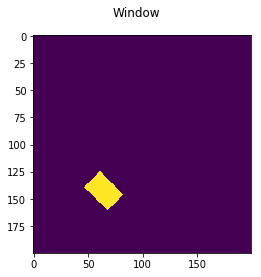

In [12]:
dataiter = iter(test_loader)
images, labels, coords = dataiter.next()

n = 1
print("\n\nFOR N = ", n)
imgSample = images[n]
max_idx = torch.argmax(coords[n][:,0])
y, x, theta = coords[n][max_idx]
print(labels[n])
print([float(zed) for zed in (x,y,theta)])
#print(x,y,theta)
#crops, __ = makeCrops(imgSample, 50, (100, 100), (x,y, theta))

plt.imshow(imgSample)
#fig, axess = plt.subplots(3,3, figsize=(10,10))
#axess = np.array(axess).flatten()#order='F') #'F' means to flatten in column-major (Fortran- style) order.
#for i in range(9):
#    axess[i].imshow(crops[i])
#    axess[i].set_ylabel('# '+str(i))
plt.suptitle('Window')
plt.show()

In [13]:
# -- Check the results -------------------------------------------------------

# -- Utility ---------------------------------------------
def makeCrops(image, stepSize, windowSize, true_center):
    """
    """
    image = image.type(torch.FloatTensor)
    crops = []
    truths = []
    c_x, c_y, orient = true_center
    # TODO: look into otdering, why it's y,x !
    margin = 10 
    # --> is x, but is the column
    # to slide horizontally, y must come first
    for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
            end_x, end_y = x + windowSize[1], y + windowSize[0]
            hasRect = (x + margin < c_x < end_x - margin) and (
                y + margin < c_y < end_y - margin
            )
            truths.append(hasRect)
            crops.append(image[y:end_y, x:end_x])
    crops = torch.stack(crops)
    print("shape of crops", crops.shape)
    return crops, truths


losses = AverageMeter()  # loss
losses2 = AverageMeter()  # loss


# -- Get some validation results ---------------------------------------------
classifModel.to(device).eval()
regrModel.to(device).eval()

c_criterion = nn.BCELoss()
r_criterion = nn.MSELoss()

with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels, coords = dataiter.next()
    
    # Move to default device
    images = images.to(device)
    labels = labels.to(device)
    coords = coords.to(device)

    # Forward pass
    predicted_class, all_crops = classifModel(images)
    # Loss
    loss = c_criterion(predicted_class, labels)
    all_crops = all_crops.to(device)
    
    loss1 = c_criterion(predicted_class, labels)

    # Forward pass
    labelly = predicted_class.detach().cpu().numpy()
    predicted_coords = regrModel(all_crops, labelly)

    loss2 = r_criterion(predicted_coords, coords)

    losses2.update(loss2.item())

        # Print status
    
print("loss across batch size of ", labels.size()[0], 'is: \n', loss1, loss2)
#print(labels)
print('\n!-- labels size', labels.size())
#print(torch.round(predicted_class))



loss across batch size of  30 is: 
 tensor(0.0193, device='cuda:0') tensor(204.2059, device='cuda:0')

!-- labels size torch.Size([30, 9])


5000


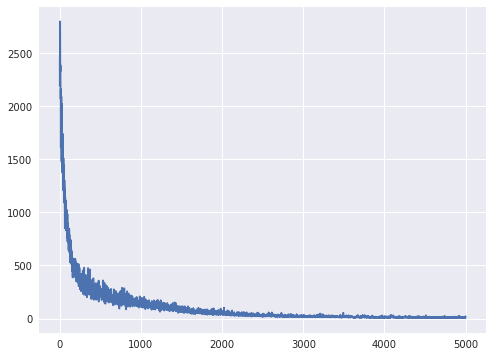

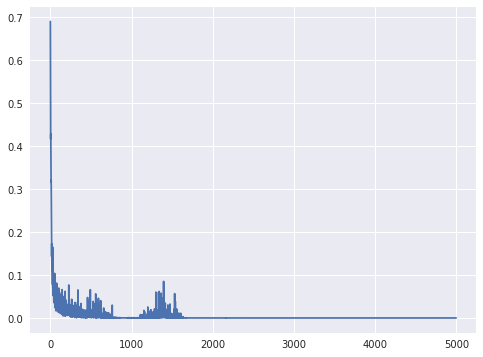

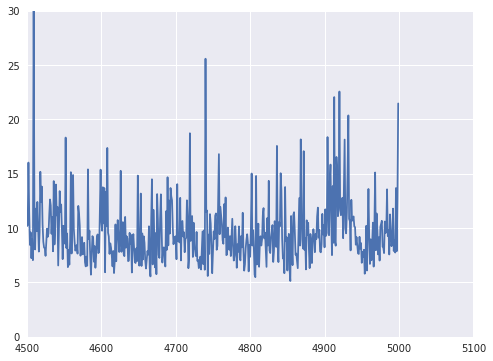

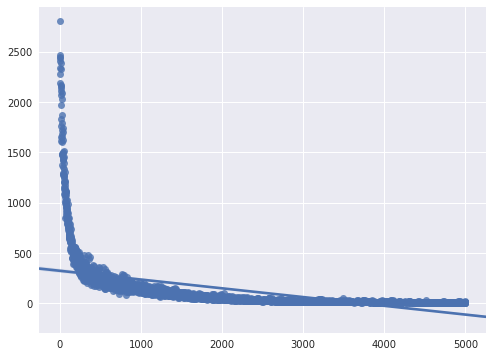

In [35]:
plt_loss2_list
print(len(plt_loss2_list))
plt.plot(range(len(plt_loss2_list)), plt_loss2_list) # regr loss
plt.show()
plt.plot(range(len(plt_loss_list)), plt_loss_list) # class lost
plt.show()
plt.plot(range(len(plt_loss2_list)), plt_loss2_list) # regr loss
plt.xlim((4500, 5100))
plt.ylim((0,30))
plt.show()
import seaborn as sns
sns.regplot(x=np.arange(len(plt_loss2_list[0:])), y=np.array(plt_loss2_list[0:])) # regr loss

shape of crops torch.Size([9, 100, 100])
!-- coords tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 69., 178.,  28.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [ 69., 178.,  28.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]], device='cuda:0')
!-- FOR N =  7
y (crops) 
	 [0, 0, 1, 0, 0, 1, 0, 0, 0]
!-- yhat (crops) 
	 [0, 0, 1, 0, 0, 1, 0, 0, 0]


FOR N =  7
!-- center y 
	 [69.0, 178.0, 28.0]
!-- center y est 
	  [71.24313354492188, 181.68051147460938, 57.60748291015625]
tensor([[  3.8877,   7.2213,   5.4432],
        [ -2.3332, -11.8502,  -0.9397],
        [ 71.2431, 181.6805,  57.6075],
        [ -9.0129,   0.2488,   4.8658],
        [  8.7243,   4.9679,   6.5384],
        [ 56.3092, 157.6708,  31.9407],
        [  2.7320,   5.3130,  18.9852],
        [  0.0562,  -1.2246,   1.9236],
        [  0.9446,   4.6528,   0.4388]], device='cuda:0')
!! -- --MSE:  298.39361903009313


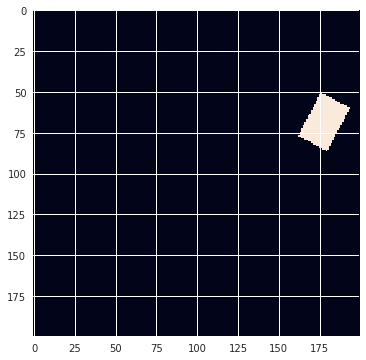

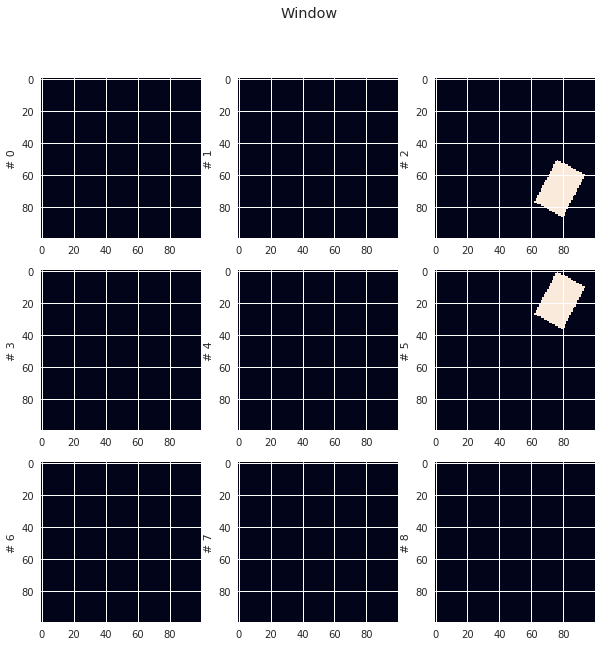

In [26]:
# -- Plot windows and print labels -----------------------------------

with torch.no_grad():
    n = np.random.randint(10)
    imgSample = images[n]
    crops, __ = makeCrops(imgSample, 50, (100, 100), (x,y, theta))
    # -- Show original image, and the sliding windo crops -------
    plt.imshow(imgSample)
    # ---------------------------------------------------
    foo_label = labels[n]

    foo_coord = coords[n] 
    predicted_locs = predicted_coords.view(-1,
                                         coords.size(1), coords.size(2))
    foo_coord_est = predicted_locs[n] # 3 per window
    foo_label_est = predicted_class[n]
    print('!-- coords', foo_coord)

    max_idx = torch.argmax(foo_coord[:,0])
    x, y, theta = foo_coord[max_idx]
    est_max_idx = torch.argmax(foo_coord_est[:,0])
    x_est, y_est, theta_est = foo_coord_est[est_max_idx]

    # -- Print x,y for one result -------
    # -- Print window t/f for one result -------
    print("!-- FOR N = ", n)
    print("y (crops) \n\t", [int(l) for l in foo_label])
    print("!-- yhat (crops) \n\t", [int(np.round(p,0)) for p in foo_label_est] )
    # -------------------------------------------------
    sns.set(rc={"figure.figsize": (8, 6)})

    print("\n\nFOR N = ", n)
    print("!-- center y \n\t", [float(zed) for zed in (x, y, theta)])
    print("!-- center y est \n\t ", [float(zed) for zed in (x_est, y_est, theta_est)])
    print(foo_coord_est)

    a = np.array([float(zed) for zed in (x, y, theta)])
    b = np.array([float(zed) for zed in (x_est, y_est, theta_est)])
    mse = ((a - b) ** 2).mean(axis=0)
    print('!! -- --MSE: ', mse)

    fig, axess = plt.subplots(3,3, figsize=(10,10))
    axess = np.array(axess).flatten()#order='F') #'F' means to flatten in column-major (Fortran- style) order.
    for i in range(9):
        axess[i].imshow(crops[i])
        axess[i].set_ylabel('# '+str(i))
    plt.suptitle('Window')
    plt.show()

    #for (i, crop) in enumerate(crops):
        # print("1-index number of window: ", i+1, 'x', x, 'y', y, 'has rectangle?', hasRect)
        #plt.figure()
        #plt.suptitle("numero: %d" % (i))
        #plt.imshow(crop)